In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import glob
import re
import openpyxl
import math
from matplotlib import pyplot as plt
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns
from scipy.stats import weibull_min

## Load Data

In [3]:
futures = pd.read_csv("./data/futures.csv")
options = pd.read_csv("./data/options.csv")

In [4]:
futures.head()

Timestamp Product     RefDate AssetDescription  Expiration  \
0  2023-01-03 15:00:00   SOFR3  2027-12-15   SR3 2028-03-14  2028-03-14   
1  2023-01-03 15:00:00   SOFR3  2024-03-20   SR3 2024-06-18  2024-06-18   
2  2023-01-03 15:00:00   SOFR3  2026-09-16   SR3 2026-12-15  2026-12-15   
3  2023-01-03 15:00:00   SOFR3  2025-06-18   SR3 2025-09-16  2025-09-16   
4  2023-01-03 15:00:00   SOFR3  2027-03-17   SR3 2027-06-15  2027-06-15   

   BIDPRICE0  BIDSIZE0  ASKPRICE0  ASKSIZE0  MID_PRICE  MICRO_PRICE  
0     96.685       259     96.695       245    96.6900    96.690139  
1     95.880      1511     95.885       245    95.8825    95.884302  
2     96.810      1136     96.820      1153    96.8150    96.814963  
3     96.835      1379     96.840        90    96.8375    96.839694  
4     96.770       141     96.775        50    96.7725    96.773691

In [5]:
options.head()

Timestamp                       AssetDescription BaseAssetName  \
0  2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375           SR3   
1  2023-01-03 15:00:00   SR3 2023-01-13 00:00:00 Puts 95.1875           SR3   
2  2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.1875           SR3   
3  2023-01-03 15:00:00   SR3 2023-01-13 00:00:00 Puts 95.9375           SR3   
4  2023-01-03 15:00:00   SR3 2023-01-13 00:00:00 Puts 95.0625           SR3   

   Expiration  StrikePrice AssetTypeName  BIDPRICE0  BIDSIZE0  ASKPRICE0  \
0  2023-01-13      95.4375         Calls     0.0025       742     0.0075   
1  2023-01-13      95.1875          Puts     0.1150      2198     0.1300   
2  2023-01-13      95.1875         Calls     0.0150      1578     0.0225   
3  2023-01-13      95.9375          Puts     0.8450       282     0.8650   
4  2023-01-13      95.0625          Puts     0.0425      5435     0.0550   

   ASKSIZE0  MID_PRICE  MICRO_PRICE  
0      1713    0.00500     0.004011  
1      2369    0.12250     0.122219  
2      1974    0.01875     0.018332  
3       282    0.85500     0.855000  
4     10681    0.04875     0.046716

In [6]:
futures['Expiration'] = pd.to_datetime(futures['Expiration'])
futures['year'] = [date.year for date in futures['Expiration']]
futures['month'] = [date.month for date in futures['Expiration']]
futures['Timestamp'] = pd.to_datetime(futures['Timestamp'])

In [7]:
options['Timestamp'] = pd.to_datetime(options['Timestamp'])

In [8]:
BucketRates = {}
path = './data/rate_curve'
csv_files = glob.glob(os.path.join(path, "BucketRate_*.csv"))

# keys format: yyyymmdd
for f in csv_files:
    date = re.findall(r'\d+', f)[0][:-6]
    BucketRates[date] = pd.read_csv(f)
    BucketRates[date]['CumLength'] = BucketRates[date]['BucketLength'].cumsum()


In [9]:
FEDRates = {}
path = './data/rate_curve'
csv_files = glob.glob(os.path.join(path, "FEDDecisionDist_*.csv"))

# keys format: yyyymmdd
for f in csv_files:
    date = re.findall(r'\d+', f)[0][:-6]
    FEDRates[date] = pd.read_csv(f)
    FEDRates[date] = FEDRates[date].rename(columns={'Unnamed: 0': 'Date'})
    FEDRates[date]['Date'] = pd.to_datetime(FEDRates[date]['Date'])

In [10]:
index = pd.read_excel('./data/INDEX.xlsx')
index.head()

Effective Date Rate Type  Rate (%)  1st Percentile (%)  25th Percentile (%)  \
0     07/10/2023    SOFRAI       NaN                 NaN                  NaN   
1     07/07/2023    SOFRAI       NaN                 NaN                  NaN   
2     07/06/2023    SOFRAI       NaN                 NaN                  NaN   
3     07/05/2023    SOFRAI       NaN                 NaN                  NaN   
4     07/03/2023    SOFRAI       NaN                 NaN                  NaN   

   75th Percentile (%)  99th Percentile (%)  Volume ($Billions)  \
0                  NaN                  NaN                 NaN   
1                  NaN                  NaN                 NaN   
2                  NaN                  NaN                 NaN   
3                  NaN                  NaN                 NaN   
4                  NaN                  NaN                 NaN   

   Target Rate From (%)  Target Rate To (%)  Intra Day - Low (%)  \
0                   NaN                 NaN                  NaN   
1                   NaN                 NaN                  NaN   
2                   NaN                 NaN                  NaN   
3                   NaN                 NaN                  NaN   
4                   NaN                 NaN                  NaN   

   Intra Day - High (%)  Standard Deviation (%)  30-Day Average SOFR  \
0                   NaN                     NaN              5.06724   
1                   NaN                     NaN              5.06626   
2                   NaN                     NaN              5.06593   
3                   NaN                     NaN              5.06593   
4                   NaN                     NaN              5.06660   

   90-Day Average SOFR  180-Day Average SOFR  SOFR Index  \
0              5.02291               4.82673    1.086809   
1              5.01449               4.81394    1.086351   
2              5.01166               4.80967    1.086199   
3              5.00883               4.80540    1.086046   
4              5.00343               4.79682    1.085741   

   Revision Indicator (Y/N)  Footnote ID  
0                       NaN          NaN  
1                       NaN          NaN  
2                       NaN          NaN  
3                       NaN          NaN  
4                       NaN          NaN

In [11]:
index['Effective Date'] = [datetime.strptime(d, '%m/%d/%Y') for d in index['Effective Date']]

In [12]:
index = index.sort_values(by=['Effective Date'], ascending=True)
index.index = range(len(index))
index.head()

Effective Date Rate Type  Rate (%)  1st Percentile (%)  25th Percentile (%)  \
0     2022-07-01    SOFRAI       NaN                 NaN                  NaN   
1     2022-07-05    SOFRAI       NaN                 NaN                  NaN   
2     2022-07-06    SOFRAI       NaN                 NaN                  NaN   
3     2022-07-07    SOFRAI       NaN                 NaN                  NaN   
4     2022-07-08    SOFRAI       NaN                 NaN                  NaN   

   75th Percentile (%)  99th Percentile (%)  Volume ($Billions)  \
0                  NaN                  NaN                 NaN   
1                  NaN                  NaN                 NaN   
2                  NaN                  NaN                 NaN   
3                  NaN                  NaN                 NaN   
4                  NaN                  NaN                 NaN   

   Target Rate From (%)  Target Rate To (%)  Intra Day - Low (%)  \
0                   NaN                 NaN                  NaN   
1                   NaN                 NaN                  NaN   
2                   NaN                 NaN                  NaN   
3                   NaN                 NaN                  NaN   
4                   NaN                 NaN                  NaN   

   Intra Day - High (%)  Standard Deviation (%)  30-Day Average SOFR  \
0                   NaN                     NaN              1.11248   
1                   NaN                     NaN              1.21022   
2                   NaN                     NaN              1.23558   
3                   NaN                     NaN              1.26094   
4                   NaN                     NaN              1.28663   

   90-Day Average SOFR  180-Day Average SOFR  SOFR Index  \
0              0.71206               0.40178    1.044478   
1              0.76637               0.43451    1.044654   
2              0.78018               0.44281    1.044699   
3              0.79398               0.45111    1.044744   
4              0.80779               0.45940    1.044788   

   Revision Indicator (Y/N)  Footnote ID  
0                       NaN          NaN  
1                       NaN          NaN  
2                       NaN          NaN  
3                       NaN          NaN  
4                       NaN          NaN

## Future features
### Future price distribution

In [30]:
futures.MID_PRICE.describe()

count    4736.000000
mean       95.832917
std         1.927669
min         0.000000
25%        95.072500
50%        95.582500
75%        96.812500
max        97.395000
Name: MID_PRICE, dtype: float64

In [28]:
futures.columns

Index(['Timestamp', 'Product', 'RefDate', 'AssetDescription', 'Expiration',
       'BIDPRICE0', 'BIDSIZE0', 'ASKPRICE0', 'ASKSIZE0', 'MID_PRICE',
       'MICRO_PRICE', 'year', 'month'],
      dtype='object')

In [29]:
options.columns

Index(['Timestamp', 'AssetDescription', 'BaseAssetName', 'Expiration',
       'StrikePrice', 'AssetTypeName', 'BIDPRICE0', 'BIDSIZE0', 'ASKPRICE0',
       'ASKSIZE0', 'MID_PRICE', 'MICRO_PRICE'],
      dtype='object')

In [19]:
# drop abnormal data
futures = futures[(futures['MID_PRICE'] > 50)]

Text(0.5, 1.0, 'Distribution of Future Prices')

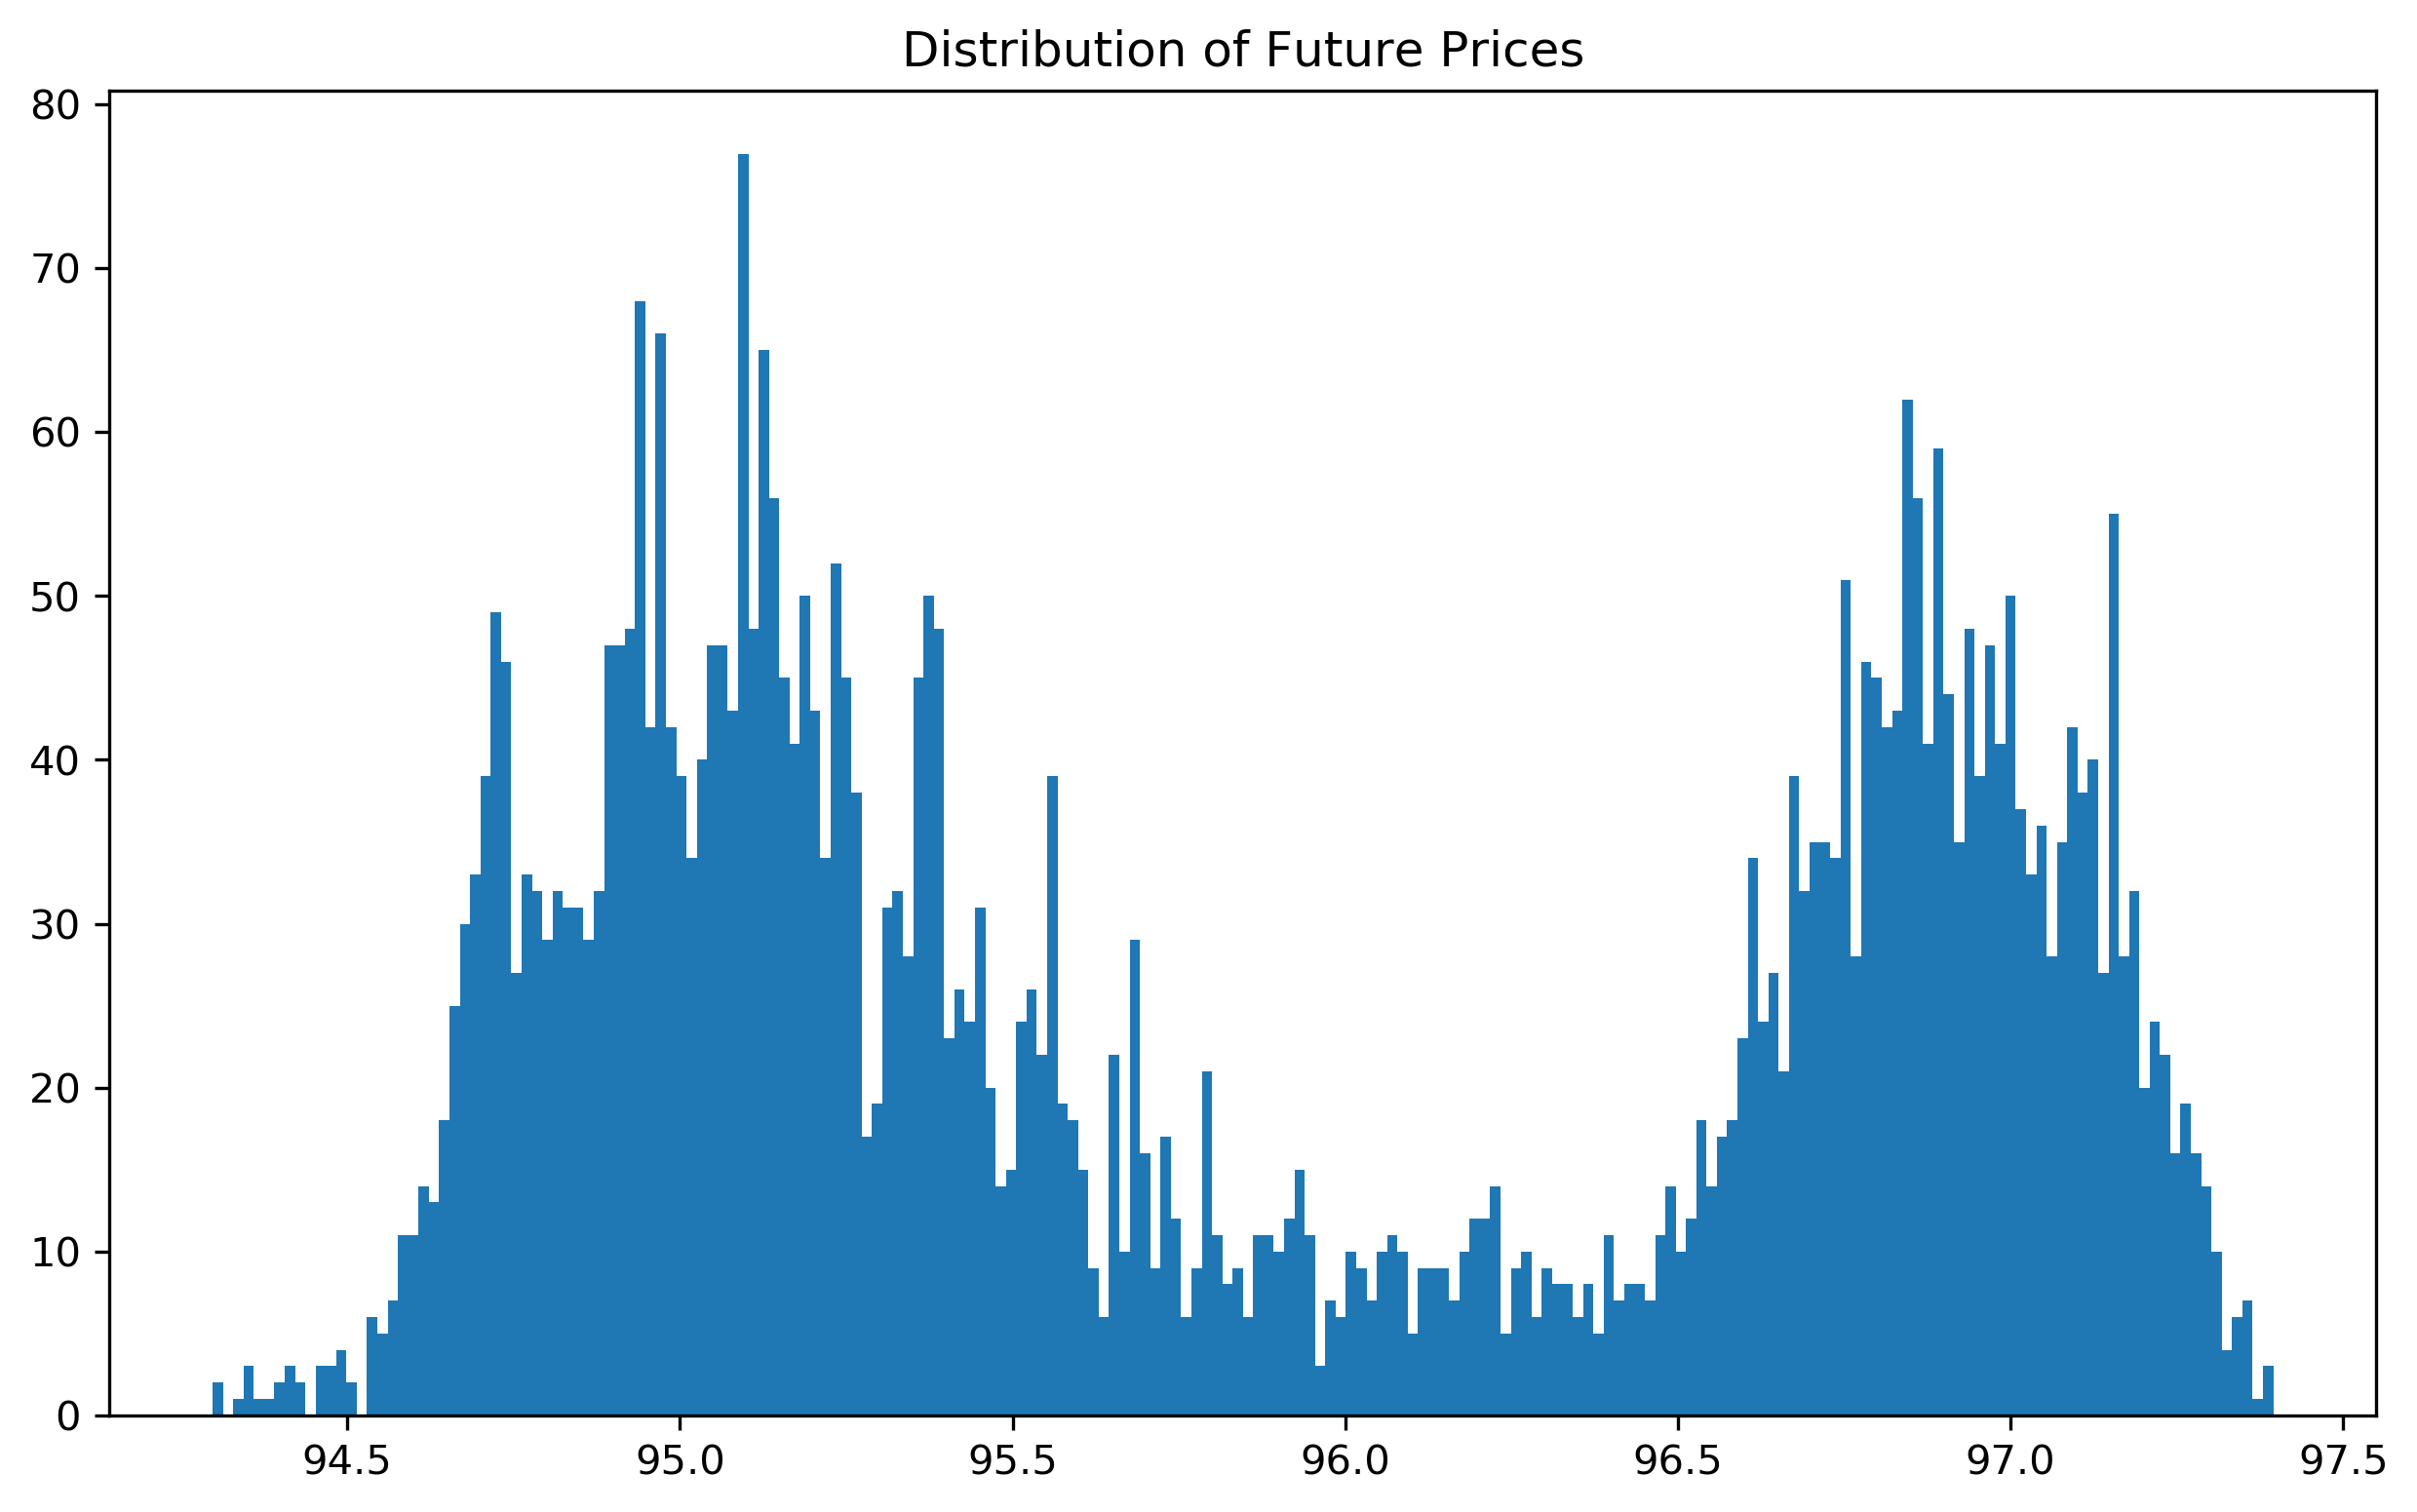

In [26]:
plt.figure(dpi=300, figsize=(10, 6))
plt.hist(futures.MID_PRICE, bins=200)
plt.title('Distribution of Future Prices')

### Future volatility distribution

In [16]:
futures_use = futures[(futures['Expiration'] <= '2023-12-30') & (futures['Product'] == 'SOFR3')].copy()

In [17]:
futures_use = futures_use[(futures_use['AssetDescription'] != 'SR3 2023-08-15') & (futures_use['AssetDescription'] != 'SR3 2023-10-17')].copy()

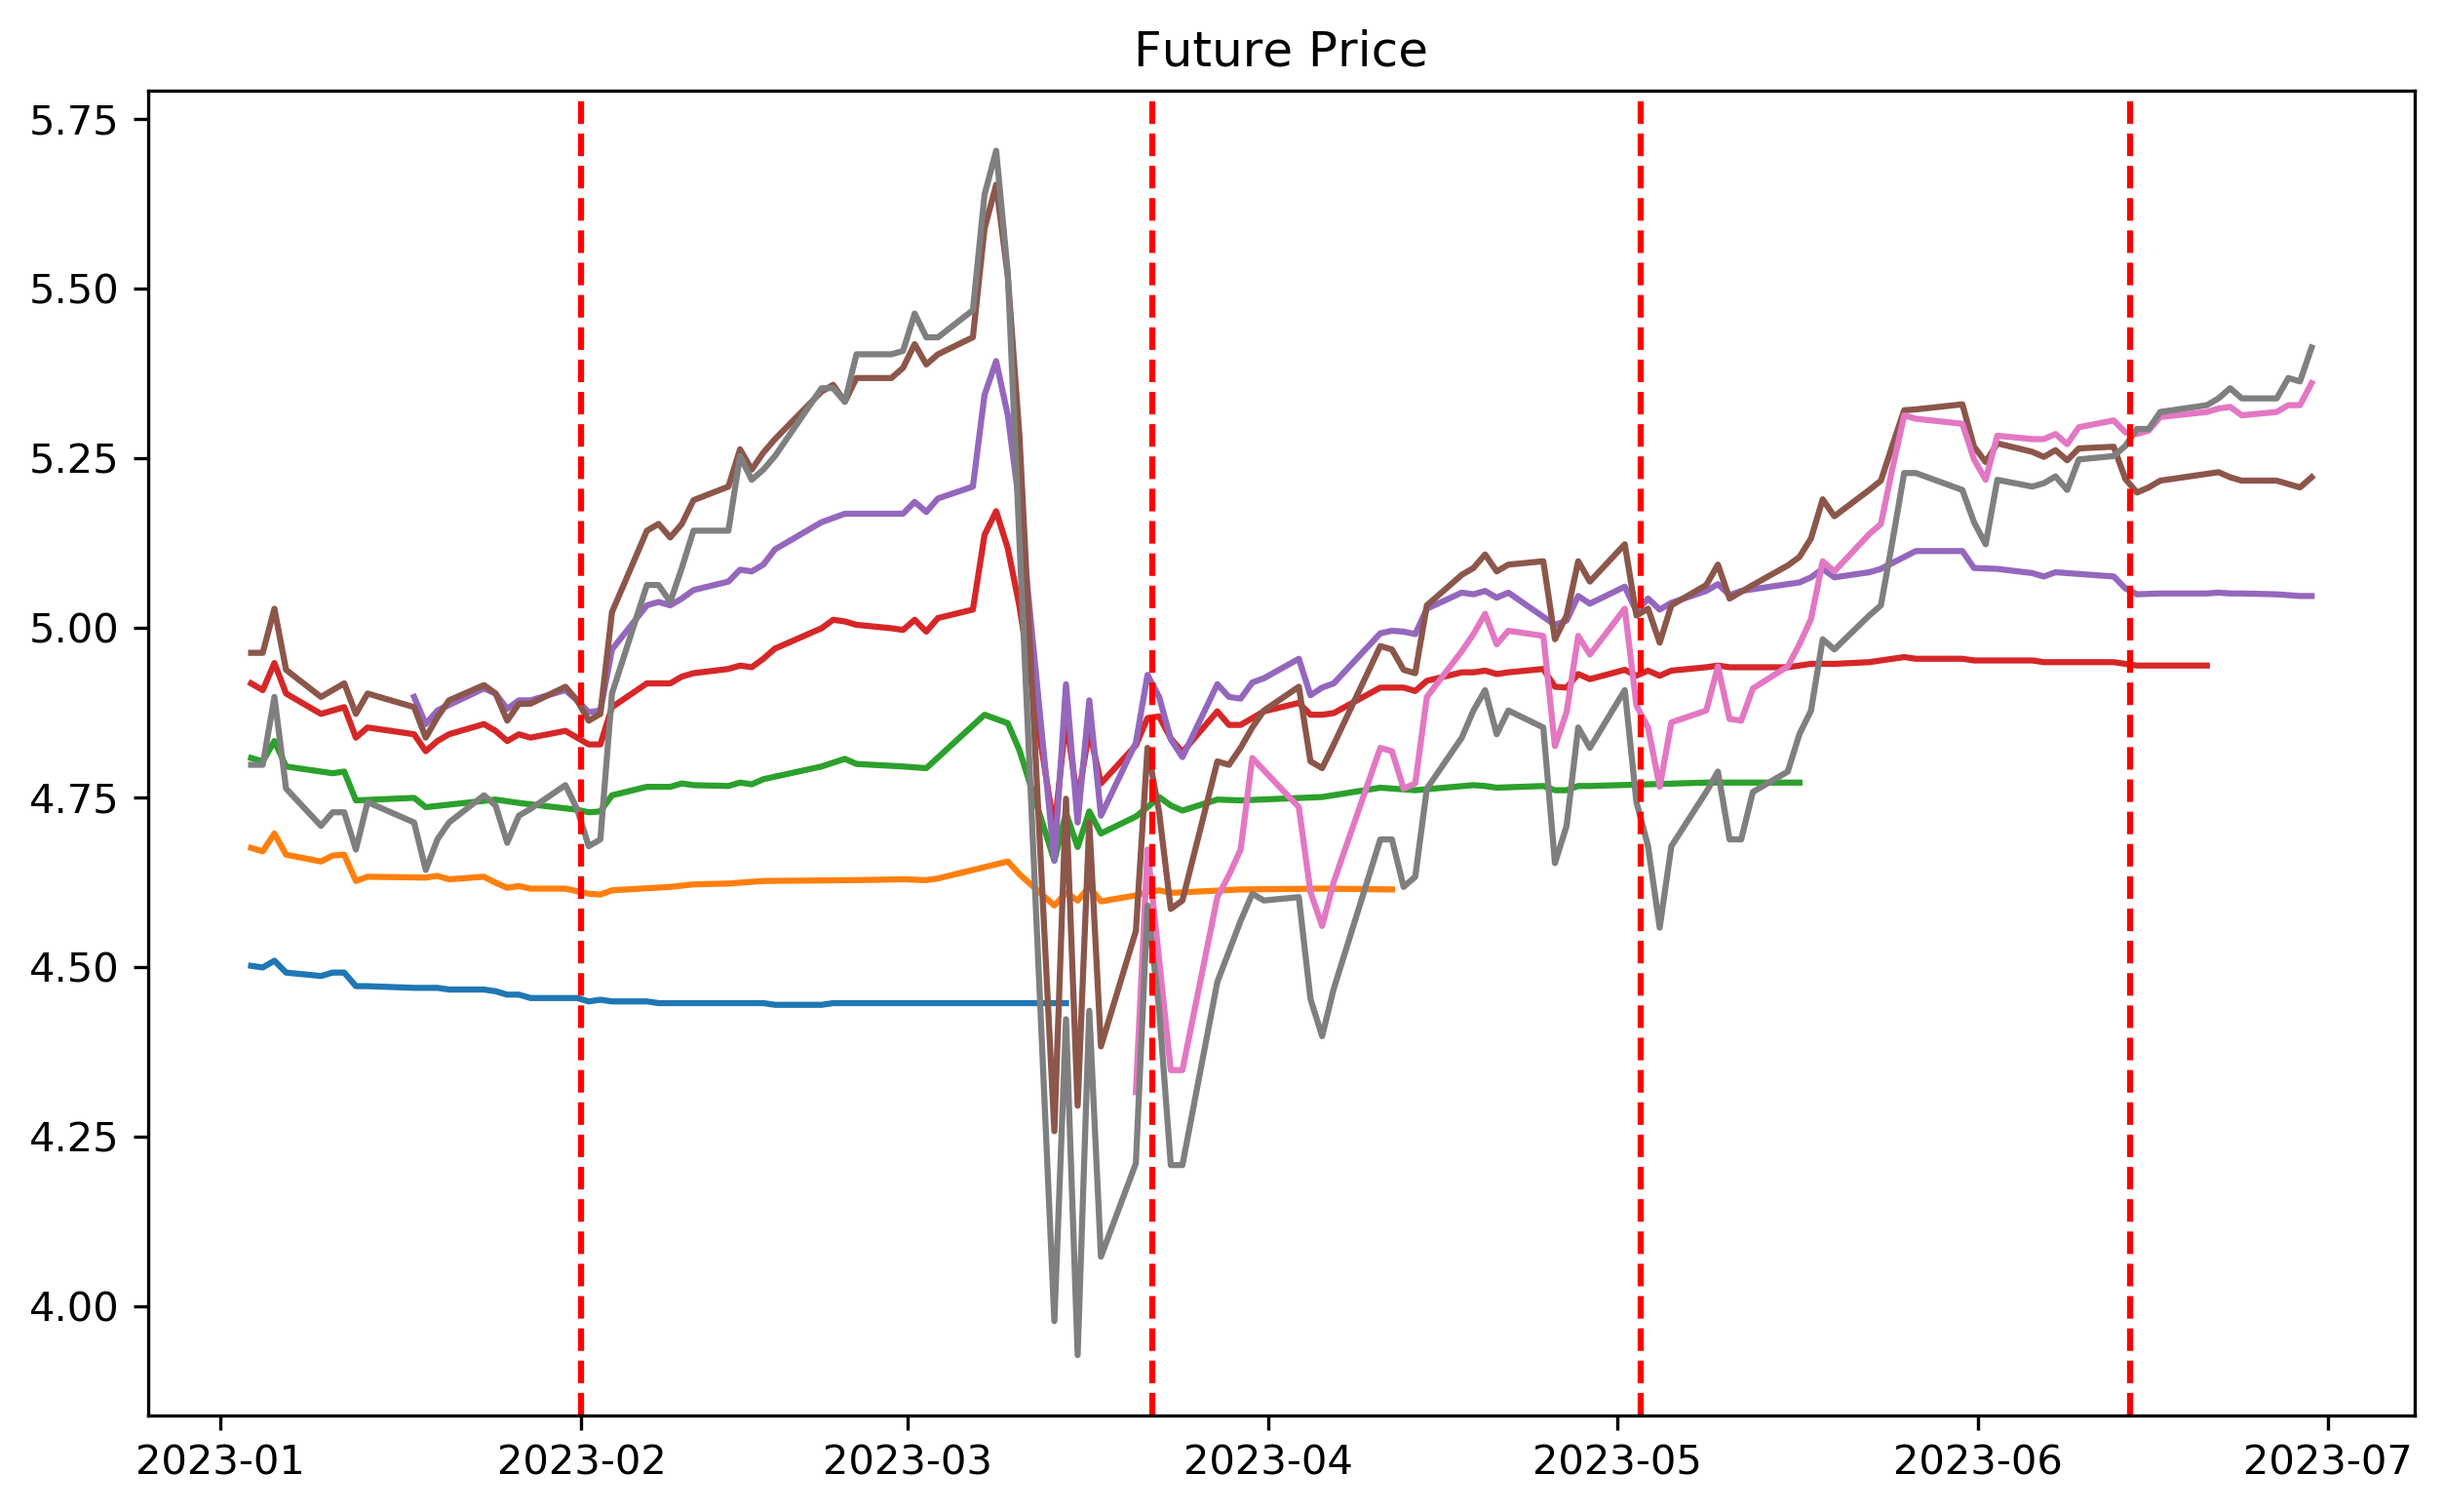

In [18]:
grouped = futures_use.groupby('AssetDescription')
plt.figure(dpi=300, figsize=(10, 6))
for desc, f in grouped:
    if desc != "SR3 2023-02-14": 
        plt.plot(f.Timestamp, 100-f.MID_PRICE)
plt.axvline(x=datetime.strptime('2023-02-01', '%Y-%m-%d'), c='r', linestyle='--')
plt.axvline(x=datetime.strptime('2023-03-22', '%Y-%m-%d'), c='r', linestyle='--')
plt.axvline(x=datetime.strptime('2023-05-03', '%Y-%m-%d'), c='r', linestyle='--')
plt.axvline(x=datetime.strptime('2023-06-14', '%Y-%m-%d'), c='r', linestyle='--')
plt.title('Future Price')
plt.savefig('./fig/futureprice_ts.png')
        # plt.title(desc)
        # plt.show()

In [59]:
grouped = futures.groupby('AssetDescription')
future_vol = futures.groupby('AssetDescription', group_keys=False).apply(lambda x: np.std(x[['MID_PRICE']]))
future_vol['LENTH'] = futures.groupby('AssetDescription', group_keys=False).apply(lambda x: len(x))

In [60]:
future_vol = future_vol[future_vol['MID_PRICE'] < 1]

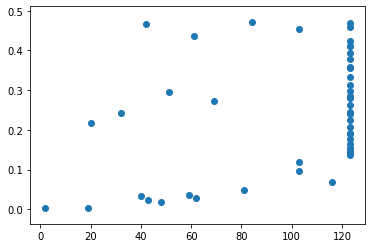

In [61]:
plt.scatter(future_vol.LENTH, future_vol.MID_PRICE)

In [166]:
futures

Timestamp Product     RefDate AssetDescription Expiration  \
0    2023-01-03 15:00:00   SOFR3  2027-12-15   SR3 2028-03-14 2028-03-14   
1    2023-01-03 15:00:00   SOFR3  2024-03-20   SR3 2024-06-18 2024-06-18   
2    2023-01-03 15:00:00   SOFR3  2026-09-16   SR3 2026-12-15 2026-12-15   
3    2023-01-03 15:00:00   SOFR3  2025-06-18   SR3 2025-09-16 2025-09-16   
4    2023-01-03 15:00:00   SOFR3  2027-03-17   SR3 2027-06-15 2027-06-15   
...                  ...     ...         ...              ...        ...   
4731 2023-06-29 15:00:00   SOFR1  2024-04-30   SR1 2024-04-30 2024-04-30   
4732 2023-06-29 15:00:00   SOFR3  2023-10-18   SR3 2024-01-16 2024-01-16   
4733 2023-06-29 15:00:00   SOFR1  2024-05-31   SR1 2024-05-31 2024-05-31   
4734 2023-06-29 15:00:00   SOFR3  2023-11-15   SR3 2024-02-20 2024-02-20   
4735 2023-06-29 15:00:00   SOFR1  2024-06-28   SR1 2024-06-28 2024-06-28   

      BIDPRICE0  BIDSIZE0  ASKPRICE0  ASKSIZE0  MID_PRICE  MICRO_PRICE  year  \
0        96.685       259     96.695       245    96.6900    96.690139  2028   
1        95.880      1511     95.885       245    95.8825    95.884302  2024   
2        96.810      1136     96.820      1153    96.8150    96.814963  2026   
3        96.835      1379     96.840        90    96.8375    96.839694  2025   
4        96.770       141     96.775        50    96.7725    96.773691  2027   
...         ...       ...        ...       ...        ...          ...   ...   
4731     94.815        75     94.830        48    94.8225    94.824146  2024   
4732     94.560         5     94.575       315    94.5675    94.560234  2024   
4733     94.960        30     94.970         2    94.9650    94.969375  2024   
4734     94.575        99     94.590        50    94.5825    94.584966  2024   
4735     95.085        17     95.095        14    95.0900    95.090484  2024   

      month    return  
0         3       NaN  
1         6       NaN  
2        12       NaN  
3         9       NaN  
4         6       NaN  
...     ...       ...  
4731      4 -0.001527  
4732      1 -0.000660  
4733      5 -0.001761  
4734      2 -0.000951  
4735      6 -0.001758  

[4736 rows x 14 columns]

In [161]:
# calculate returns
grouped = futures.groupby('AssetDescription')
futures_ls = []
for name, product in grouped:
    product[['return']] = product[['MID_PRICE']].pct_change()
    futures_ls.append(product)
futures_ls = pd.concat(futures_ls)
futures = futures_ls.sort_index()

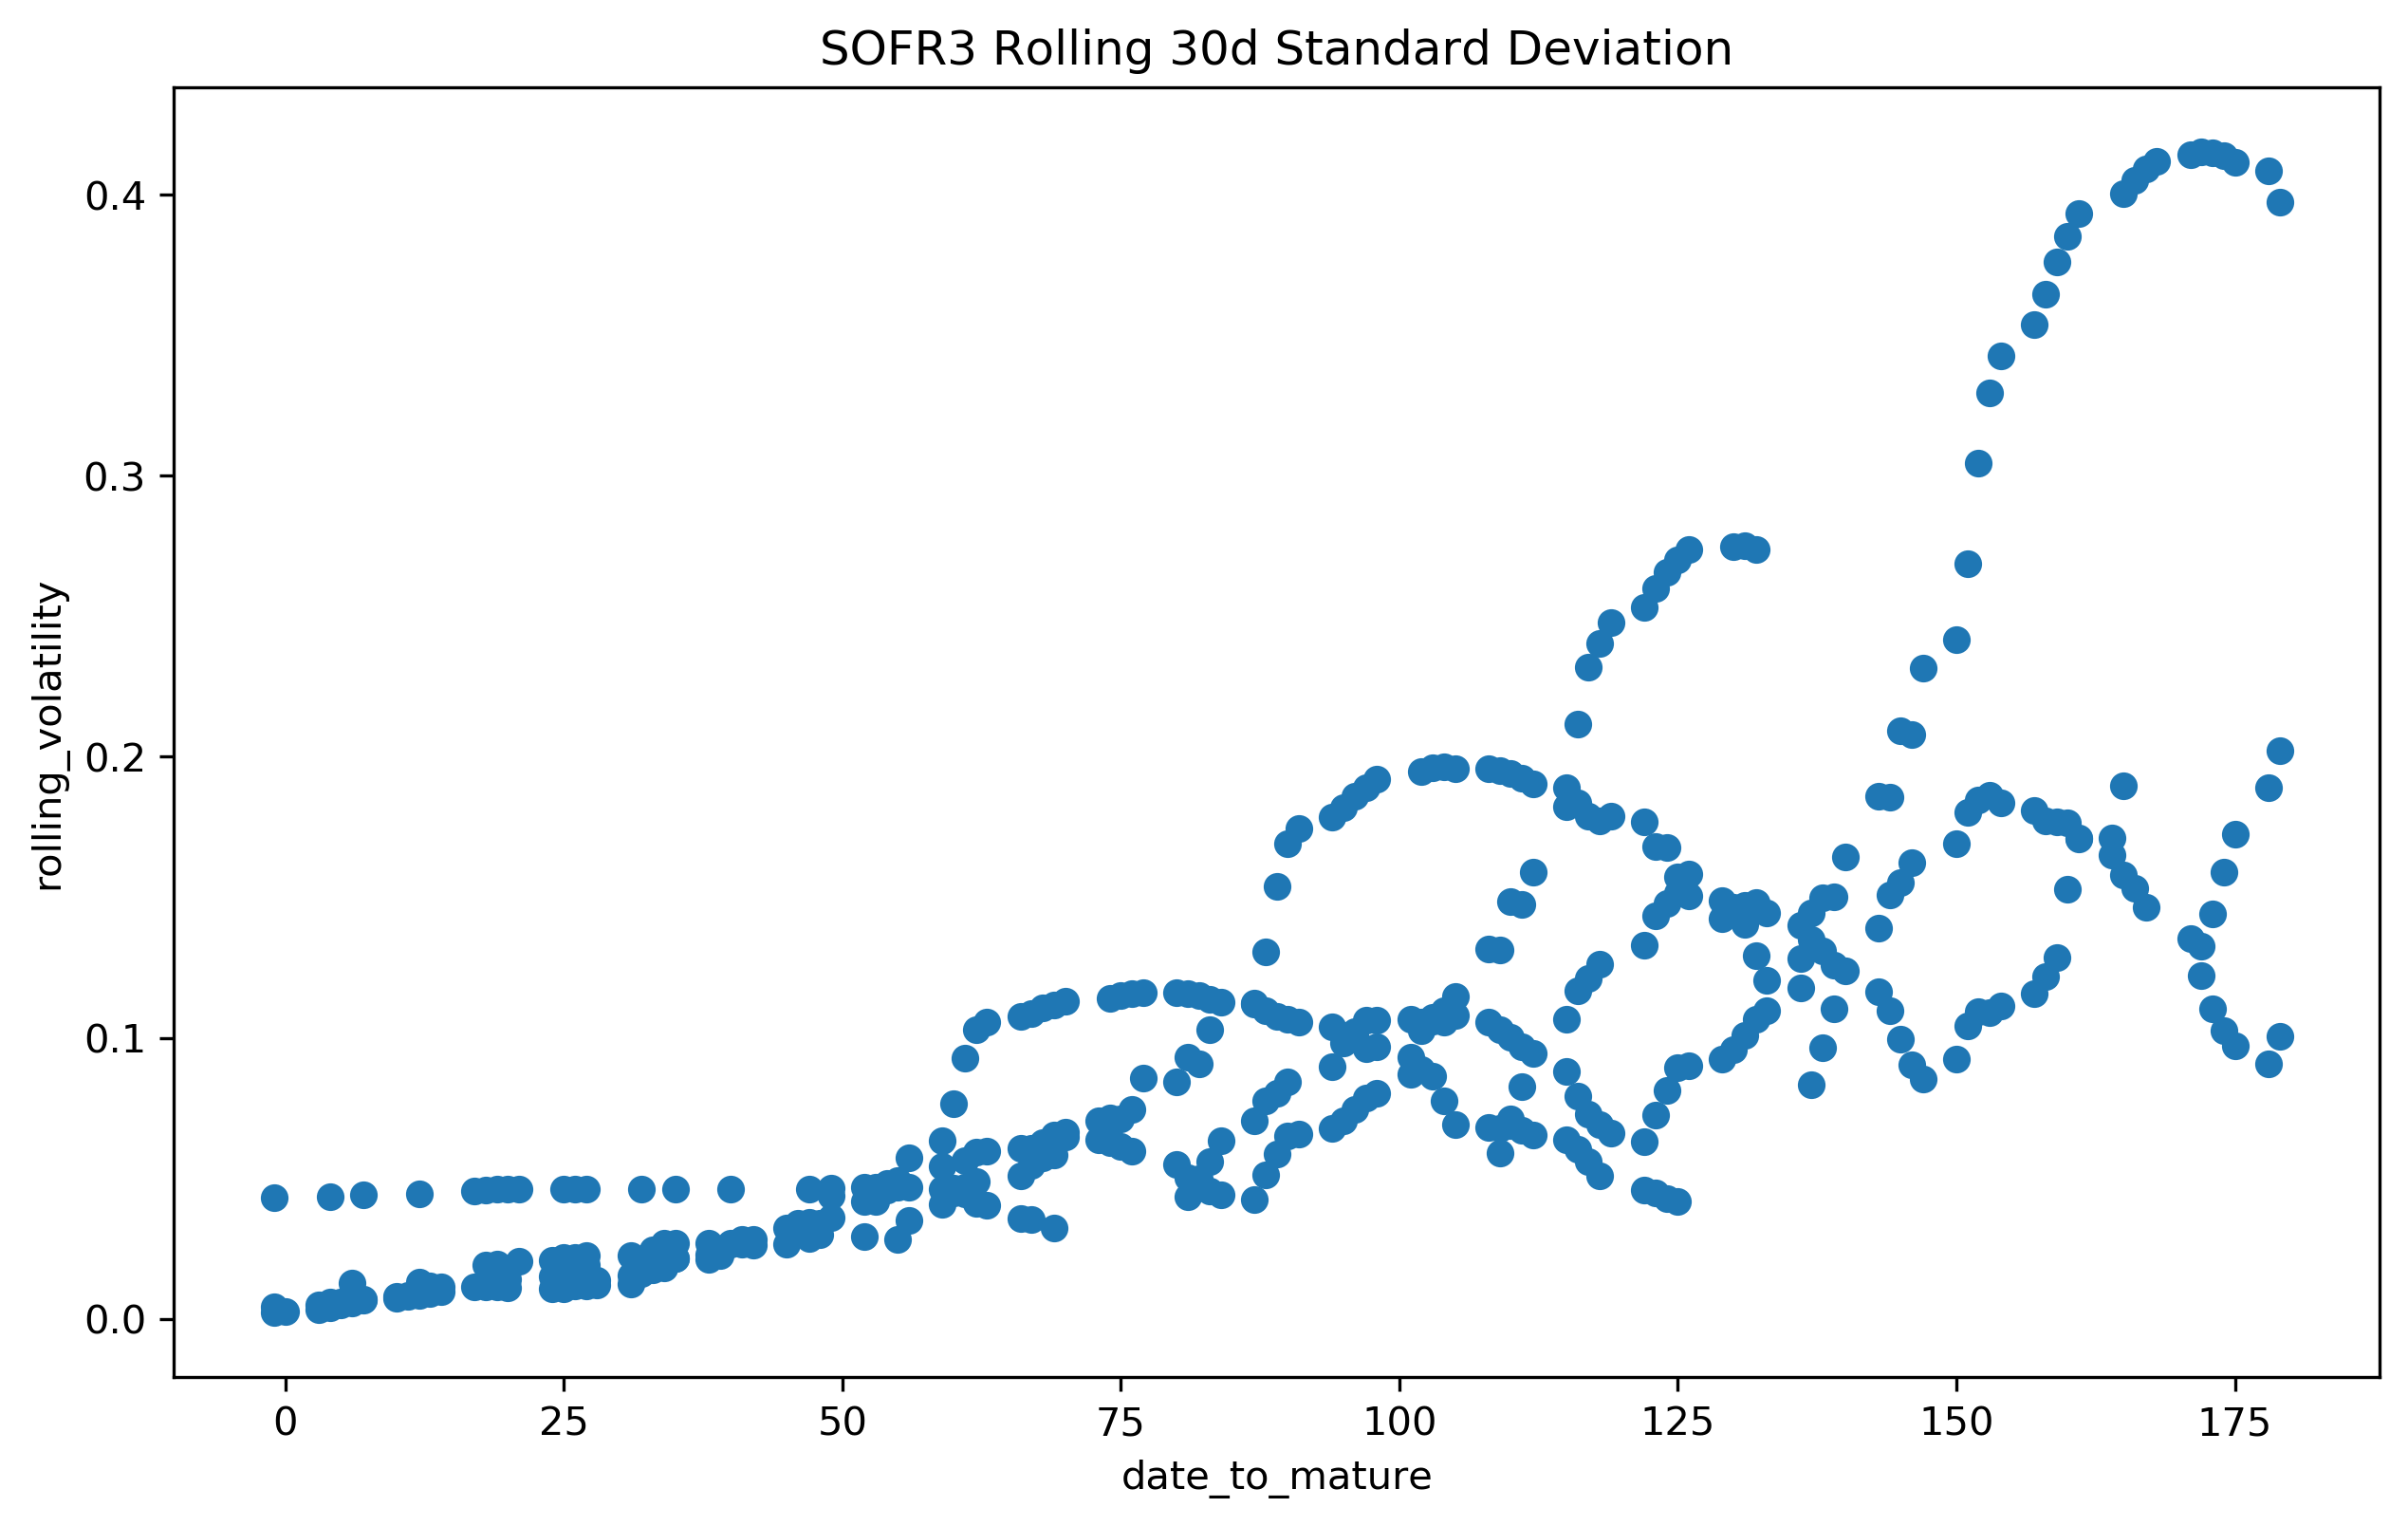

In [27]:
grouped = futures.groupby('AssetDescription')
futures_new = []
for name, product in grouped:
    product['rolling_vol'] = product['MID_PRICE'].rolling(window=30).std() # .shift(-30)
    futures_new.append(product)
futures_new = pd.concat(futures_new)
futures_new['date_to_mature'] = [d.days for d in (futures_new['Expiration'] - futures_new['Timestamp'])]
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]

plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(futures_show.date_to_mature, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 30d Standard Deviation')
plt.xlabel('date_to_mature')
plt.ylabel('rolling_volatility')
plt.savefig('./fig/rolling_std.png')

In [63]:
grouped = futures_show.groupby('date_to_mature')

15

-1
0
3
4
5
6
7
10
11
12
13
14
17
18
19


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, Fu

20
21
24
25
26
27
28
31
32
33
34
35
38
39
40
41
42
45
46
47
48
49
52
53
54
55
56
59
60
61


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` 

62
63
66
67
68
69
70
73
74
75
76
77
80
81
82
83
84
87


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, Fu

88
89
90
91
94
95
96
97
98
101
102
103


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` 

104
105
108
109
110
111
112
115
116
117
118


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, Fu

119
122
123
124
125
126
129
130
131
132
133
136
137
138
139
140
143
144
145
146
147
150
151
152
153
154
157
158
159
160
161
164
165
166
167
168
171
172
173
174
175
178
179


/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


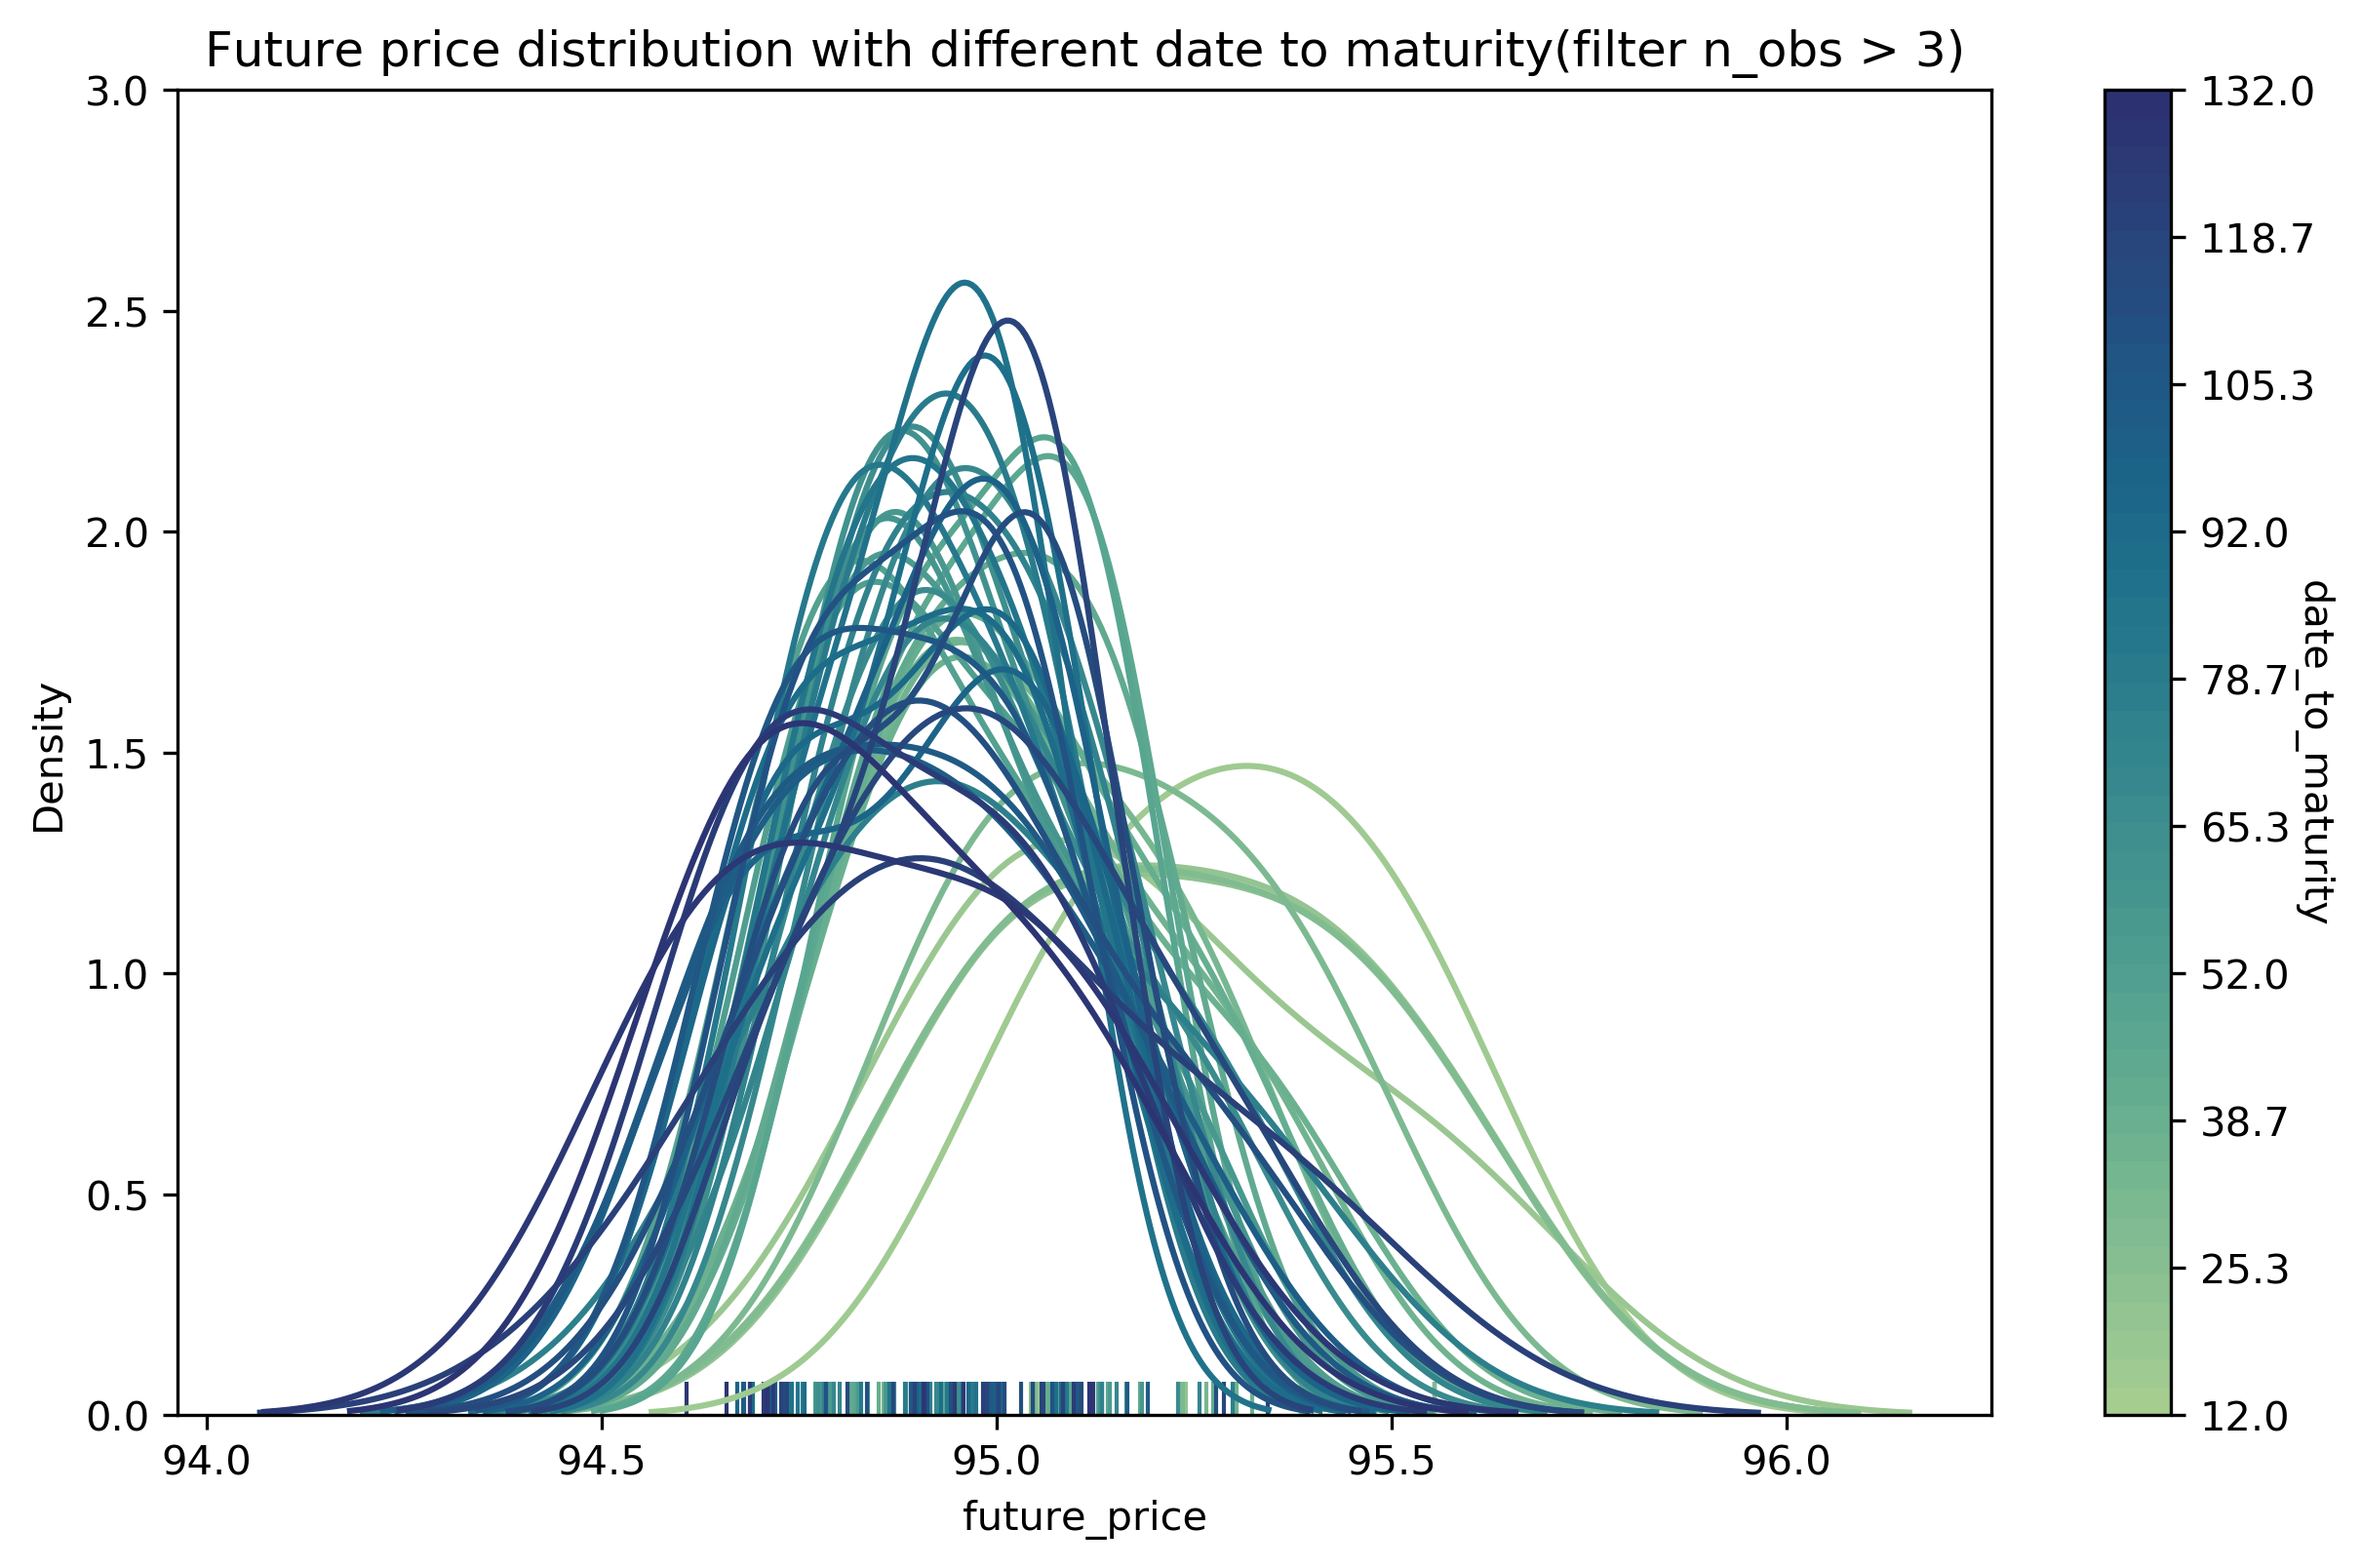

In [74]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

# grouped = future_show.groupby('AssetDescription')
# for 
# only related to sofr3 future
grouped = futures_show.groupby('date_to_mature')
plt.figure(dpi=300, figsize=(10, 6))

date_ls = []
N = 47
# diverging_colors = sns.color_palette("RdBu", 47)
sns.set_palette("crest", N)
cmap = plt.get_cmap("crest", N)

for date, group in grouped:
    # print(len(group))
    print(date)
    if len(group) > 3:
        date_ls.append(int(date))
        sns.distplot(group[['MID_PRICE']], hist=False, rug=True)
# plt.legend(date_ls, )
norm = mpl.colors.Normalize(vmin=min(date_ls), vmax=max(date_ls))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=np.linspace(min(date_ls), max(date_ls), 10))
# plt.colorbar((date_ls-min(date_ls))/max(date_ls))
cbar.ax.set_ylabel('date_to_maturity', rotation=270)
plt.ylim((0, 3))
plt.xlabel('future_price')
plt.title('Future price distribution with different date to maturity(filter n_obs > 3)')
plt.savefig('./fig/Future price distribution2.png')
plt.show()

2023-02-14 15:00:00
2023-02-15 15:00:00
2023-02-16 15:00:00
2023-02-17 15:00:00
2023-02-21 15:00:00
2023-02-22 15:00:00
2023-02-23 15:00:00
2023-02-24 15:00:00
2023-02-27 15:00:00
2023-02-28 15:00:00
2023-03-01 15:00:00
2023-03-02 15:00:00
2023-03-03 15:00:00
2023-03-06 15:00:00
2023-03-07 15:00:00
2023-03-08 15:00:00
2023-03-09 15:00:00
2023-03-10 15:00:00
2023-03-13 15:00:00
2023-03-14 15:00:00
2023-03-15 15:00:00
2023-03-16 15:00:00
2023-03-17 15:00:00
2023-03-20 15:00:00
2023-03-21 15:00:00
2023-03-22 15:00:00
2023-03-23 15:00:00
2023-03-24 15:00:00
2023-03-27 15:00:00
2023-03-28 15:00:00
2023-03-29 15:00:00
2023-03-30 15:00:00
2023-03-31 15:00:00
2023-04-03 15:00:00
2023-04-04 15:00:00
2023-04-05 15:00:00
2023-04-06 15:00:00
2023-04-10 15:00:00
2023-04-11 15:00:00
2023-04-12 15:00:00
2023-04-13 15:00:00
2023-04-14 15:00:00
2023-04-17 15:00:00
2023-04-18 15:00:00
2023-04-19 15:00:00
2023-04-20 15:00:00
2023-04-21 15:00:00
2023-04-24 15:00:00
2023-04-25 15:00:00
2023-04-26 15:00:00


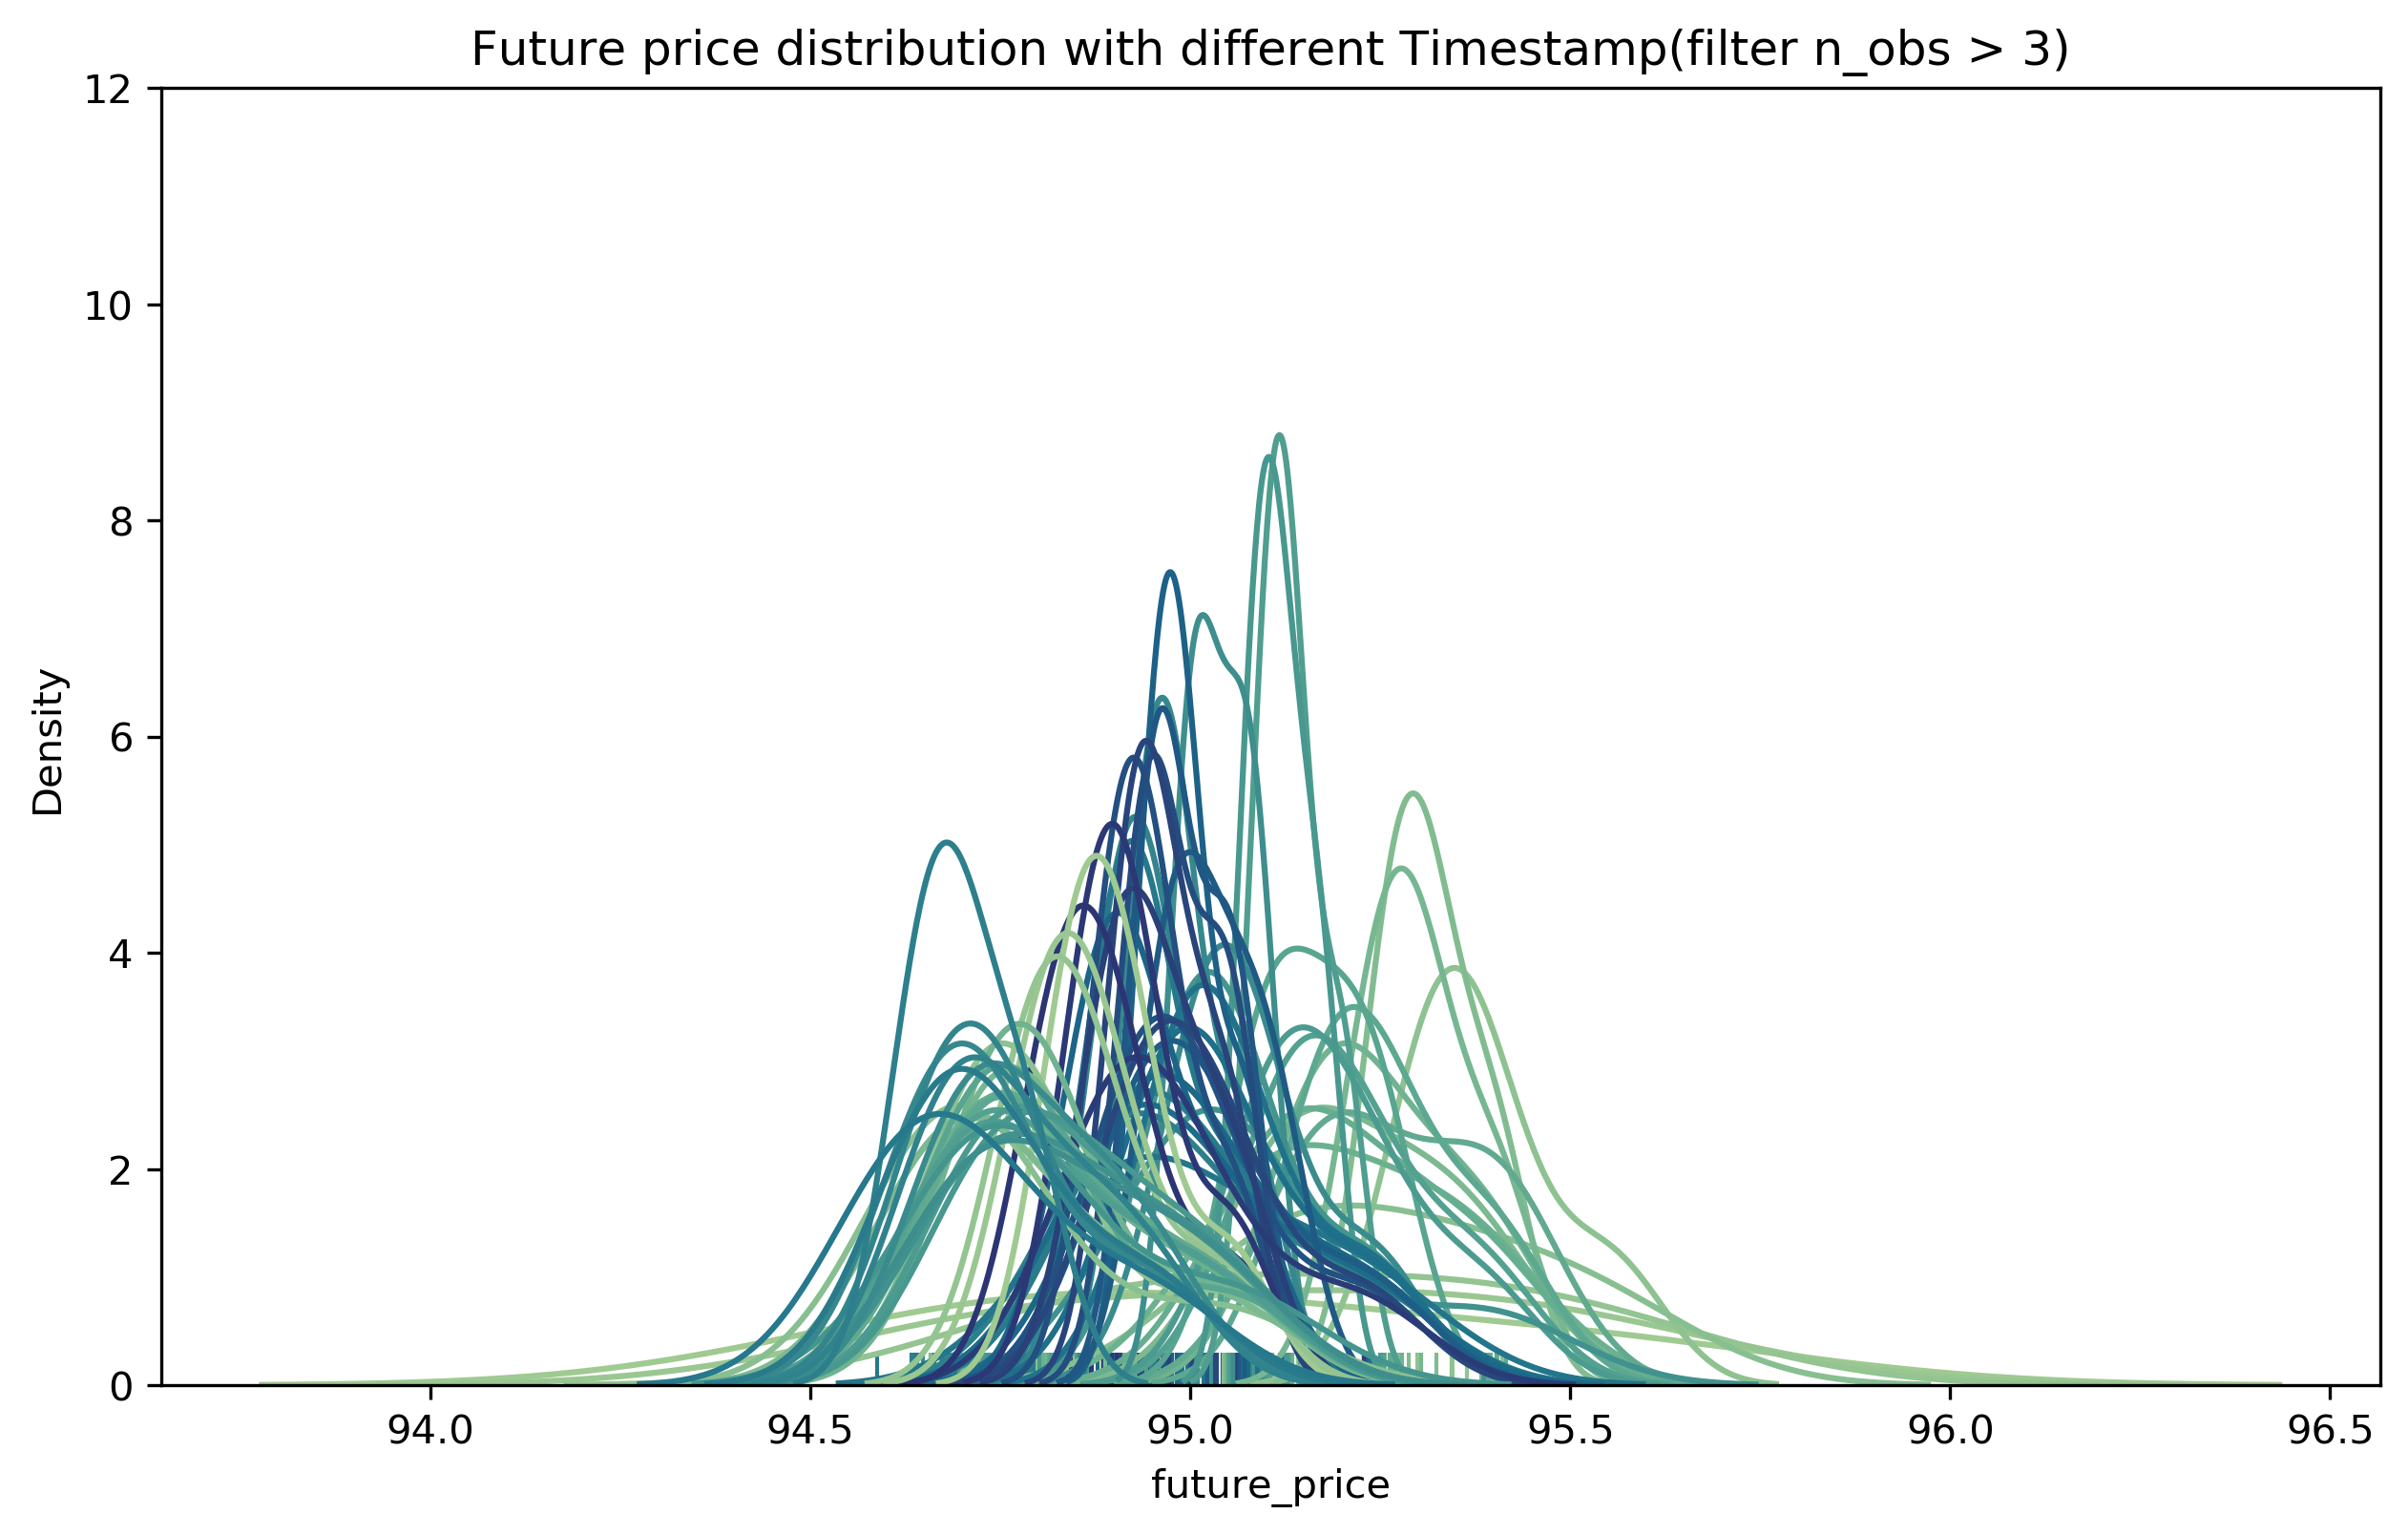

In [83]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

# only related to sofr3 futures
grouped = futures_show.groupby('Timestamp')
plt.figure(dpi=300, figsize=(10, 6))

date_ls = []
N = 47
# diverging_colors = sns.color_palette("RdBu", 47)
sns.set_palette("crest", N)
cmap = plt.get_cmap("crest", N)

for date, group in grouped:
    # print(len(group))
    print(date)
    if len(group) > 3:
        date_ls.append(date)
        sns.distplot(group[['MID_PRICE']], hist=False, rug=True)
# plt.legend(date_ls, )
# norm = mpl.colors.Normalize(vmin=min(date_ls), vmax=max(date_ls))

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# cbar = plt.colorbar(sm, ticks=np.linspace(min(date_ls), max(date_ls), 10))
# # plt.colorbar((date_ls-min(date_ls))/max(date_ls))
# cbar.ax.set_ylabel('date_to_maturity', rotation=270)
plt.ylim((0, 12))
plt.xlabel('future_price')
plt.title('Future price distribution with different Timestamp(filter n_obs > 3)')
plt.show()

Text(0, 0.5, 'rolling_volatility')

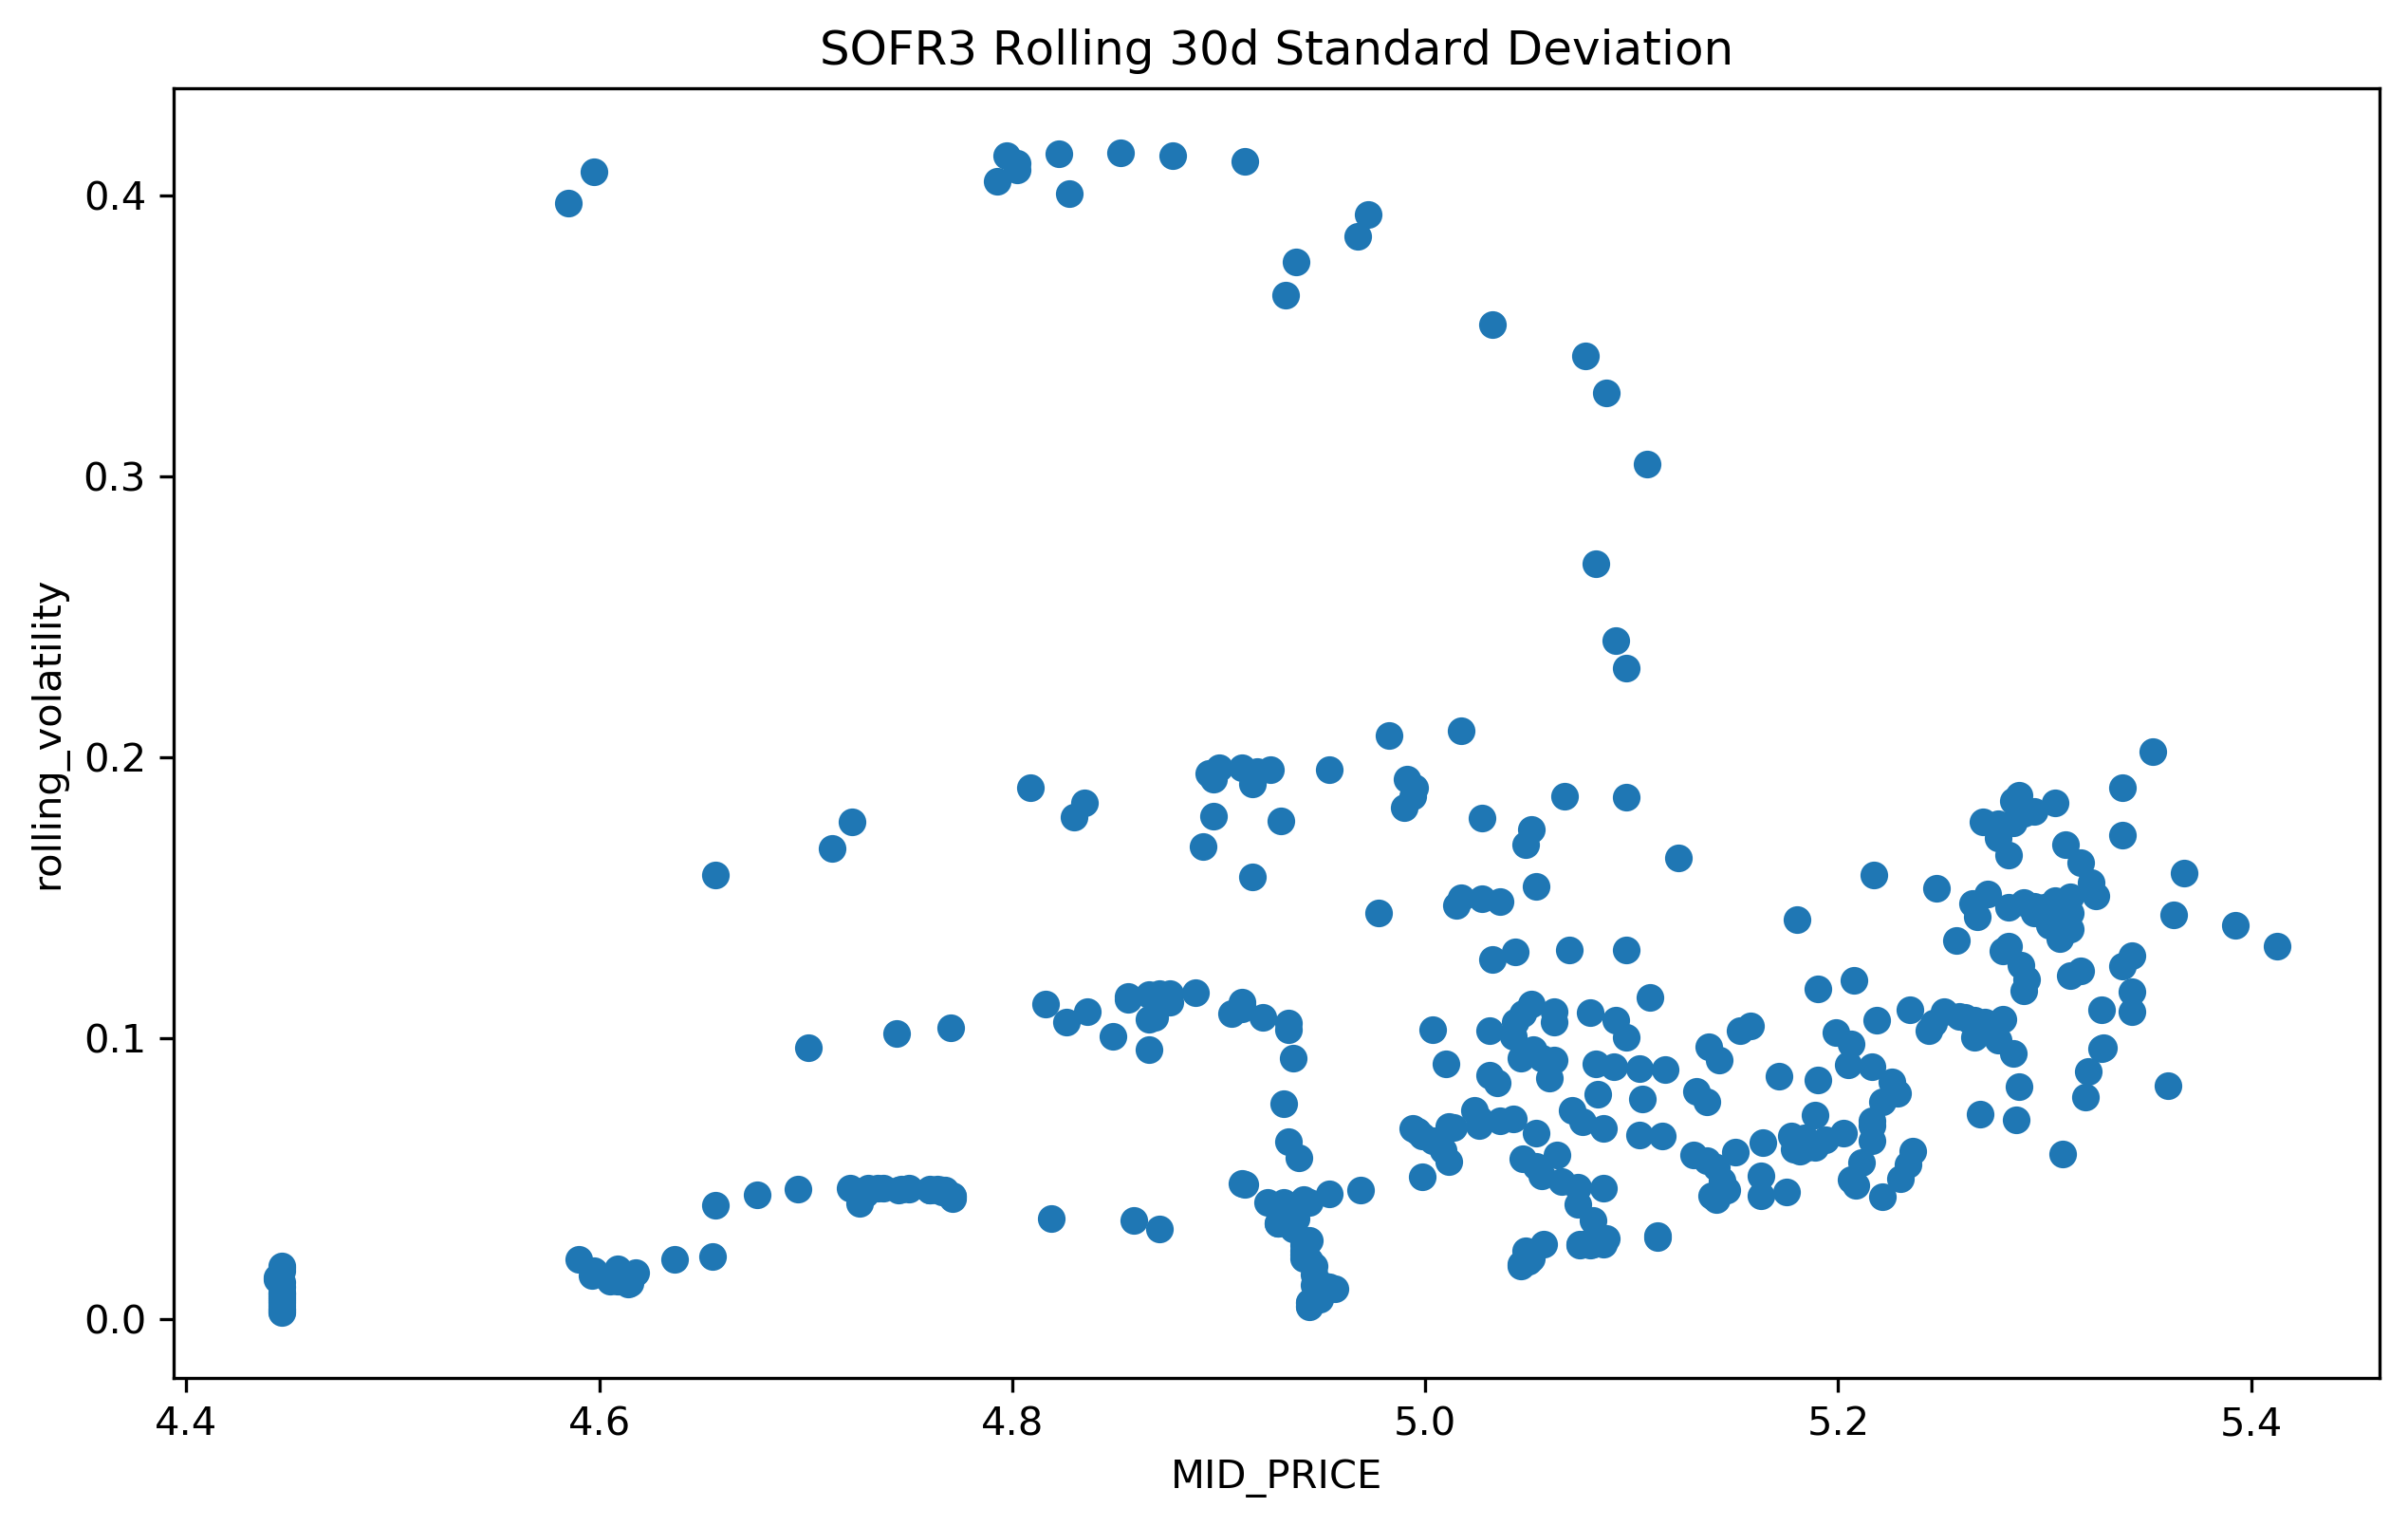

In [173]:
plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(100-futures_show.MID_PRICE, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 30d Standard Deviation')
plt.xlabel('MID_PRICE')
plt.ylabel('rolling_volatility')
# plt.savefig('./fig/rolling_std.png')

In [142]:
futures_show

Timestamp Product     RefDate AssetDescription Expiration  \
1087 2023-02-14 15:00:00   SOFR3  2022-12-21   SR3 2023-03-14 2023-03-14   
1125 2023-02-15 15:00:00   SOFR3  2022-12-21   SR3 2023-03-14 2023-03-14   
1163 2023-02-16 15:00:00   SOFR3  2022-12-21   SR3 2023-03-14 2023-03-14   
1202 2023-02-17 15:00:00   SOFR3  2022-12-21   SR3 2023-03-14 2023-03-14   
1239 2023-02-21 15:00:00   SOFR3  2022-12-21   SR3 2023-03-14 2023-03-14   
...                  ...     ...         ...              ...        ...   
4558 2023-06-23 15:00:00   SOFR3  2023-09-20   SR3 2023-12-19 2023-12-19   
4596 2023-06-26 15:00:00   SOFR3  2023-09-20   SR3 2023-12-19 2023-12-19   
4635 2023-06-27 15:00:00   SOFR3  2023-09-20   SR3 2023-12-19 2023-12-19   
4672 2023-06-28 15:00:00   SOFR3  2023-09-20   SR3 2023-12-19 2023-12-19   
4710 2023-06-29 15:00:00   SOFR3  2023-09-20   SR3 2023-12-19 2023-12-19   

      BIDPRICE0  BIDSIZE0  ASKPRICE0  ASKSIZE0  MID_PRICE  MICRO_PRICE  year  \
1087    95.5525    373977    95.5550    162384   95.55375    95.554243  2023   
1125    95.5525    324420    95.5550     38259   95.55375    95.554736  2023   
1163    95.5525    397422    95.5550     11688   95.55375    95.554929  2023   
1202    95.5550     47521    95.5575    388104   95.55625    95.555273  2023   
1239    95.5550     25617    95.5575    386843   95.55625    95.555155  2023   
...         ...       ...        ...       ...        ...          ...   ...   
4558    94.6600      8161    94.6650      5135   94.66250    94.663069  2023   
4596    94.6600      9349    94.6650      1018   94.66250    94.664509  2023   
4635    94.6300      4313    94.6350      3080   94.63250    94.632917  2023   
4672    94.6350      3869    94.6400       283   94.63750    94.639659  2023   
4710    94.5850      4066    94.5900      3023   94.58750    94.587868  2023   

      month  rolling_vol  date_to_mature  
1087      3     0.019073              27  
1125      3     0.018147              26  
1163      3     0.017160              25  
1202      3     0.015024              24  
1239      3     0.014072              20  
...     ...          ...             ...  
4558     12     0.189080             178  
4596     12     0.172325             175  
4635     12     0.158849             174  
4672     12     0.144010             173  
4710     12     0.132655             172  

[398 rows x 15 columns]

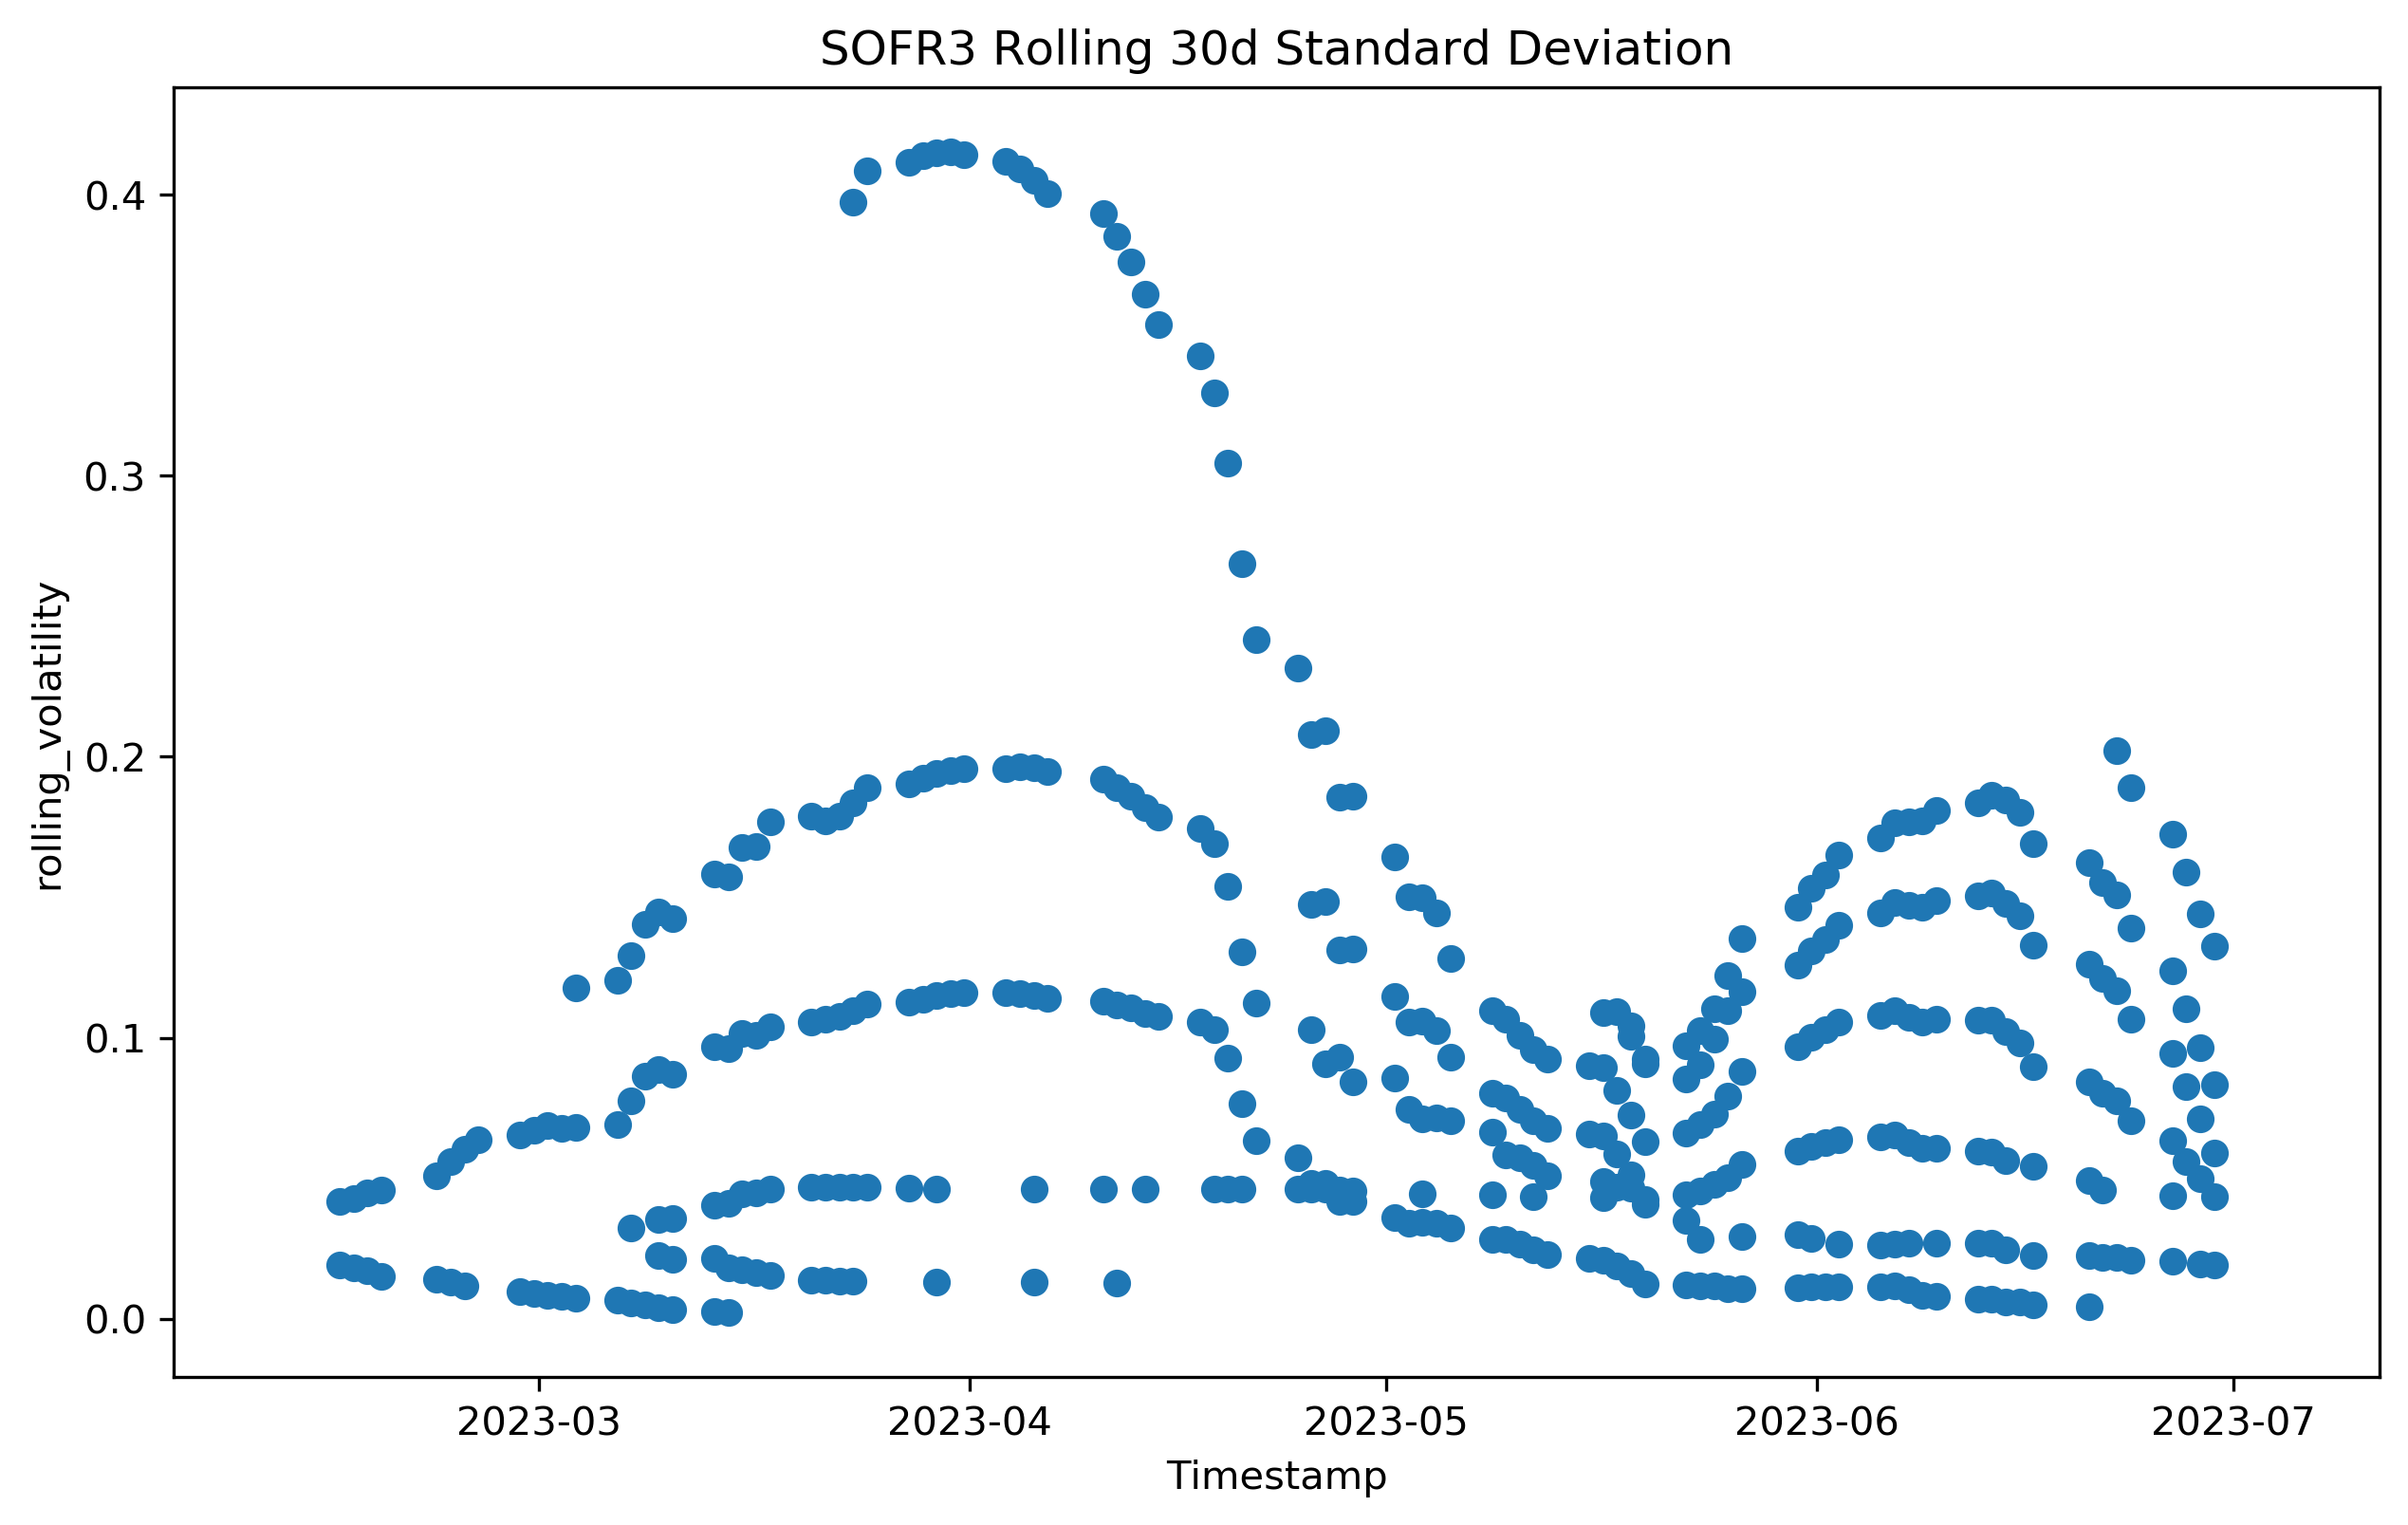

In [147]:
plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(futures_show.Timestamp, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 30d Standard Deviation')
plt.xlabel('Timestamp')
plt.ylabel('rolling_volatility')
plt.savefig('./fig/rolling_std.png')

In [101]:
futures_show[['date_to_mature', 'rolling_vol']].corr()

date_to_mature  rolling_vol
date_to_mature        1.000000     0.757375
rolling_vol           0.757375     1.000000

In [176]:
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]
# X = sm.add_constant(futures_show[['date_to_mature']])
# X = np.sqrt(futures_show[['date_to_mature']])
# X = X.replace(np.nan, 0)
model = sm.OLS(futures_show[['rolling_vol']], futures_show[['date_to_mature']])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            rolling_vol   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              1711.
Date:                Sat, 15 Jul 2023   Prob (F-statistic):                   5.28e-146
Time:                        20:01:23   Log-Likelihood:                          578.78
No. Observations:                 398   AIC:                                     -1156.
Df Residuals:                     397   BIC:                                     -1152.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_to_mature     0.0012   2.82e-05     41.363      0.000       0.001       0.001
==============================================================================
Omnibus:                      181.763   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.666
Skew:                           2.021   Prob(JB):                    6.75e-171
Kurtosis:                       8.561   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [130]:
sum((res.predict() - futures_show['rolling_vol']*252/30)**2)

89.7128843951819

In [110]:
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]
# X = sm.add_constant(futures_show[['date_to_mature']])
X = futures_show[['MID_PRICE']]
model = sm.OLS(futures_show[['rolling_vol']]*252/30, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            rolling_vol   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.568
Method:                 Least Squares   F-statistic:                              523.9
Date:                Sat, 15 Jul 2023   Prob (F-statistic):                    1.54e-74
Time:                        18:24:56   Log-Likelihood:                         -433.05
No. Observations:                 398   AIC:                                      868.1
Df Residuals:                     397   BIC:                                      872.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MID_PRICE      0.0087      0.000     22.889      0.000       0.008       0.009
==============================================================================
Omnibus:                      155.660   Durbin-Watson:                   0.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.610
Skew:                           1.832   Prob(JB):                    6.52e-108
Kurtosis:                       7.042   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:

def sigma(x, data):
    a, b, c = x
    sig = a*data.date_to_mature**2 + b*data.date_to_mature + c
    # sig = a*(data.date_to_mature-b)**2      #  + c*(100-data.MID_PRICE)
    return sum((sig-data.rolling_vol)**2)

data = futures_show[['rolling_vol', 'date_to_mature', 'MID_PRICE']].copy()
data['rolling_vol'] = data['rolling_vol']
# sigma(data, 0.1, 0.1)
x = minimize(sigma, [0.0, 0.0, 0.0], data).x
np.sqrt(sigma(x, data)/len(data))

0.4544581681798803

In [150]:
x

array([4.87750405e-05, 2.55825443e-03, 1.05803400e-01])

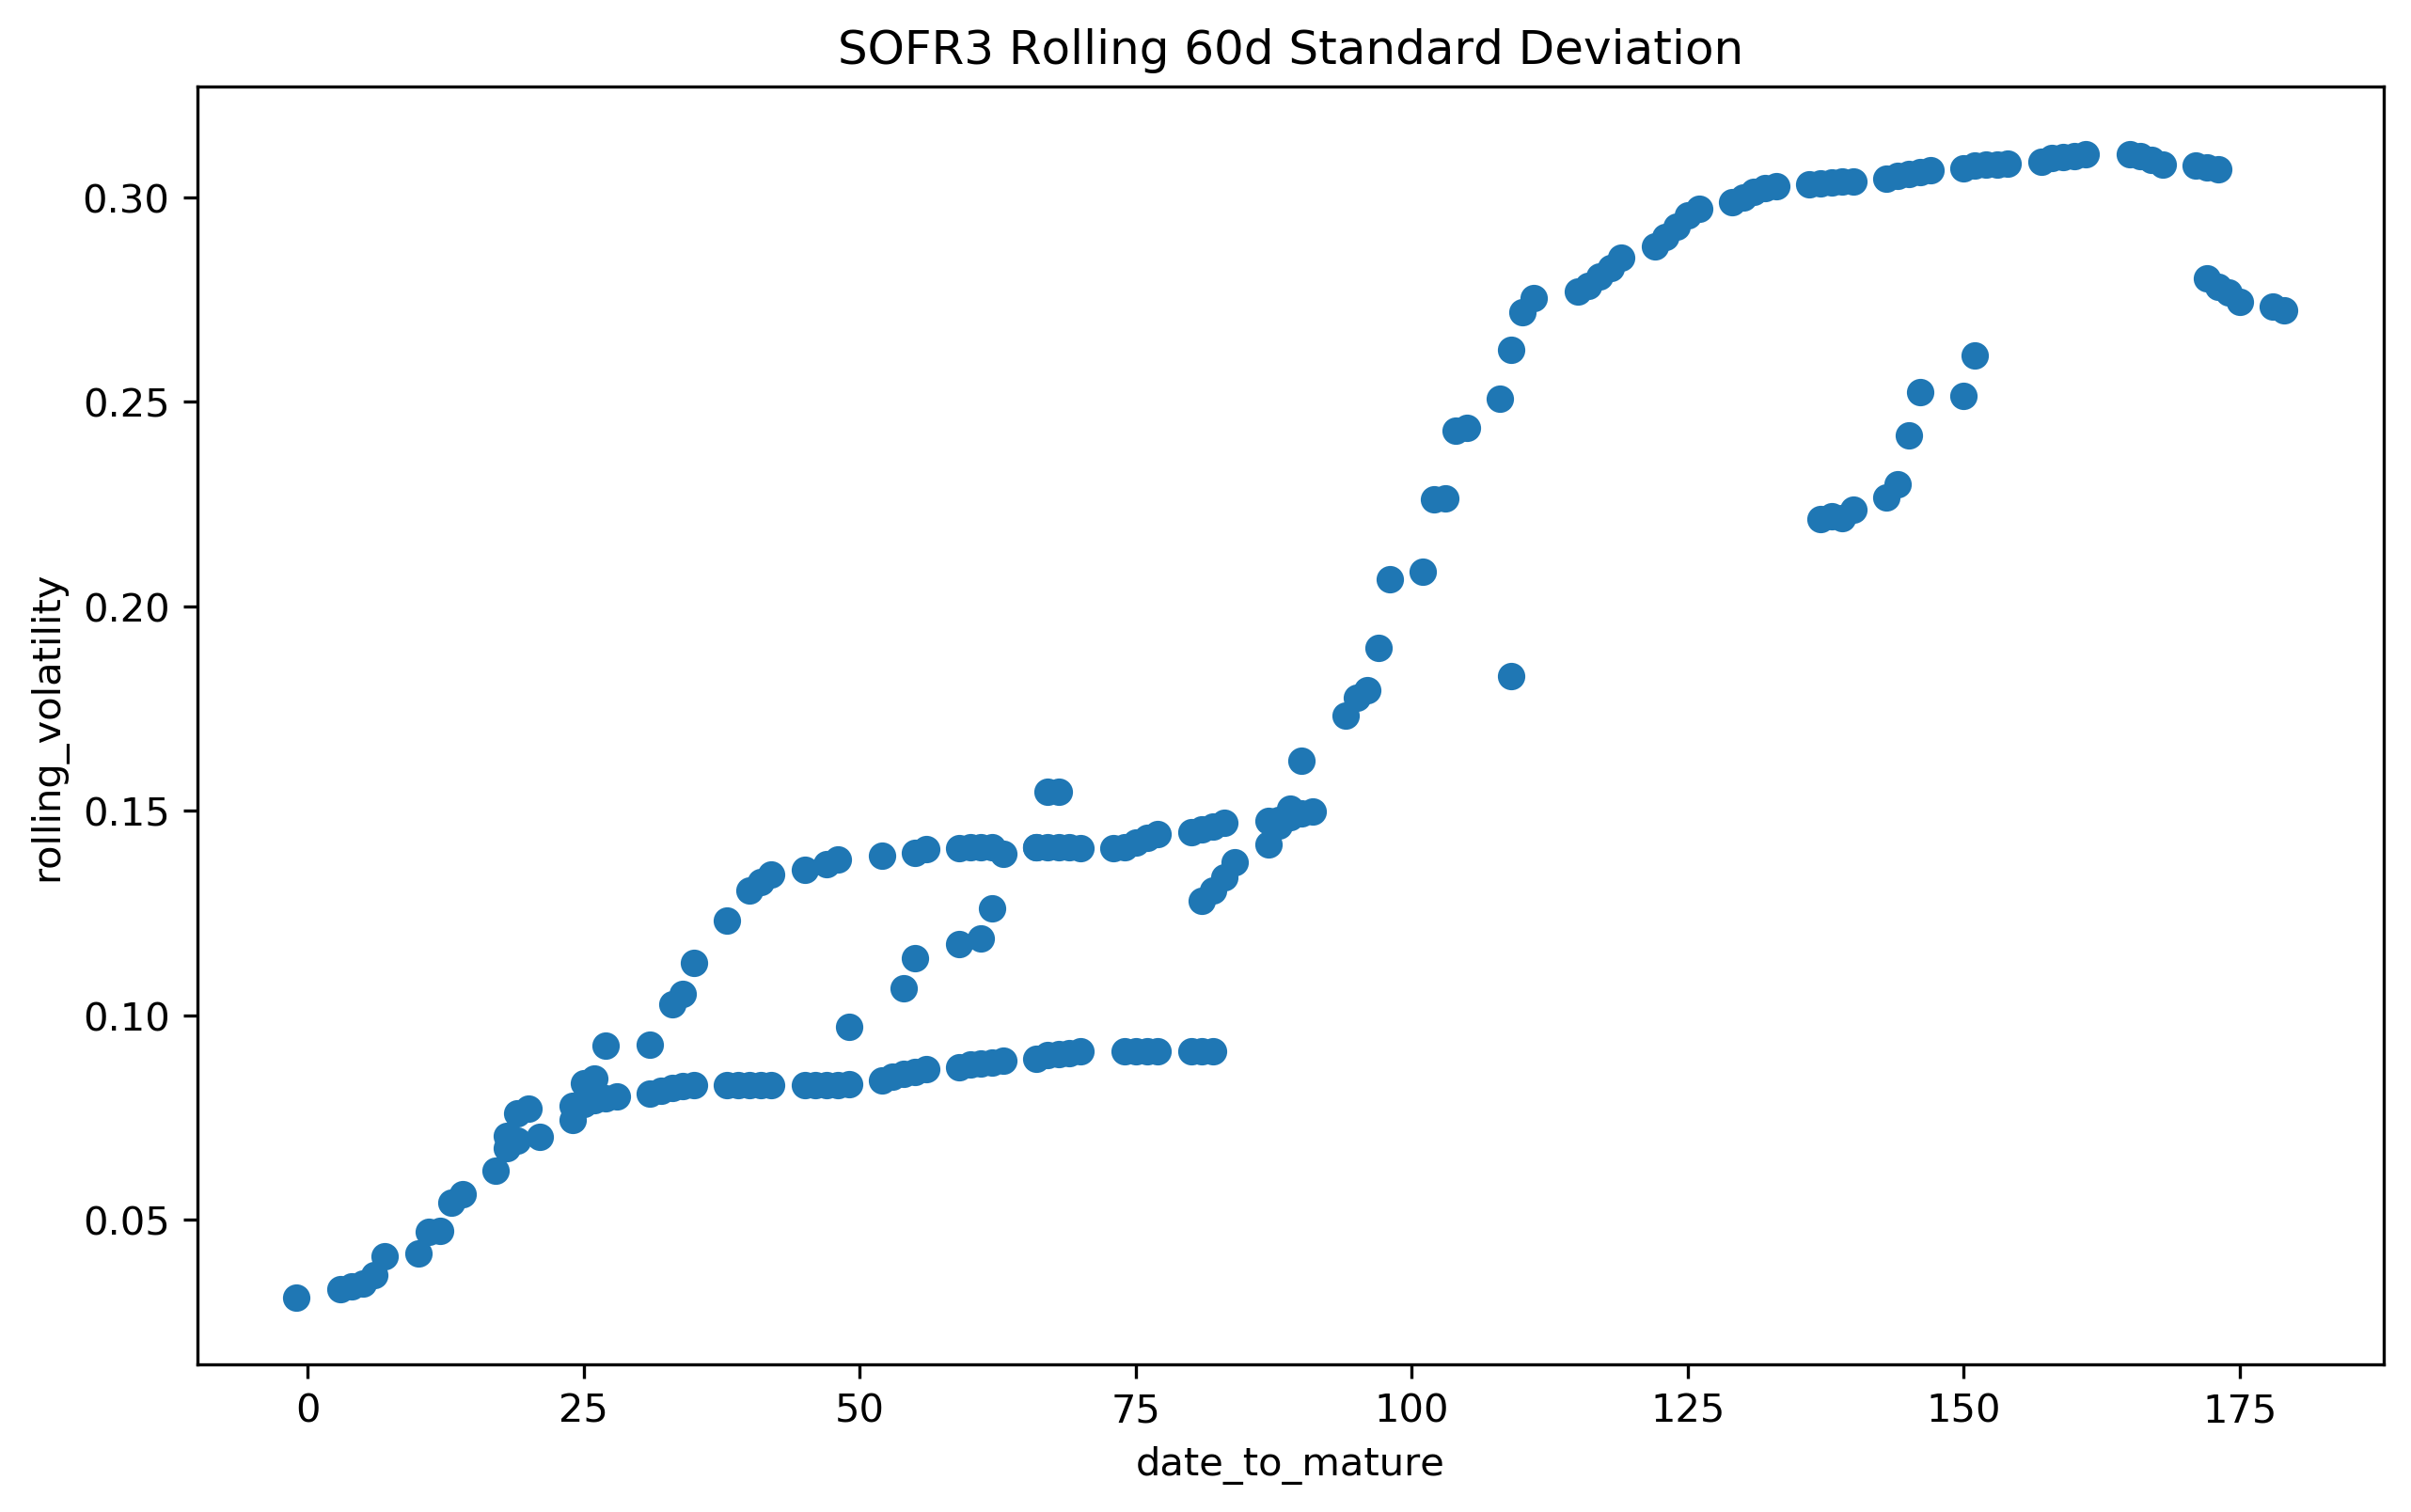

In [157]:
grouped = futures.groupby('AssetDescription')
futures_new = []
for name, product in grouped:
    product['rolling_vol'] = product['MID_PRICE'].rolling(window=60).std()
    futures_new.append(product)
futures_new = pd.concat(futures_new)
futures_new['Expiration'] = pd.to_datetime(futures_new['Expiration'])
futures_new['Timestamp'] = pd.to_datetime(futures_new['Timestamp'])
futures_new['date_to_mature'] = [d.days for d in (futures_new['Expiration'] - futures_new['Timestamp'])]
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]

plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(futures_show.date_to_mature, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 60d Standard Deviation')
plt.xlabel('date_to_mature')
plt.ylabel('rolling_volatility')
plt.savefig('./fig/rolling_std_20.png')

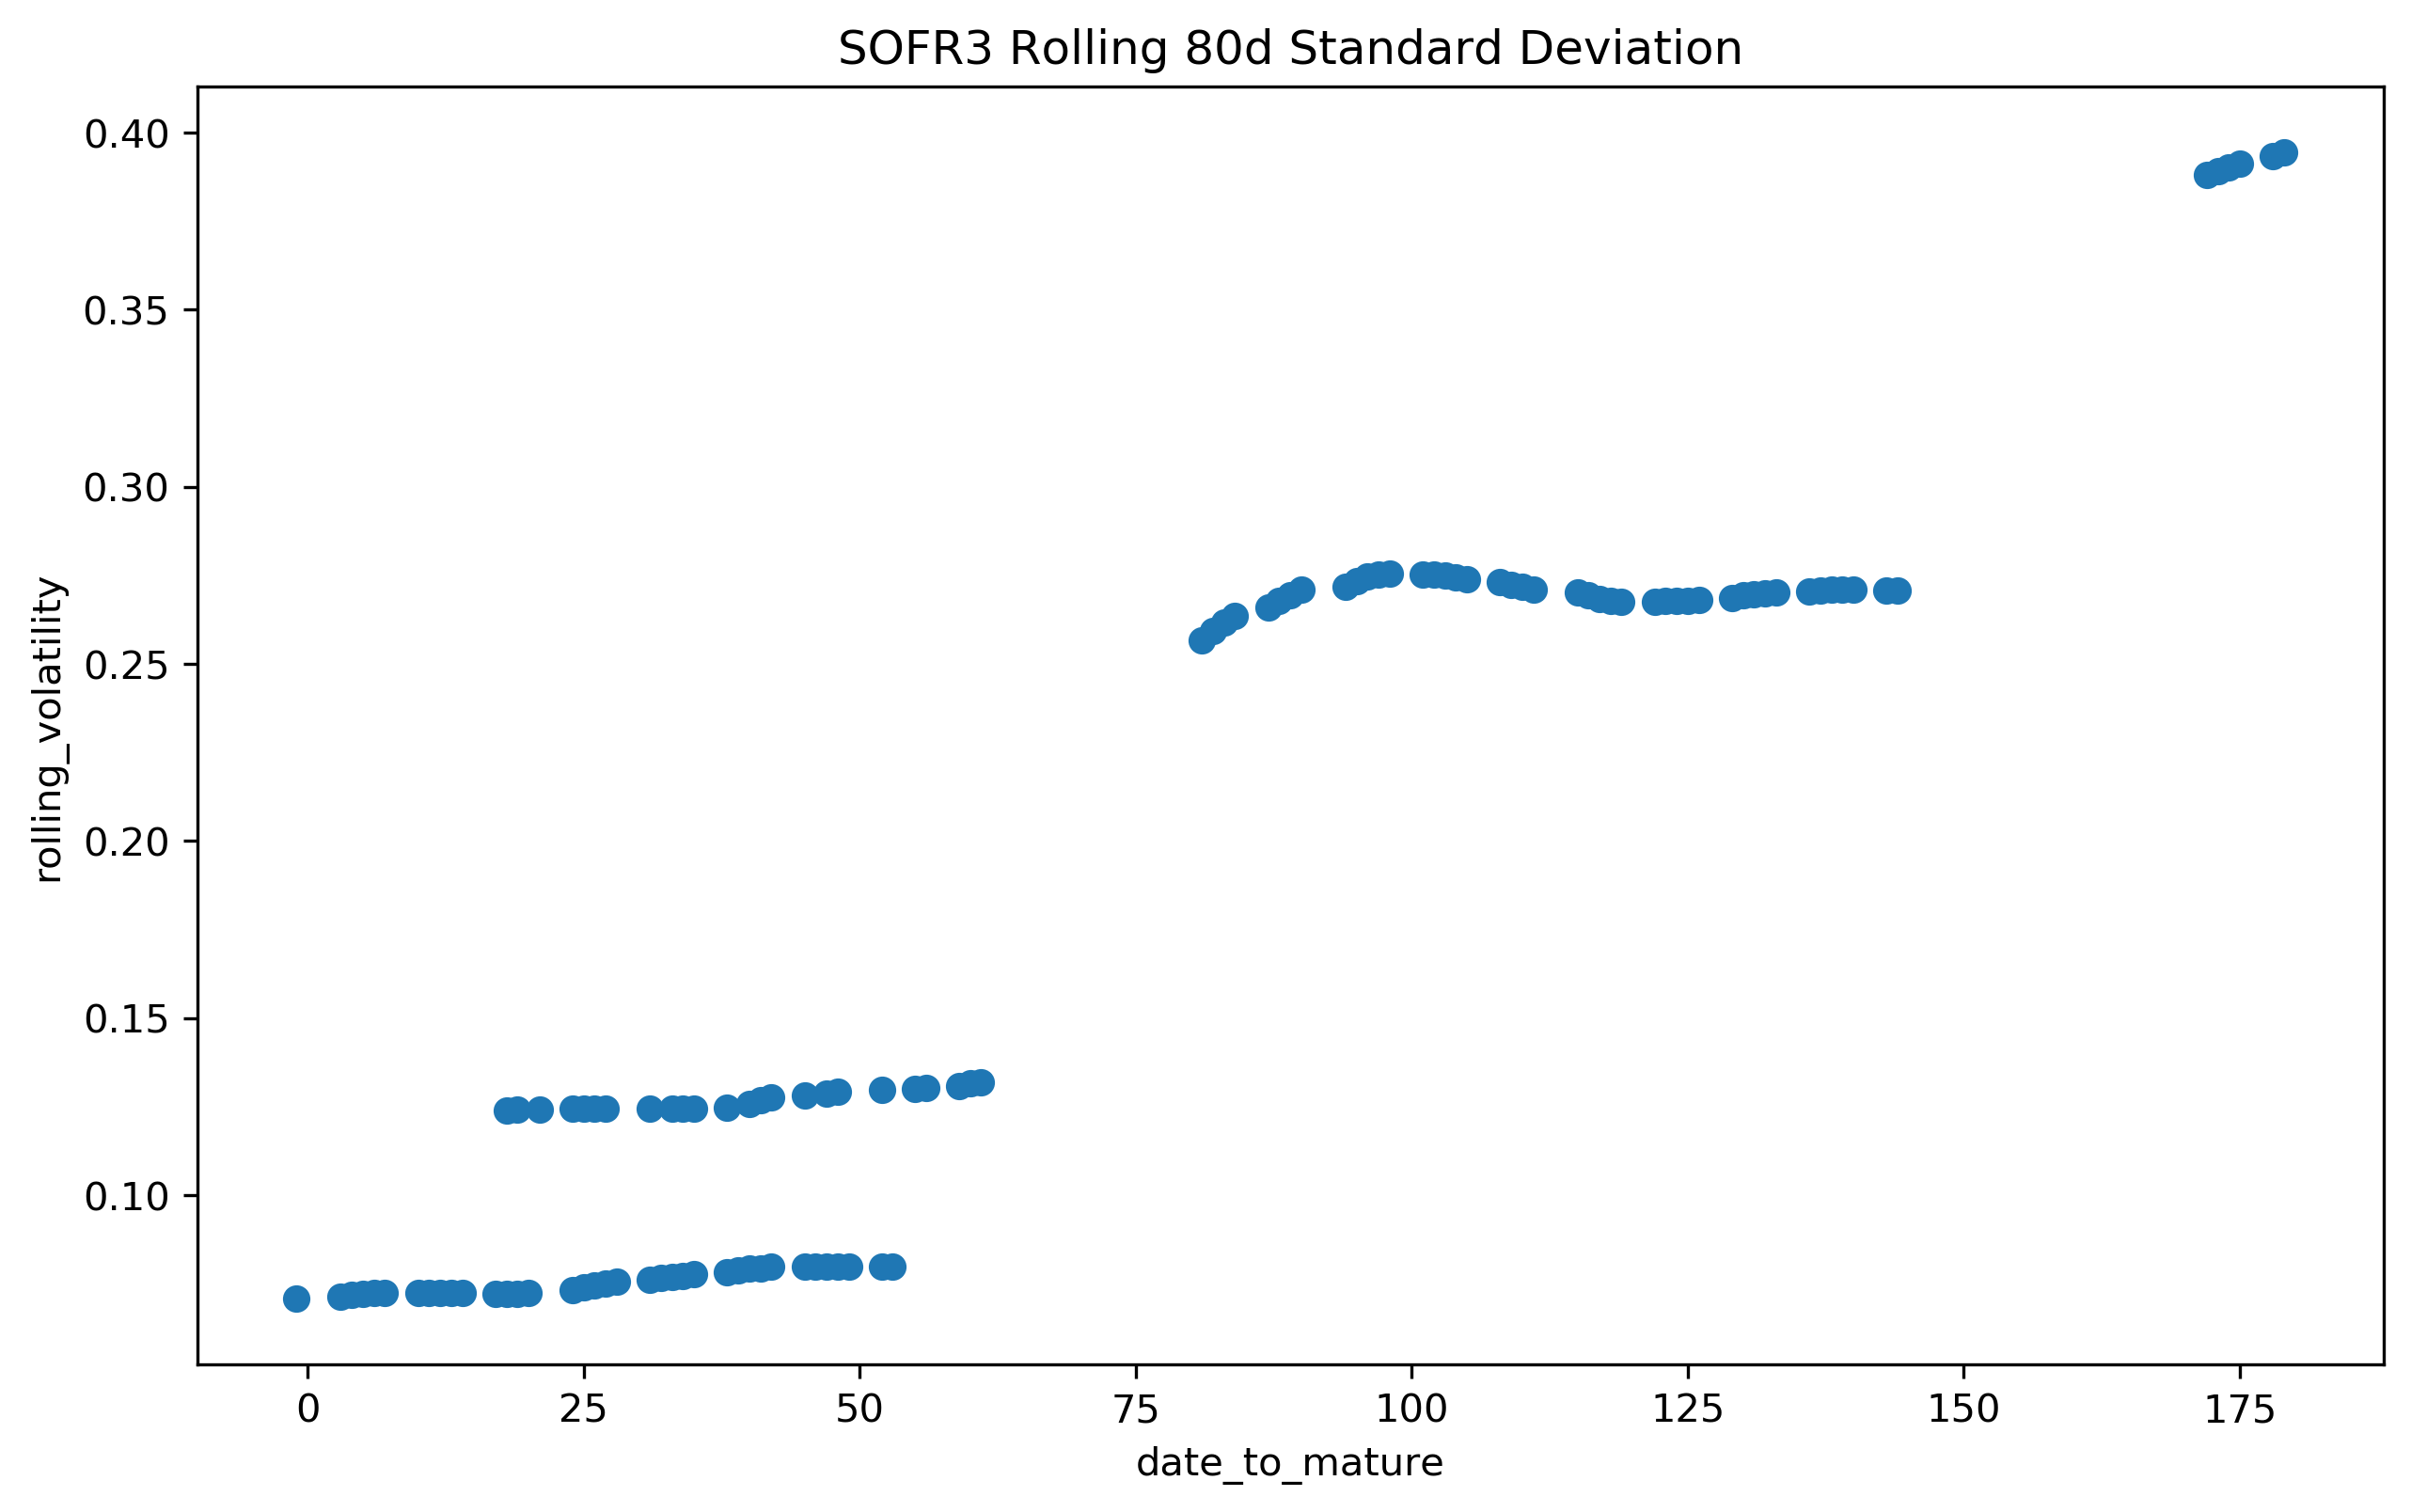

In [156]:
grouped = futures.groupby('AssetDescription')
futures_new = []
for name, product in grouped:
    product['rolling_vol'] = product['MID_PRICE'].rolling(window=80).std()
    futures_new.append(product)
futures_new = pd.concat(futures_new)
futures_new['Expiration'] = pd.to_datetime(futures_new['Expiration'])
futures_new['Timestamp'] = pd.to_datetime(futures_new['Timestamp'])
futures_new['date_to_mature'] = [d.days for d in (futures_new['Expiration'] - futures_new['Timestamp'])]
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]

plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(futures_show.date_to_mature, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 80d Standard Deviation')
plt.xlabel('date_to_mature')
plt.ylabel('rolling_volatility')
plt.savefig('./fig/rolling_std_20.png')

In [ ]:
grouped = futures.groupby('AssetDescription')
futures_new = []
for name, product in grouped:
    product['rolling_vol'] = product['MID_PRICE'].rolling(window=60).std()
    futures_new.append(product)
futures_new = pd.concat(futures_new)
futures_new['Expiration'] = pd.to_datetime(futures_new['Expiration'])
futures_new['Timestamp'] = pd.to_datetime(futures_new['Timestamp'])
futures_new['date_to_mature'] = [d.days for d in (futures_new['Expiration'] - futures_new['Timestamp'])]
futures_show = futures_new[(futures_new['rolling_vol'] < 1) & (futures_new['date_to_mature'] < 180) & (futures_new['Product'] == 'SOFR3')]

plt.figure(dpi=300, figsize=(10, 6))
plt.scatter(futures_show.date_to_mature, futures_show.rolling_vol)
plt.title('SOFR3 Rolling 80d Standard Deviation')
plt.xlabel('date_to_mature')
plt.ylabel('rolling_volatility')
plt.savefig('./fig/rolling_std_20.png')

## Organize the required data

In [13]:
class Future():
    def __init__(self, name, begin, expiration) -> None:
        self.name = name
        self.expiration = expiration
        self.begin = datetime.strptime(begin, "%Y-%m-%d")

    def obs_data(self, obsdate, midprice):
        self.obs_date = obsdate
        self.price = midprice
        self.days = (self.obs_date - self.begin).days

    def cal_(self):
        pass

In [82]:
class Option():
    def __init__(self, name, expiration, type, K) -> None:
        # attri_ls = descrip_str.split(' ')
        self.baseassetname = name  # attri_ls[0]
        if self.baseassetname == 'SR3':
            self.baseassetfullname = 'SOFR3'
            self.contract_days = 91
        else:
            self.baseassetfullname = 'SOFR1'
            self.contract_days = 30
        self.expiration = pd.to_datetime(expiration)  # attri_ls[1]
        self.type = type   # attri_ls[3]
        self.K = K   # attri_ls[4]
        

    def obs_data(self, obsdate, bidprice, askprice):
        self.obsdate = obsdate
        self.datestr = datetime.strftime(self.obsdate, "%Y%m%d")
        self.bidprice = bidprice
        self.askprice = askprice
        self.datetomature = (self.expiration - self.obsdate).days


    def get_future(self, futures_df):
        if self.baseassetname == "SR3":
            self.expir_month = math.ceil(self.expiration.month/3) * 3
            #############################
            #TODO: 

            #############################
        else:
            self.expir_month = self.expiration.month

        baseassetdata = futures_df[(futures_df['Product'] == self.baseassetfullname) & (futures['month'] == self.expir_month) & (futures['year'] == self.expiration.year)].copy()
        baseassetdata = baseassetdata[baseassetdata['Timestamp'] == self.obsdate]
        if len(baseassetdata) == 0:
            date = self.obsdate - timedelta(1)
            baseassetdata = futures_df[(futures_df['Product'] == self.baseassetfullname) & (futures['month'] == self.expir_month) & (futures['year'] == self.expiration.year)].copy()
        baseassetdata = baseassetdata.iloc[0]
        self.baseasset = Future(baseassetdata.Product, baseassetdata.RefDate, 
                                baseassetdata.Expiration)
        self.baseasset.obs_data(baseassetdata.Timestamp, baseassetdata.MID_PRICE)
        return self.baseasset

    def get_discountrate(self, ratedict, method='simple'):
        
        bucketrate = ratedict[self.datestr]
        self.datetomature = (self.expiration - self.obsdate).days
        
        idx = bucketrate[bucketrate['CumLength'] > self.datetomature].index[0]
        rates = bucketrate.iloc[:idx+1, ].copy()
        # ratesls = rates['DailyRate']
        # daysls = rates['BucketLength']
        if len(rates) > 1:
            rates.iloc[-1, 2] = self.datetomature - rates['CumLength'].iloc[-2]
        else:
            rates.iloc[-1, 2] = self.datetomature
        # print(rates)

        # SIMPLE RATE
        if method == 'simple':
            rate = (rates['DailyRate'] * rates['BucketLength']).sum()/self.datetomature
        # COMPOUNDED RATE
        elif method == 'compounded':
            rate = 1
            if len(rates) == 1:
                rate = pow((1+rates['DailyRate'][0])**rates['BucketLength'][0], 1/self.datetomature) - 1
            else:
                for i in range(len(rates)):
                    rate *= (1+rates['DailyRate'][i])**rates['BucketLength'][i]
                rate = pow(rate, 1/self.datetomature) - 1
        # print(self.datetomature)
        return rate
    
    
    def cal_effectiverate(self, index):
        # realized rates: mean value
        self.realizedrate = index[(index['Effective Date'] <= self.obsdate) 
      & (index['Effective Date'] >= self.baseasset.begin)]['SOFR Index'].mean()
        self.todayrate = index[index['Effective Date'] <= self.obsdate].iloc[-1, ]['SOFR Index']
        
        self.realizedrate = (self.realizedrate - 1) * 100
        self.todayrate = (self.todayrate - 1) * 100


        self.effectiverate = ((100-self.baseasset.price) * self.contract_days - self.baseasset.days * self.realizedrate)/(self.contract_days-self.baseasset.days)

        ##### assume future rate == today rate in all the contract days. 
        self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days
        return self.todayrate, self.realizedrate, self.effectiverate    # , self.effectiverate
    

    # def cal_FT(self, noFOMC=False):
    #     if noFOMC:
    #         self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days
        

    def get_ratedistribution(self, feddict):
        
        self.fedrateexp = feddict[self.datestr].copy()

        # need to use future contract expiration date to define the interval
        self.fedrateexp = self.fedrateexp[self.fedrateexp['Date'] <= self.baseasset.expiration]
        self.ft = (self.realizedrate * self.baseasset.days + self.todayrate * (self.contract_days - self.baseasset.days)) / self.contract_days

        self.probs = [1]
        self.ratechanges = [0]
        if len(self.fedrateexp) > 0:
            row = self.fedrateexp.iloc[-1]
            rateprob = row[(row != 0)]
            del rateprob['Date']
            self.probs = list(rateprob.values)
            self.ratechanges = [float(rc) for rc in rateprob.index.values]
        return self.probs, self.ratechanges

        
        if len(self.fedrateexp) > 0:
            situationnum = 0
            probs = [1]
            ratechanges = [0]
            exp_date = self.baseasset.expiration
            today = self.obsdate
            exprate = []
            days_intr = []
            for idx, row in self.fedrateexp.iterrows():
                rateprob = row[(row != 0)]
                del rateprob['Date']
                # FOMCdict[row['Date']] = rateprob
                prob = rateprob.values  
                probs = [i * j for i in probs for j in prob]
                # print(probs)
                ratechange = rateprob.index.values
                
                days_intr.append((exp_date - row['Date']).days)  # today
                today = row['Date']
                
                ## calculating the date length
                ## adjust rate change values
                ratechanges = [i + days_intr[-1]/self.contract_days*float(j) for i in ratechanges for j in ratechange]
                # print(ratechanges)
                exprate.append(sum([i*j for i in probs for j in ratechanges]))

            days_intr.append((self.baseasset.expiration - today).days)
            self.ratechanges = ratechanges; self.probs = probs;
            return probs, ratechanges
        else:
            print('no meeting.')
            self.probs = [1]
            self.ratechanges = [0]
            return [1], [0]
        
    def cal_sigma(self, sigma=0.0025, k=0, cal='prop'):
        if cal == 'prop':
            self.sigma = sigma * np.sqrt(252/90 * self.datetomature/30)
        elif cal == 'fixed':
            self.sigma = sigma * np.sqrt(252/90)
        elif cal == 'linear':
            self.sigma = sigma * np.sqrt(252/90) + k * np.sqrt(self.datetomature/30)

        return self.sigma
    
    def cal_payoff(self, sigma=None, method='normal', c=1.79, k=0, cal='prop'):
        
        '''
        assumption: normal distribution
        '''
        fx = np.zeros(100000)
        x = np.linspace(-self.baseasset.price, 100-self.baseasset.price, 100000)
        ST = self.baseasset.price - x
        payoff = [st - self.K if st - self.K> 0 else 0 for st in ST]
        # vol = 0.04
        # if not vol:
        vol = self.cal_sigma(sigma, k=k, cal=cal)
        if method == 'normal':
            for i in range(len(self.ratechanges)):
                fx += self.probs[i]*norm.pdf(x, loc=self.ratechanges[i]*100, scale=vol)
        elif method == 'weibull':
            for i in range(len(self.ratechanges)):
                fx += self.probs[i]*weibull_min.pdf(x, c, loc=self.ratechanges[i]*100, scale=vol)
        payoffexp = sum(payoff*fx*1e-3)
        return payoffexp
        
    
    def cal_price(self, sigma=0.0025, method='normal', c=1.79, k=0, cal='prop'):
        baseasset = self.get_future(futures_df=futures)
        self.cal_effectiverate(index)
        probs, ratechanges = self.get_ratedistribution(FEDRates)
        payoff = self.cal_payoff(sigma, method, c, cal)
        DF = np.exp(-self.get_discountrate(BucketRates)*self.datetomature/252)
        price = payoff * DF
        return price


    

In [24]:
x = np.linspace(-100, 100, 100000)
weibull_min.mean(x, loc=0, scale=1)
weibull_min.pdf(x, c=1.2, loc=1, scale=2).mean()

0.005000013240535605

In [19]:
futures['name'] = 'SR3'
futures.loc[futures['Product'] == 'SOFR1', 'name'] = 'SR1'

In [20]:
futures.head()

Timestamp Product     RefDate AssetDescription Expiration  \
0 2023-01-03 15:00:00   SOFR3  2027-12-15   SR3 2028-03-14 2028-03-14   
1 2023-01-03 15:00:00   SOFR3  2024-03-20   SR3 2024-06-18 2024-06-18   
2 2023-01-03 15:00:00   SOFR3  2026-09-16   SR3 2026-12-15 2026-12-15   
3 2023-01-03 15:00:00   SOFR3  2025-06-18   SR3 2025-09-16 2025-09-16   
4 2023-01-03 15:00:00   SOFR3  2027-03-17   SR3 2027-06-15 2027-06-15   

   BIDPRICE0  BIDSIZE0  ASKPRICE0  ASKSIZE0  MID_PRICE  MICRO_PRICE  year  \
0     96.685       259     96.695       245    96.6900    96.690139  2028   
1     95.880      1511     95.885       245    95.8825    95.884302  2024   
2     96.810      1136     96.820      1153    96.8150    96.814963  2026   
3     96.835      1379     96.840        90    96.8375    96.839694  2025   
4     96.770       141     96.775        50    96.7725    96.773691  2027   

   month name  
0      3  SR3  
1      6  SR3  
2     12  SR3  
3      9  SR3  
4      6  SR3

In [24]:
options_use = options.merge(futures[['Timestamp', 'name', 'MICRO_PRICE']], left_on=['Timestamp', 'BaseAssetName'], 
              right_on=['Timestamp', 'name'], how='left')
options_use = options_use.rename(columns={'MICRO_PRICE_x': 'MICRO_PRICE', 'MICRO_PRICE_y': 'FUTURE_PRICE'})
option_call = options_use[(options_use['BaseAssetName'] == 'SR3') & (options_use['AssetTypeName'] == 'Calls')
                          & (options_use['StrikePrice'] >= options_use['FUTURE_PRICE'])]
option_put = options_use[(options_use['BaseAssetName'] == 'SR3') & (options_use['AssetTypeName'] == 'Puts')
                          & (options_use['StrikePrice'] <= options_use['FUTURE_PRICE'])]
options_all = pd.concat([option_call, option_put], axis=0)

In [28]:
options_all = pd.concat([option_call, option_put], axis=0)
options_all

Timestamp                       AssetDescription  \
11      2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375   
13      2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375   
17      2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375   
22      2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375   
23      2023-01-03 15:00:00  SR3 2023-01-13 00:00:00 Calls 95.4375   
...                     ...                                    ...   
4118321 2023-06-29 15:00:00   SR3 2023-10-13 00:00:00 Puts 93.1875   
4118322 2023-06-29 15:00:00   SR3 2023-10-13 00:00:00 Puts 93.1875   
4118323 2023-06-29 15:00:00   SR3 2023-10-13 00:00:00 Puts 93.1875   
4118324 2023-06-29 15:00:00   SR3 2023-10-13 00:00:00 Puts 93.1875   
4118325 2023-06-29 15:00:00   SR3 2023-10-13 00:00:00 Puts 93.1875   

        BaseAssetName  Expiration  StrikePrice AssetTypeName  BIDPRICE0  \
11                SR3  2023-01-13      95.4375         Calls     0.0025   
13                SR3  2023-01-13      95.4375         Calls     0.0025   
17                SR3  2023-01-13      95.4375         Calls     0.0025   
22                SR3  2023-01-13      95.4375         Calls     0.0025   
23                SR3  2023-01-13      95.4375         Calls     0.0025   
...               ...         ...          ...           ...        ...   
4118321           SR3  2023-10-13      93.1875          Puts     0.0025   
4118322           SR3  2023-10-13      93.1875          Puts     0.0025   
4118323           SR3  2023-10-13      93.1875          Puts     0.0025   
4118324           SR3  2023-10-13      93.1875          Puts     0.0025   
4118325           SR3  2023-10-13      93.1875          Puts     0.0025   

         BIDSIZE0  ASKPRICE0  ASKSIZE0  MID_PRICE  MICRO_PRICE name  \
11            742     0.0075      1713     0.0050     0.004011  SR3   
13            742     0.0075      1713     0.0050     0.004011  SR3   
17            742     0.0075      1713     0.0050     0.004011  SR3   
22            742     0.0075      1713     0.0050     0.004011  SR3   
23            742     0.0075      1713     0.0050     0.004011  SR3   
...           ...        ...       ...        ...          ...  ...   
4118321       866     0.0125       877     0.0075     0.007468  SR3   
4118322       866     0.0125       877     0.0075     0.007468  SR3   
4118323       866     0.0125       877     0.0075     0.007468  SR3   
4118324       866     0.0125       877     0.0075     0.007468  SR3   
4118325       866     0.0125       877     0.0075     0.007468  SR3   

         FUTURE_PRICE  
11          95.037666  
13          95.203300  
17          95.083280  
22          95.321935  
23          95.192500  
...               ...  
4118321     94.952559  
4118322     94.638922  
4118323     94.687788  
4118324     94.560234  
4118325     94.584966  

[1854931 rows x 14 columns]

In [35]:
option_use = option_call[option_call['Expiration'] < '2024-01-01']

In [36]:
grouped = option_use.groupby('Expiration')
len(grouped)

12

In [37]:
option_use.Expiration.drop_duplicates()

11         2023-01-13
481        2023-02-10
1512       2023-03-10
3059       2023-04-14
5051       2023-05-12
6673       2023-06-16
9846       2023-12-15
19681      2023-09-15
293018     2023-07-14
885117     2023-08-11
2337805    2023-10-13
3285808    2023-11-10
Name: Expiration, dtype: object

### 2023-01-13, multi-modal

In [83]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
MSE = 0
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.25, method='weibull', c=1)
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        MSE += (price - row.MID_PRICE)**2
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = MSE/len(estimated)
MSE

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


8.705458032535068e-05

In [71]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
MSE = 0
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.25, method='weibull', c=0.75)
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        MSE += (price - row.MID_PRICE)**2
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = MSE/len(estimated)
MSE

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


0.0013464501746459022

In [88]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
MSE = 0
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.025, method='normal', k=0.01, cal='linear')
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        MSE += (price - row.MID_PRICE)**2
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = MSE/len(estimated)
MSE

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


0.001056022338554152

In [89]:
estimated

BIDPRICE0  ASKPRICE0     ESTIMATED
StrikePrice Timestamp                                              
95.4375     2023-01-03 15:00:00     0.0025     0.0075  1.494142e-19
            2023-01-03 15:00:00     0.0025     0.0075  1.494142e-19
            2023-01-03 15:00:00     0.0025     0.0075  1.494142e-19
            2023-01-03 15:00:00     0.0025     0.0075  1.494142e-19
            2023-01-03 15:00:00     0.0025     0.0075  1.494142e-19
...                                    ...        ...           ...
95.1250     2023-01-10 15:00:00     0.0325     0.0425  9.805899e-02
95.1875     2023-01-11 15:00:00     0.0125     0.0175  5.031682e-02
            2023-01-11 15:00:00     0.0125     0.0175  5.031682e-02
95.1250     2023-01-11 15:00:00     0.0375     0.0450  9.445439e-02
            2023-01-11 15:00:00     0.0375     0.0450  9.445439e-02

[68 rows x 3 columns]

In [80]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
MSE = 0
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.0025, method='prop') # , method='weibull', c=1
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        MSE += (price - row.MID_PRICE)**2
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = MSE/len(estimated)
MSE

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


0.0005606847426470593

In [81]:
estimated

BIDPRICE0  ASKPRICE0  ESTIMATED
StrikePrice Timestamp                                           
95.4375     2023-01-03 15:00:00     0.0025     0.0075        0.0
            2023-01-03 15:00:00     0.0025     0.0075        0.0
            2023-01-03 15:00:00     0.0025     0.0075        0.0
            2023-01-03 15:00:00     0.0025     0.0075        0.0
            2023-01-03 15:00:00     0.0025     0.0075        0.0
...                                    ...        ...        ...
95.1250     2023-01-10 15:00:00     0.0325     0.0425        0.0
95.1875     2023-01-11 15:00:00     0.0125     0.0175        0.0
            2023-01-11 15:00:00     0.0125     0.0175        0.0
95.1250     2023-01-11 15:00:00     0.0375     0.0450        0.0
            2023-01-11 15:00:00     0.0375     0.0450        0.0

[68 rows x 3 columns]

In [ ]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
MSE = 0
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.0025, method='weibull', c=1)
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        MSE += (price - row.MID_PRICE)**2
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = MSE/len(estimated)
MSE

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-09 15:00:00      5.620      5.635   6.933427
2023-01-10 15:00:00      5.615      5.630   7.193944


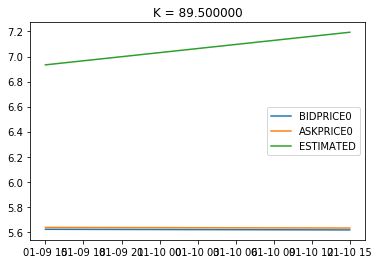

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      4.825      4.840   5.518906
2023-01-05 15:00:00      4.790      4.810   4.346987
2023-01-10 15:00:00      4.865      4.880   6.245934
2023-01-12 15:00:00      4.900      4.925        NaN


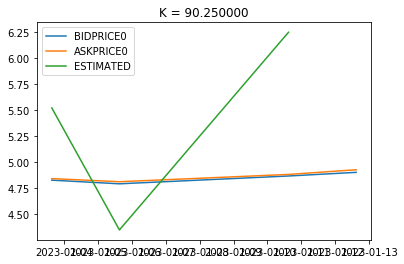

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-06 15:00:00       4.59       4.61   5.402461


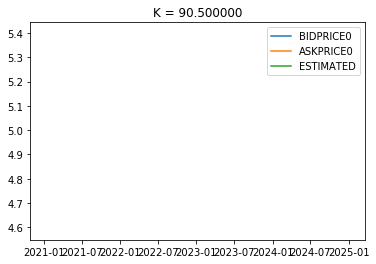

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      4.085      4.105   3.738187
2023-01-06 15:00:00      4.090      4.110   4.825601


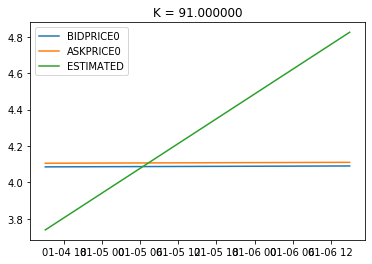

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      3.585      3.605   3.288819
2023-01-09 15:00:00      3.620      3.635   4.499655


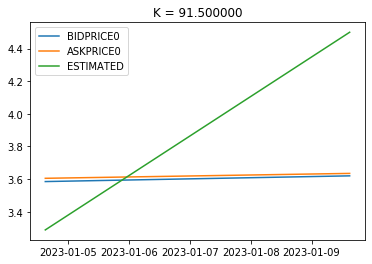

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      3.075      3.090   3.550138
2023-01-05 15:00:00      3.040      3.060   2.786471
2023-01-09 15:00:00      3.120      3.135   3.891212
2023-01-10 15:00:00      3.115      3.130   4.033911
2023-01-12 15:00:00      3.150      3.175        NaN


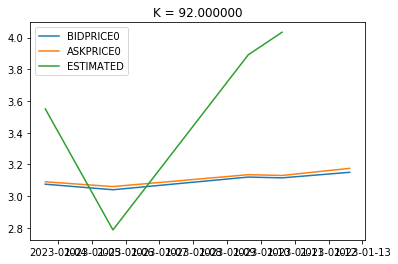

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-10 15:00:00      2.615      2.630   3.401904
2023-01-12 15:00:00      2.650      2.675        NaN


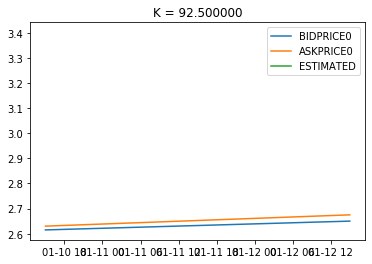

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      2.335      2.355   2.165399
2023-01-05 15:00:00      2.290      2.310   2.117678
2023-01-09 15:00:00      2.370      2.385   2.978547
2023-01-12 15:00:00      2.405      2.420        NaN


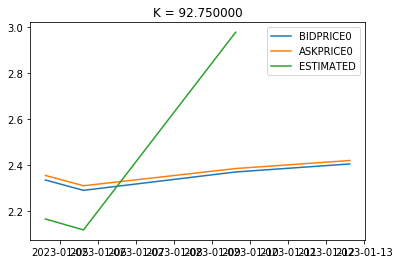

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-05 15:00:00      2.040      2.060   1.894747
2023-01-09 15:00:00      2.120      2.135   2.674326
2023-01-12 15:00:00      2.155      2.170        NaN


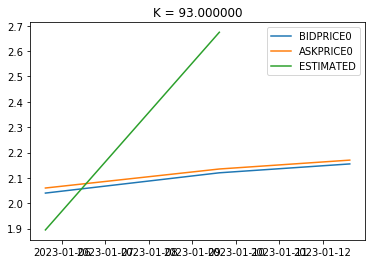

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-05 15:00:00      1.790      1.810   1.671816
2023-01-09 15:00:00      1.870      1.885   2.370104
2023-01-12 15:00:00      1.905      1.920        NaN


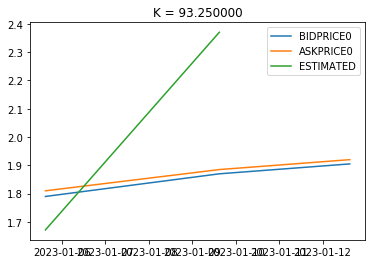

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.710      1.730   1.603689
2023-01-06 15:00:00      1.715      1.735   2.085517


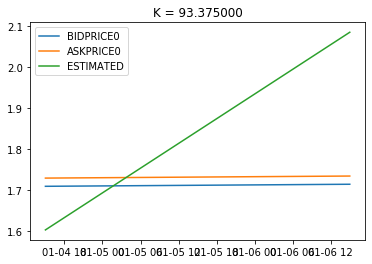

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-05 15:00:00      1.540      1.560   1.448885
2023-01-09 15:00:00      1.620      1.635   2.065883
2023-01-12 15:00:00      1.655      1.670        NaN


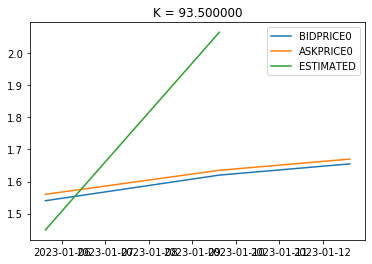

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.525      1.540   1.435176
2023-01-05 15:00:00      1.480      1.495   1.393152
2023-01-09 15:00:00      1.560      1.570   1.989827
2023-01-10 15:00:00      1.550      1.570   2.058890
2023-01-11 15:00:00      1.545      1.565   2.214895
2023-01-12 15:00:00      1.590      1.610        NaN


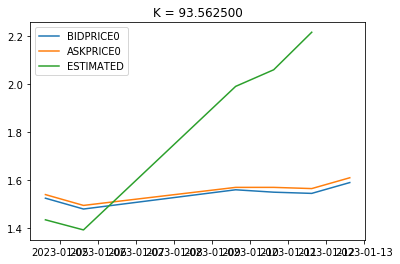

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.460      1.480   1.379005
2023-01-05 15:00:00      1.415      1.435   1.337420
2023-01-09 15:00:00      1.495      1.510   1.913772
2023-01-12 15:00:00      1.530      1.545        NaN


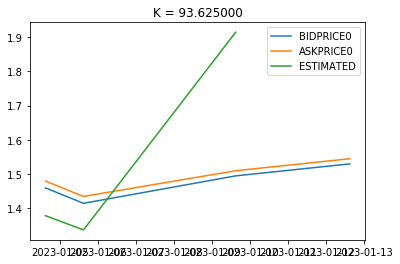

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.400      1.415   1.322834
2023-01-05 15:00:00      1.355      1.370   1.281687
2023-01-10 15:00:00      1.425      1.445   1.900888
2023-01-11 15:00:00      1.425      1.440   2.044248
2023-01-12 15:00:00      1.465      1.485        NaN


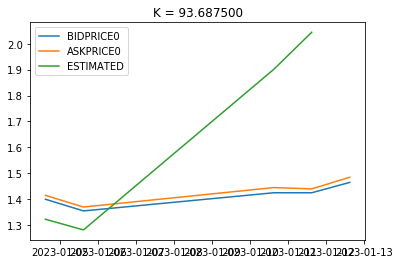

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.335      1.355   1.266663
2023-01-05 15:00:00      1.290      1.310   1.225954
2023-01-09 15:00:00      1.370      1.385   1.761661
2023-01-12 15:00:00      1.405      1.420        NaN


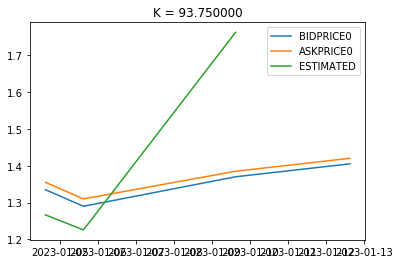

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.275      1.290   1.210492
2023-01-05 15:00:00      1.230      1.245   1.170222
2023-01-09 15:00:00      1.310      1.320   1.685606
2023-01-10 15:00:00      1.300      1.320   1.742886
2023-01-11 15:00:00      1.295      1.315   1.873601
2023-01-12 15:00:00      1.340      1.360        NaN


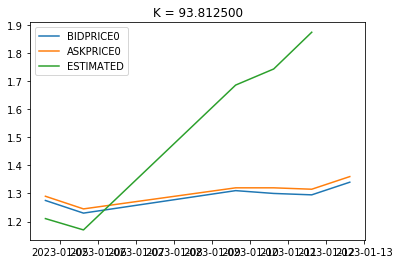

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.210      1.230   1.154321
2023-01-05 15:00:00      1.165      1.185   1.114489
2023-01-12 15:00:00      1.280      1.295        NaN


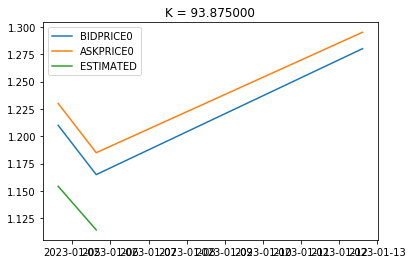

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.150      1.165   1.098150
2023-01-05 15:00:00      1.105      1.120   1.058756
2023-01-10 15:00:00      1.175      1.195   1.584885
2023-01-11 15:00:00      1.170      1.190   1.702954
2023-01-12 15:00:00      1.215      1.235        NaN


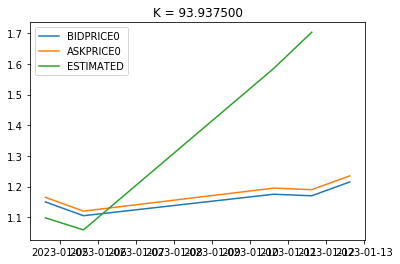

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.085      1.105   1.041979
2023-01-05 15:00:00      1.040      1.060   1.003023
2023-01-12 15:00:00      1.155      1.170        NaN


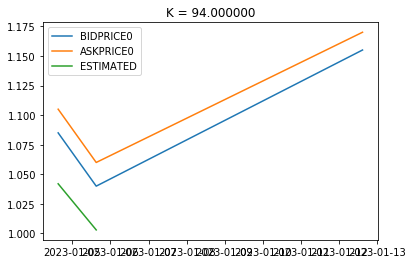

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      1.025      1.040   0.985808
2023-01-05 15:00:00      0.980      0.995   0.947291
2023-01-10 15:00:00      1.050      1.070   1.426883
2023-01-11 15:00:00      1.045      1.065   1.532307
2023-01-12 15:00:00      1.090      1.110        NaN


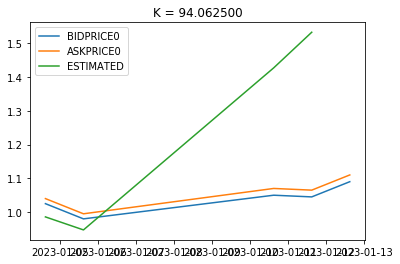

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.960      0.980   0.929637
2023-01-05 15:00:00      0.915      0.935   0.891558
2023-01-12 15:00:00      1.030      1.045        NaN


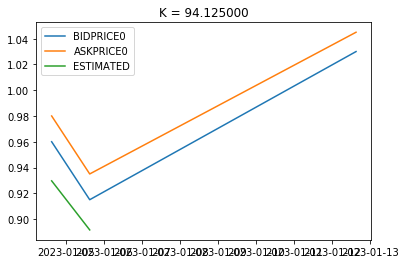

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.900      0.915   0.873466
2023-01-05 15:00:00      0.855      0.870   0.835825
2023-01-10 15:00:00      0.925      0.945   1.268881
2023-01-11 15:00:00      0.920      0.940   1.361660
2023-01-12 15:00:00      0.965      0.985        NaN


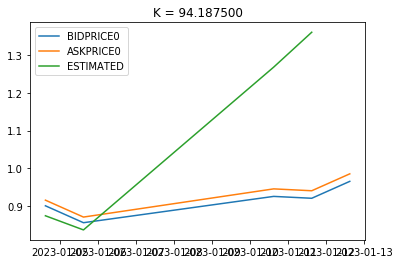

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.835      0.855   0.817295
2023-01-05 15:00:00      0.790      0.810   0.780093
2023-01-12 15:00:00      0.905      0.920        NaN


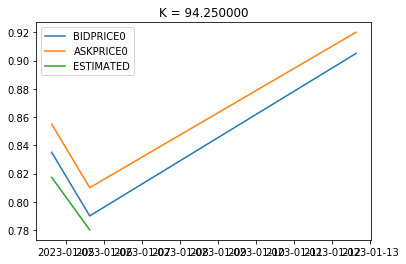

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.775      0.790   0.761124
2023-01-05 15:00:00      0.730      0.745   0.724360
2023-01-10 15:00:00      0.800      0.820   1.110880
2023-01-11 15:00:00      0.795      0.815   1.191013
2023-01-12 15:00:00      0.840      0.860        NaN


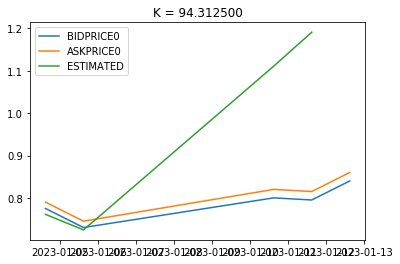

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.710      0.730   0.704953
2023-01-05 15:00:00      0.665      0.685   0.668627
2023-01-12 15:00:00      0.780      0.795        NaN


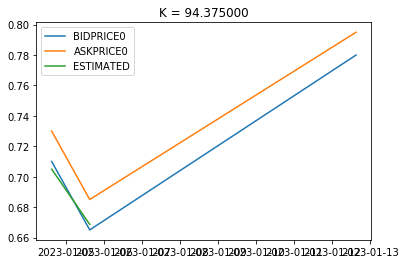

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.650      0.665   0.648782
2023-01-05 15:00:00      0.605      0.620   0.612894
2023-01-10 15:00:00      0.675      0.695   0.952878
2023-01-11 15:00:00      0.670      0.690   1.020365
2023-01-12 15:00:00      0.715      0.735        NaN


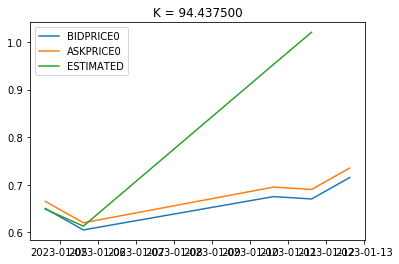

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.585      0.605   0.592611
2023-01-05 15:00:00      0.540      0.560   0.557162
2023-01-09 15:00:00      0.620      0.635   0.848997
2023-01-12 15:00:00      0.655      0.670        NaN


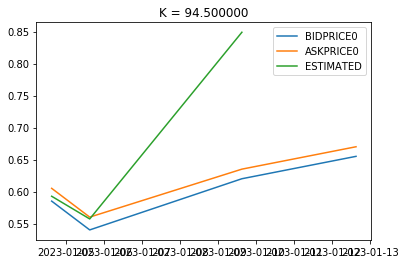

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.525      0.540   0.536440
2023-01-05 15:00:00      0.480      0.495   0.501429
2023-01-09 15:00:00      0.555      0.570   0.772941
2023-01-10 15:00:00      0.550      0.570   0.794876
2023-01-11 15:00:00      0.545      0.565   0.849718
2023-01-12 15:00:00      0.590      0.610        NaN


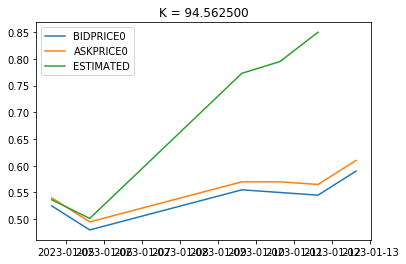

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.460      0.480   0.480269
2023-01-05 15:00:00      0.415      0.435   0.445696
2023-01-09 15:00:00      0.495      0.510   0.696886
2023-01-12 15:00:00      0.530      0.545        NaN


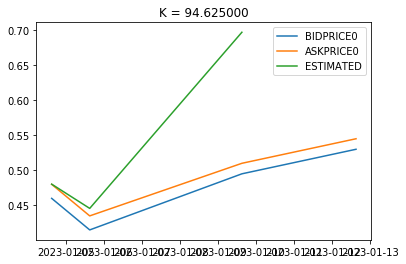

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.400      0.415   0.424098
2023-01-05 15:00:00      0.355      0.370   0.389963
2023-01-09 15:00:00      0.435      0.445   0.620831
2023-01-10 15:00:00      0.425      0.445   0.636875
2023-01-11 15:00:00      0.425      0.440   0.679071
2023-01-12 15:00:00      0.465      0.485        NaN


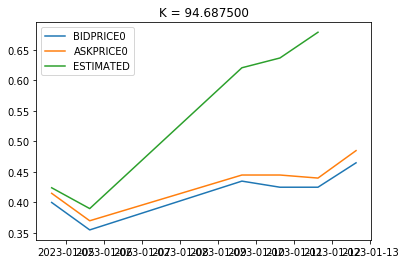

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.340      0.355   0.367927
2023-01-05 15:00:00      0.295      0.310   0.334231
2023-01-06 15:00:00      0.340      0.355   0.499153
2023-01-09 15:00:00      0.370      0.385   0.544775
2023-01-12 15:00:00      0.405      0.420        NaN


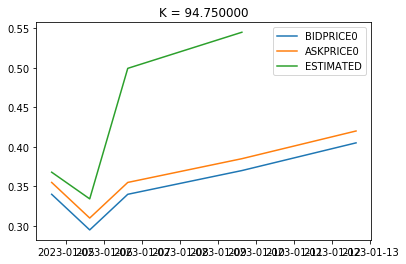

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.265      0.285   0.386047
2023-01-04 15:00:00      0.275      0.290   0.311756
2023-01-05 15:00:00      0.230      0.250   0.278498
2023-01-09 15:00:00      0.310      0.320   0.468720
2023-01-10 15:00:00      0.300      0.320   0.478873
2023-01-11 15:00:00      0.300      0.315   0.508424
2023-01-12 15:00:00      0.340      0.360        NaN


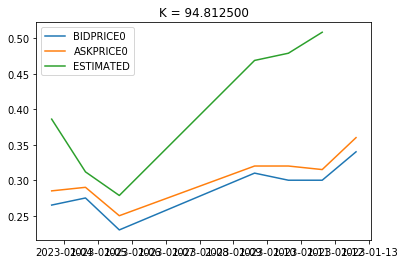

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.215      0.230   0.255585
2023-01-05 15:00:00      0.170      0.190   0.222765
2023-01-12 15:00:00      0.280      0.295        NaN


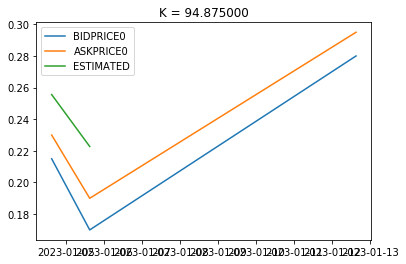

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.160      0.175   0.199414
2023-01-05 15:00:00      0.115      0.135   0.167033
2023-01-09 15:00:00      0.185      0.200   0.316609
2023-01-12 15:00:00      0.215      0.235        NaN


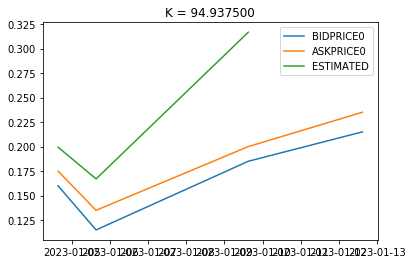

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-04 15:00:00      0.105      0.120   0.143680
2023-01-05 15:00:00      0.070      0.085   0.115788
2023-01-09 15:00:00      0.130      0.140   0.240554
2023-01-10 15:00:00      0.120      0.135   0.241870
2023-01-12 15:00:00      0.155      0.170        NaN


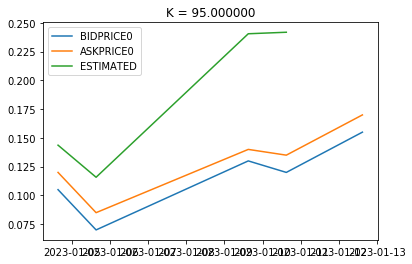

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.060     0.0750   0.131754
2023-01-04 15:00:00      0.060     0.0750   0.107545
2023-01-05 15:00:00      0.035     0.0475   0.085506
2023-01-06 15:00:00      0.055     0.0700   0.157649
2023-01-09 15:00:00      0.075     0.0850   0.180263
2023-01-10 15:00:00      0.070     0.0850   0.181242
2023-01-11 15:00:00      0.070     0.0850   0.188861
2023-01-12 15:00:00      0.095     0.1100        NaN


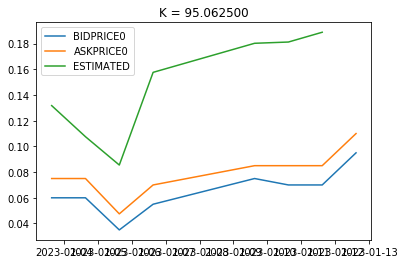

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0325     0.0400   0.087053
2023-01-04 15:00:00     0.0275     0.0400   0.071474
2023-01-05 15:00:00     0.0150     0.0200   0.055225
2023-01-06 15:00:00     0.0225     0.0350   0.107024
2023-01-09 15:00:00     0.0325     0.0425   0.123975
2023-01-10 15:00:00     0.0325     0.0425   0.123267
2023-01-11 15:00:00     0.0375     0.0450   0.128537
2023-01-12 15:00:00     0.0350     0.0475        NaN


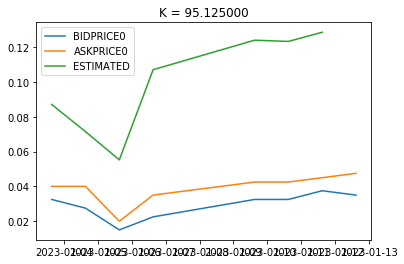

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0150     0.0225   0.042352
2023-01-04 15:00:00     0.0100     0.0200   0.035404
2023-01-05 15:00:00     0.0050     0.0100   0.024943
2023-01-06 15:00:00     0.0050     0.0125   0.056398
2023-01-09 15:00:00     0.0100     0.0175   0.067687
2023-01-10 15:00:00     0.0125     0.0200   0.065291
2023-01-11 15:00:00     0.0125     0.0175   0.068212


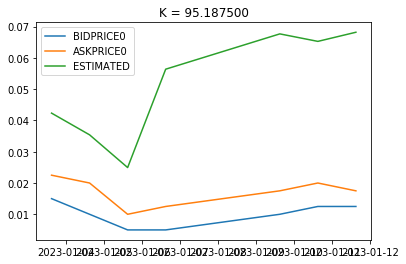

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0075      0.015   0.000000
2023-01-04 15:00:00     0.0050      0.010   0.000116


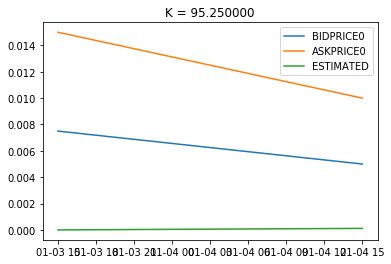

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.005     0.0100        0.0
2023-01-04 15:00:00      0.005     0.0075        0.0


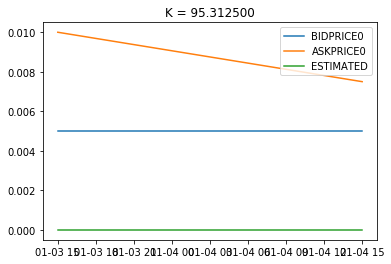

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.005       0.01        0.0


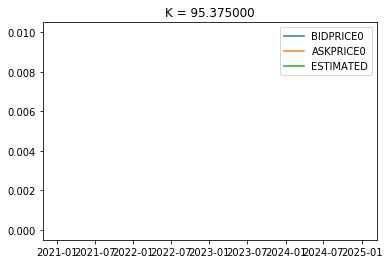

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0025     0.0075        0.0


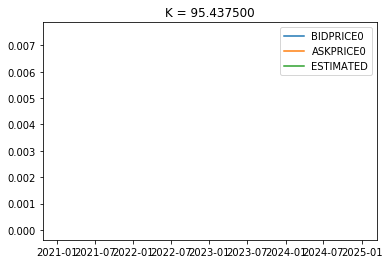

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0025      0.005        0.0


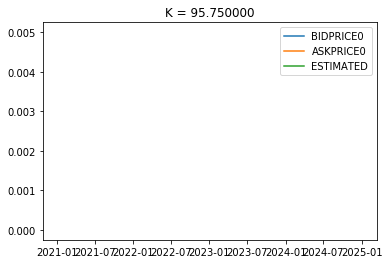

In [40]:
grouped = estimated.groupby('StrikePrice')
for k, g in grouped:
    g = estimated.xs(k)
    print(g)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.title('K = %f' % (k))
    plt.show()

### 2023-01-13, Multi-modal

In [42]:
test = option_use[option_use['Expiration'] == '2023-01-13']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.25)
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        # print(row.BIDPRICE0, price, row.ASKPRICE0)

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-05 15:00:00       0.07      0.085        0.0


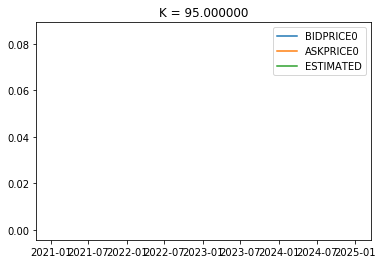

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.060     0.0750        0.0
2023-01-04 15:00:00      0.060     0.0750        0.0
2023-01-05 15:00:00      0.035     0.0475        0.0
2023-01-05 15:00:00      0.035     0.0475        0.0


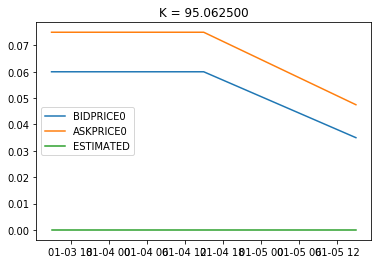

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0325     0.0400        0.0
2023-01-03 15:00:00     0.0325     0.0400        0.0
2023-01-04 15:00:00     0.0275     0.0400        0.0
2023-01-04 15:00:00     0.0275     0.0400        0.0
2023-01-05 15:00:00     0.0150     0.0200        0.0
2023-01-05 15:00:00     0.0150     0.0200        0.0
2023-01-05 15:00:00     0.0150     0.0200        0.0
2023-01-06 15:00:00     0.0225     0.0350        0.0
2023-01-06 15:00:00     0.0225     0.0350        0.0
2023-01-09 15:00:00     0.0325     0.0425        0.0
2023-01-10 15:00:00     0.0325     0.0425        0.0
2023-01-10 15:00:00     0.0325     0.0425        0.0
2023-01-11 15:00:00     0.0375     0.0450        0.0
2023-01-11 15:00:00     0.0375     0.0450        0.0


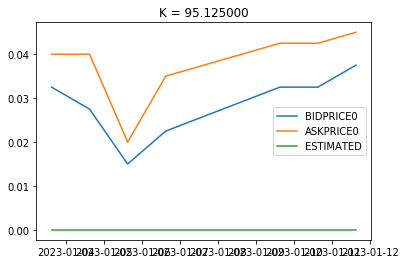

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0150     0.0225        0.0
2023-01-03 15:00:00     0.0150     0.0225        0.0
2023-01-04 15:00:00     0.0100     0.0200        0.0
2023-01-04 15:00:00     0.0100     0.0200        0.0
2023-01-05 15:00:00     0.0050     0.0100        0.0
2023-01-05 15:00:00     0.0050     0.0100        0.0
2023-01-05 15:00:00     0.0050     0.0100        0.0
2023-01-05 15:00:00     0.0050     0.0100        0.0
2023-01-06 15:00:00     0.0050     0.0125        0.0
2023-01-06 15:00:00     0.0050     0.0125        0.0
2023-01-09 15:00:00     0.0100     0.0175        0.0
2023-01-09 15:00:00     0.0100     0.0175        0.0
2023-01-10 15:00:00     0.0125     0.0200        0.0
2023-01-10 15:00:00     0.0125     0.0200        0.0
2023-01-11 15:00:00     0.0125     0.0175        0.0
2023-01-11 15:00:00     0.0125     0.0175        0.0


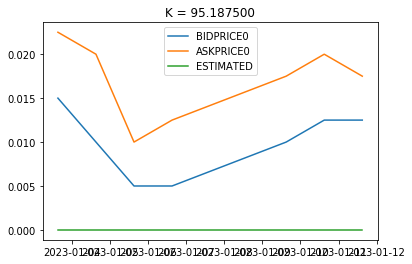

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0075      0.015        0.0
2023-01-03 15:00:00     0.0075      0.015        0.0
2023-01-03 15:00:00     0.0075      0.015        0.0
2023-01-03 15:00:00     0.0075      0.015        0.0
2023-01-04 15:00:00     0.0050      0.010        0.0
2023-01-04 15:00:00     0.0050      0.010        0.0
2023-01-04 15:00:00     0.0050      0.010        0.0
2023-01-04 15:00:00     0.0050      0.010        0.0


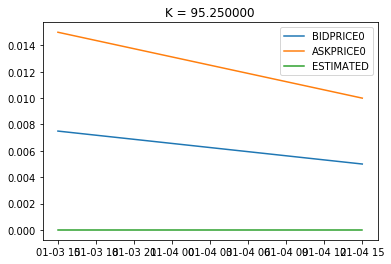

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.005     0.0100        0.0
2023-01-03 15:00:00      0.005     0.0100        0.0
2023-01-03 15:00:00      0.005     0.0100        0.0
2023-01-03 15:00:00      0.005     0.0100        0.0
2023-01-04 15:00:00      0.005     0.0075        0.0
2023-01-04 15:00:00      0.005     0.0075        0.0
2023-01-04 15:00:00      0.005     0.0075        0.0
2023-01-04 15:00:00      0.005     0.0075        0.0


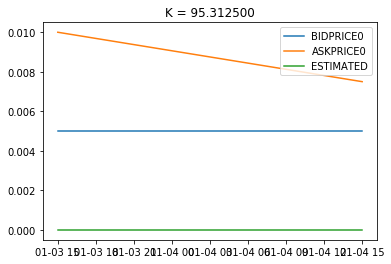

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00      0.005       0.01        0.0
2023-01-03 15:00:00      0.005       0.01        0.0
2023-01-03 15:00:00      0.005       0.01        0.0
2023-01-03 15:00:00      0.005       0.01        0.0
2023-01-03 15:00:00      0.005       0.01        0.0


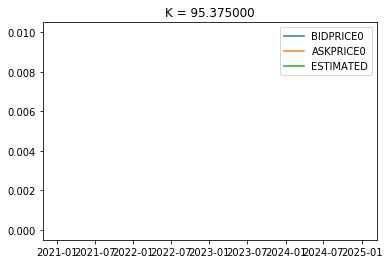

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0025     0.0075        0.0
2023-01-03 15:00:00     0.0025     0.0075        0.0
2023-01-03 15:00:00     0.0025     0.0075        0.0
2023-01-03 15:00:00     0.0025     0.0075        0.0
2023-01-03 15:00:00     0.0025     0.0075        0.0


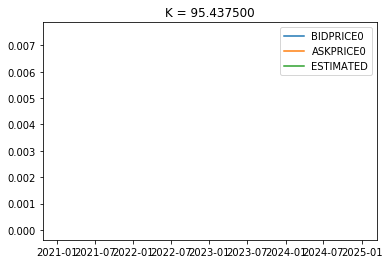

                     BIDPRICE0  ASKPRICE0  ESTIMATED
Timestamp                                           
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0
2023-01-03 15:00:00     0.0025      0.005        0.0


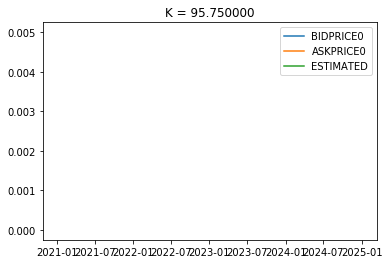

In [78]:
grouped = estimated.groupby('StrikePrice')
for k, g in grouped:
    g = estimated.xs(k)
    print(g)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.title('K = %f' % (k))
    plt.show()

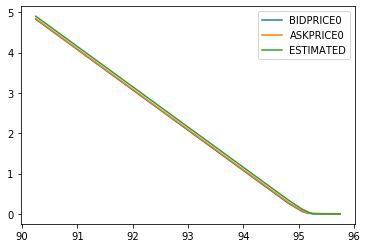

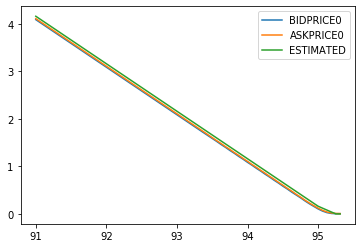

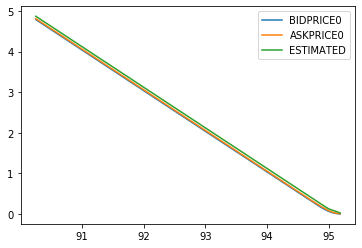

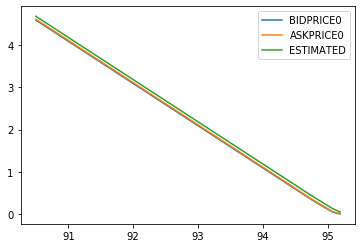

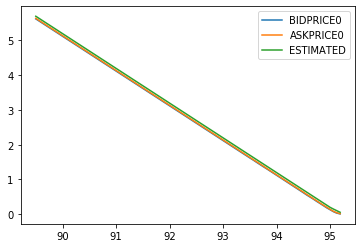

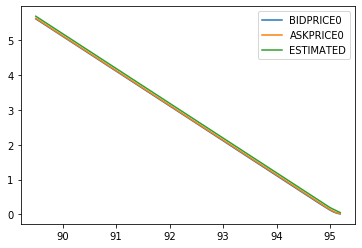

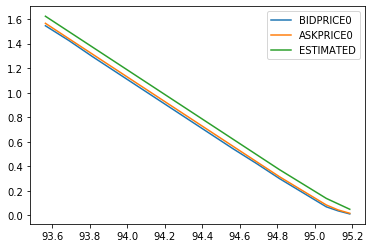

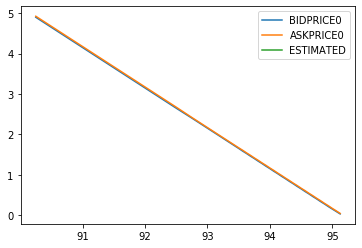

In [43]:
# estimated.loc['2023-01-03 15:00:00']
estimated = estimated.swaplevel()
grouped = estimated.groupby('Timestamp')
for t, g in grouped:
    g = estimated.xs(t)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.show()

### 2023-03-10

In [68]:
test = option_use[option_use['Expiration'] == '2023-03-10']
gg = test.groupby('AssetDescription')
estimated = test[['Timestamp', 'StrikePrice', 'BIDPRICE0', 'ASKPRICE0']]
estimated = estimated.set_index(['StrikePrice', 'Timestamp'])
mse_ls = []
for ts, asset in gg:
    # print(asset.iloc[0])
    myoption = Option(asset.iloc[0].BaseAssetName, asset.iloc[0].Expiration, asset.iloc[0].AssetTypeName, asset.iloc[0].StrikePrice)
    for idx, row in asset.iterrows():
        myoption.obs_data(row.Timestamp, row.BIDPRICE0, row.ASKPRICE0)
        price = myoption.cal_price(0.0025, method='normal', k=0.001, cal='linear')
        estimated.loc[(row.StrikePrice, row.Timestamp), 'ESTIMATED'] = price
        if price is not np.nan:
            mse_ls.append((price - row.MID_PRICE)**2)
        # print(row.BIDPRICE0, price, row.ASKPRICE0)
MSE = np.nanmean(mse_ls)
MSE

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


0.06930587868266534

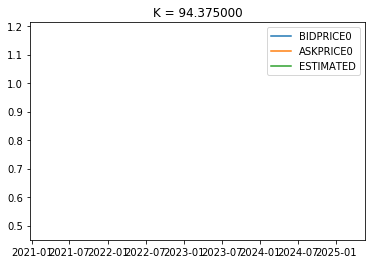

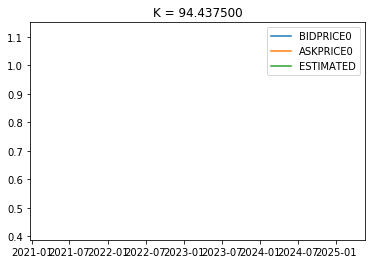

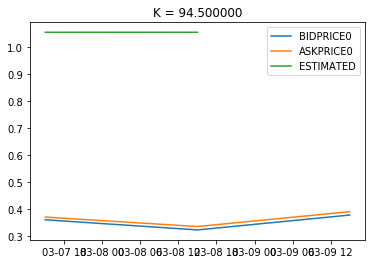

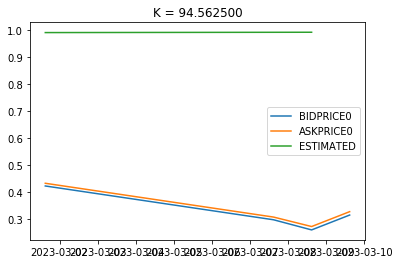

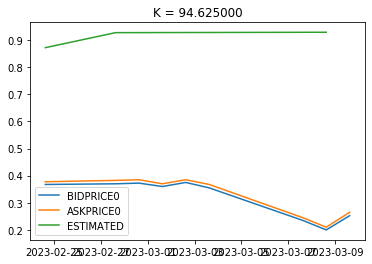

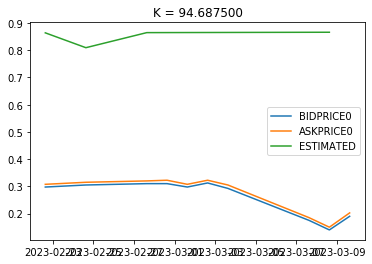

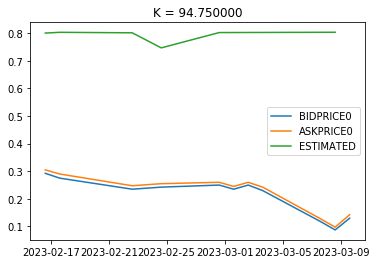

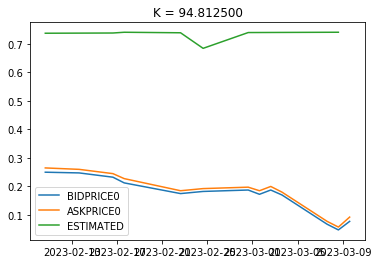

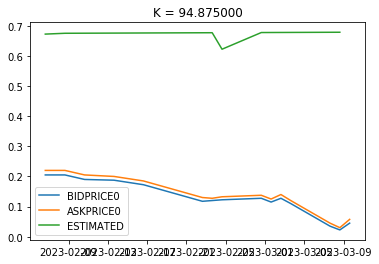

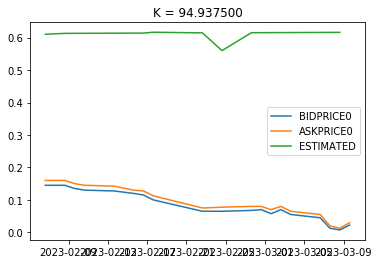

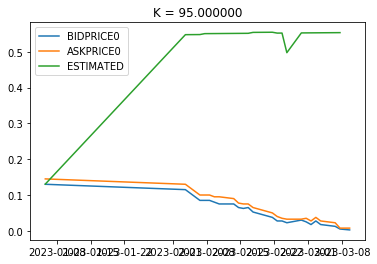

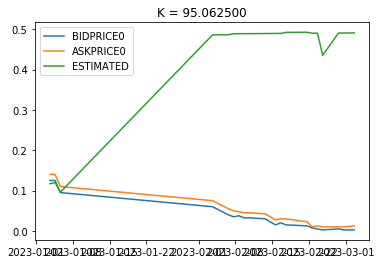

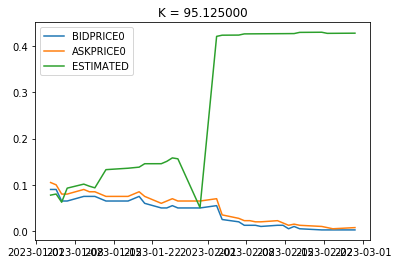

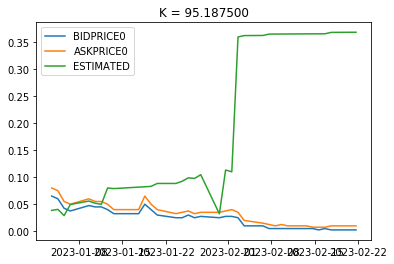

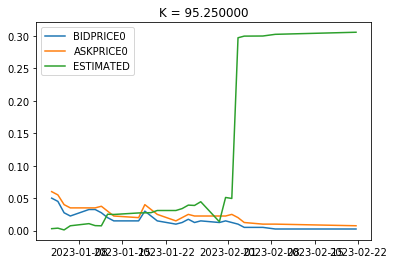

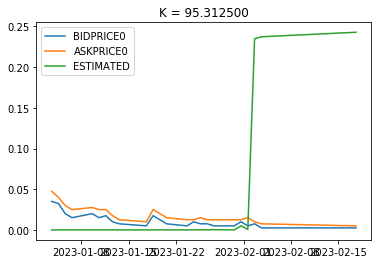

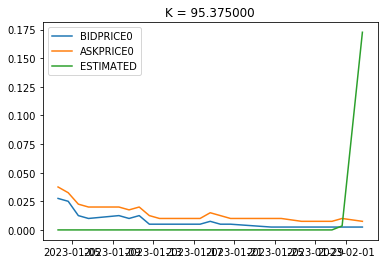

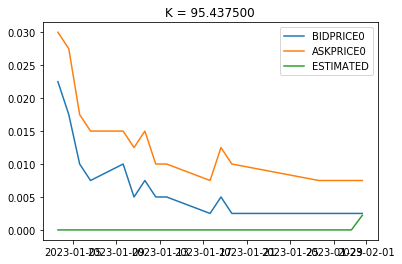

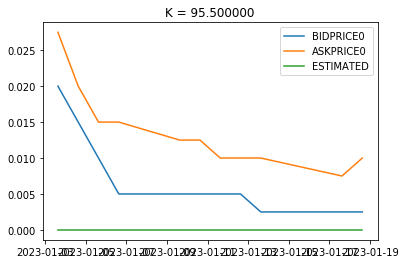

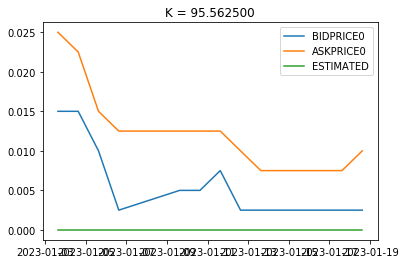

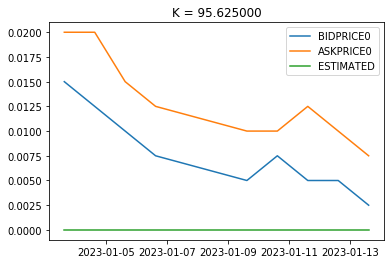

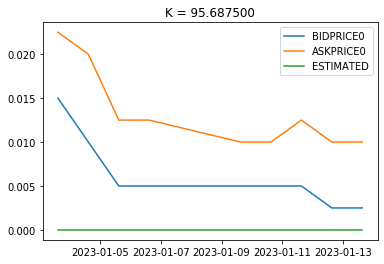

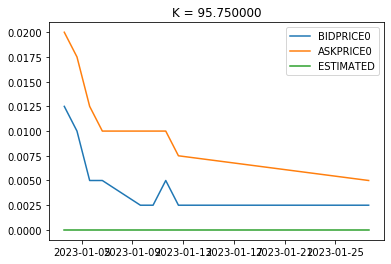

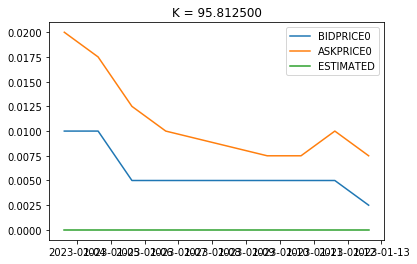

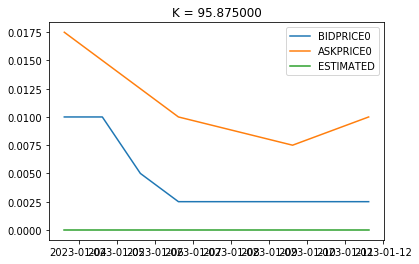

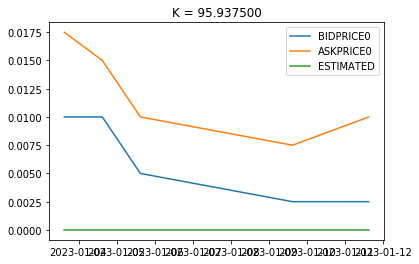

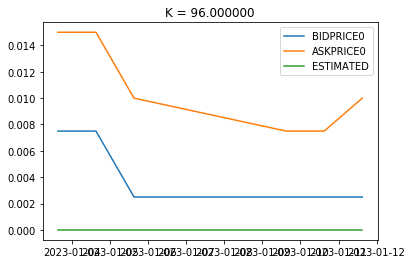

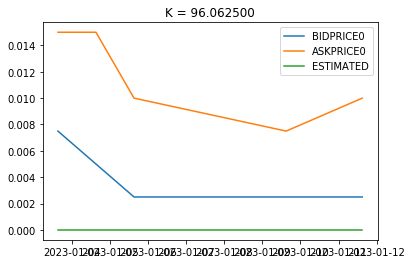

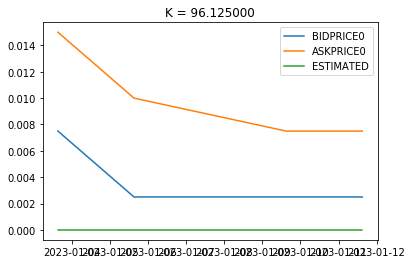

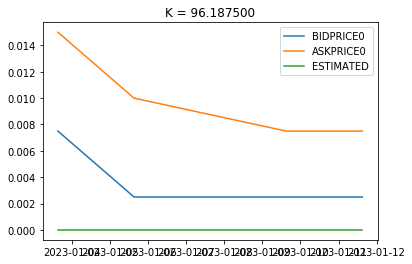

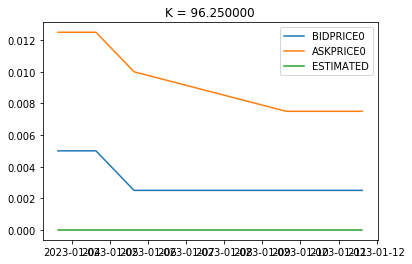

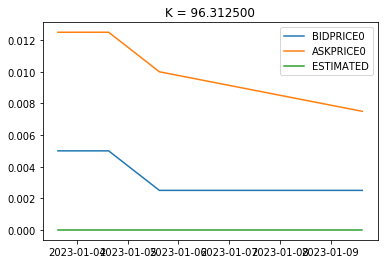

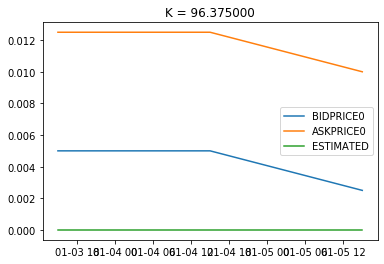

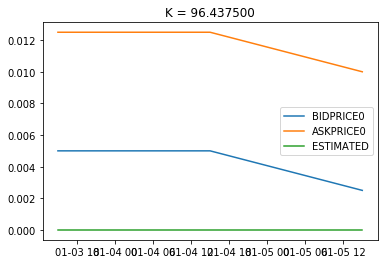

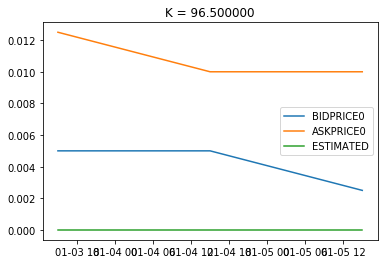

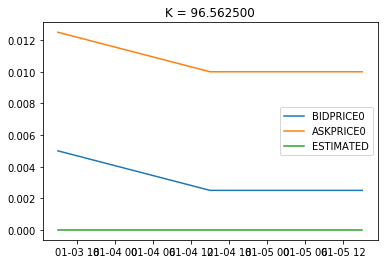

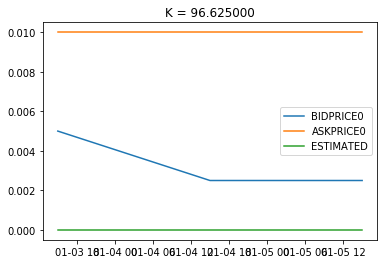

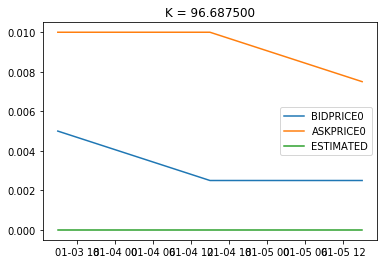

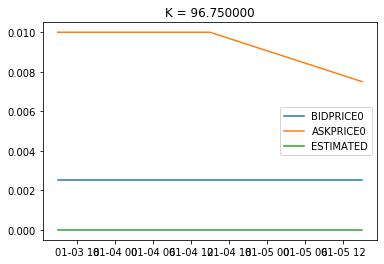

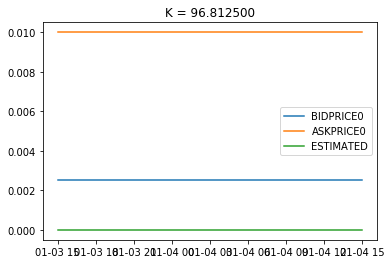

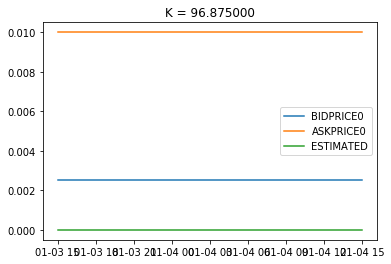

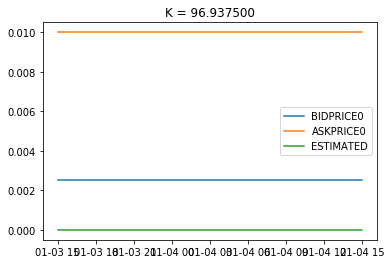

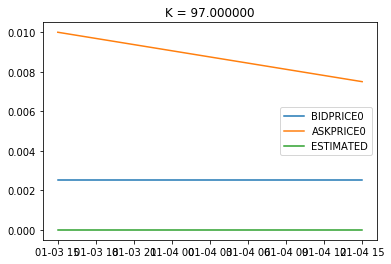

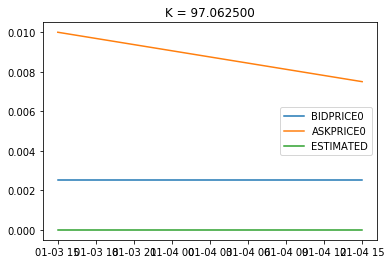

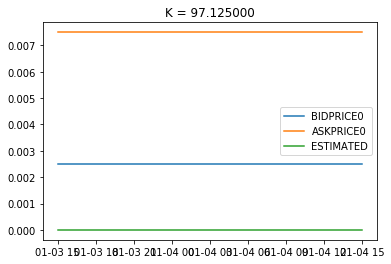

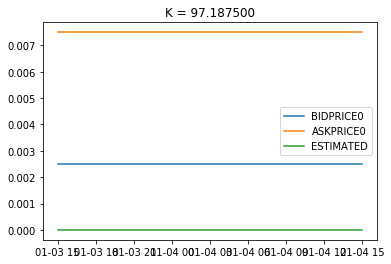

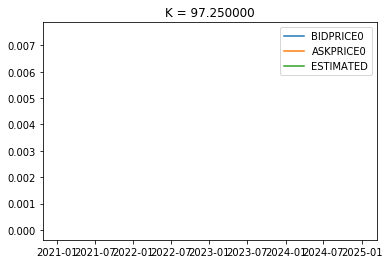

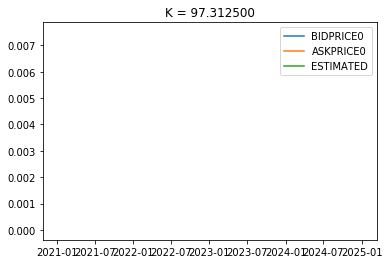

In [69]:
grouped = estimated.groupby('StrikePrice')
for k, g in grouped:
    g = estimated.xs(k)
    # print(g)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.title('K = %f' % (k))
    plt.show()

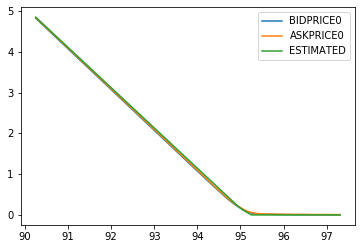

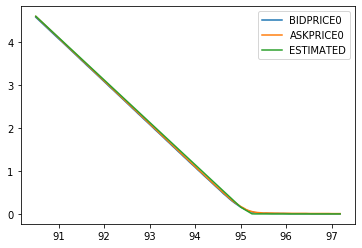

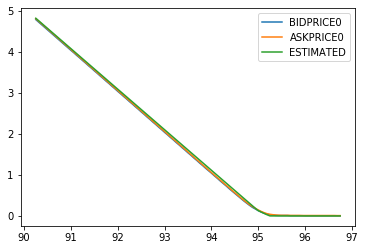

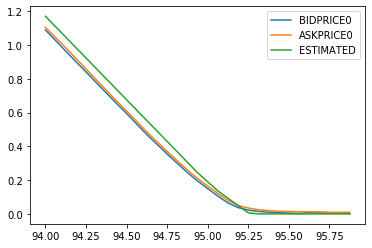

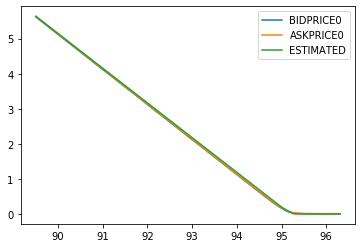

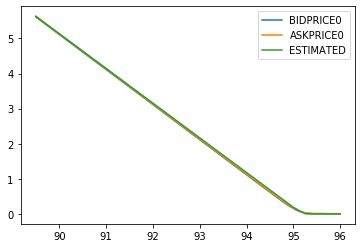

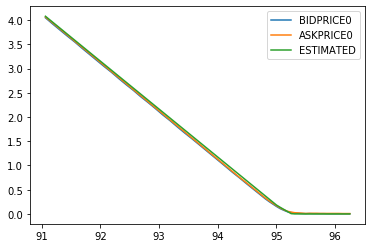

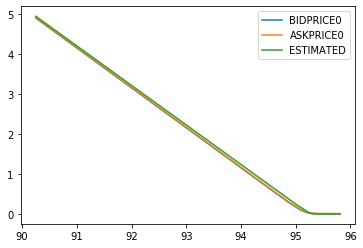

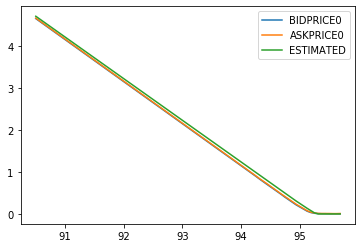

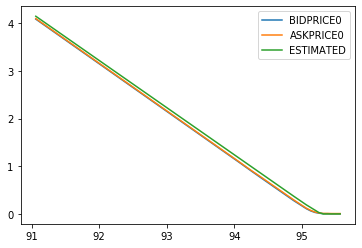

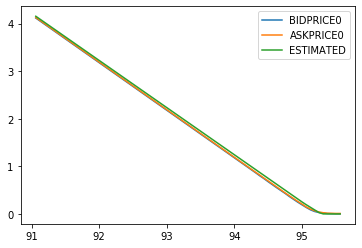

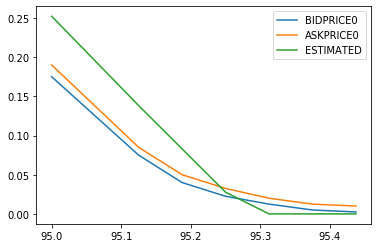

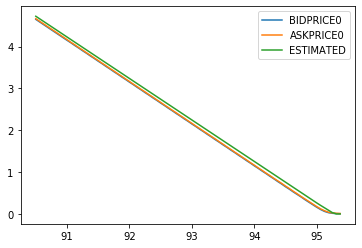

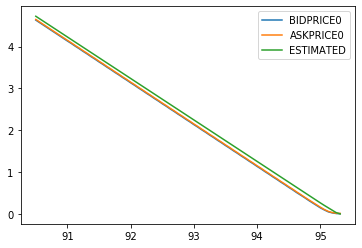

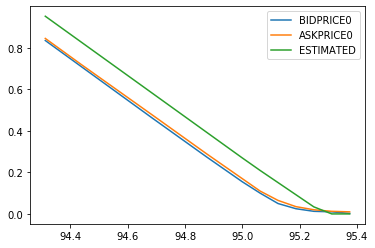

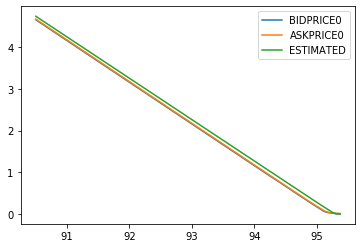

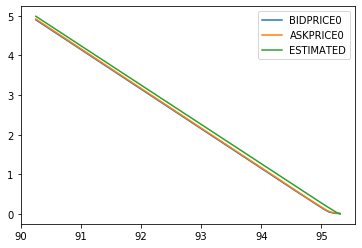

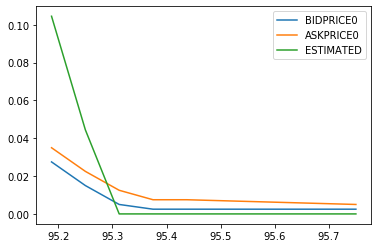

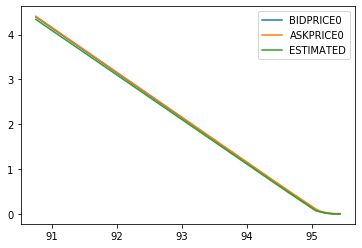

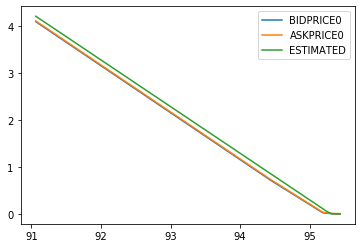

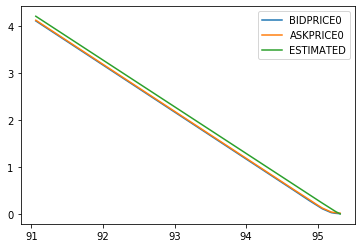

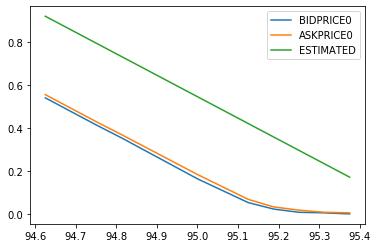

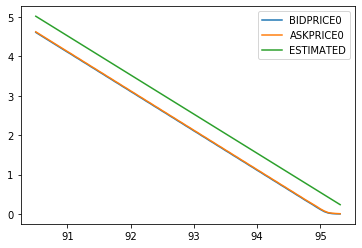

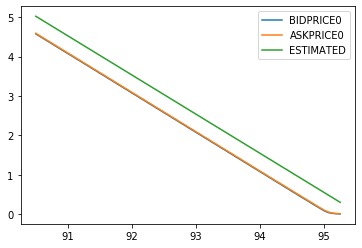

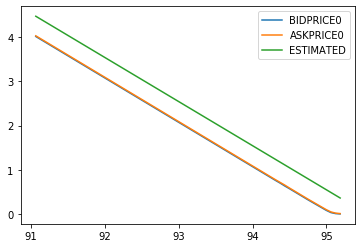

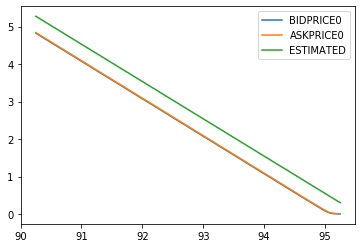

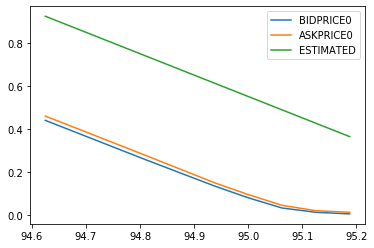

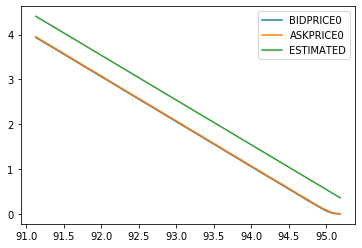

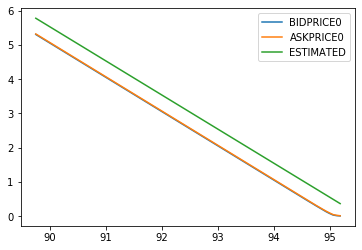

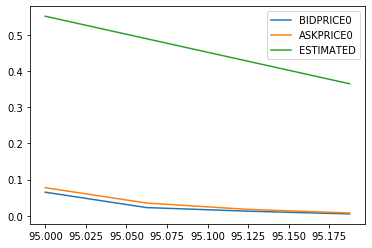

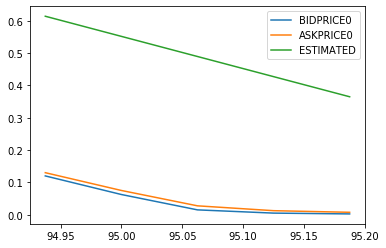

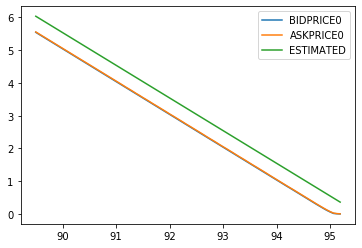

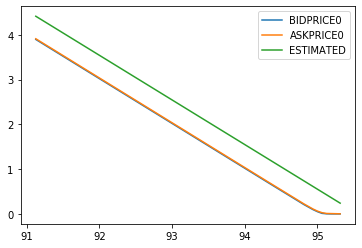

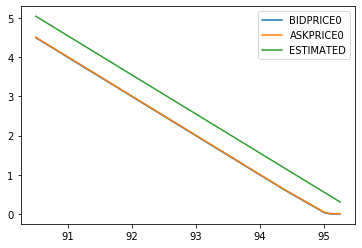

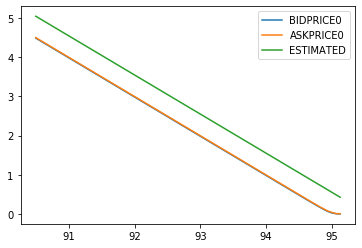

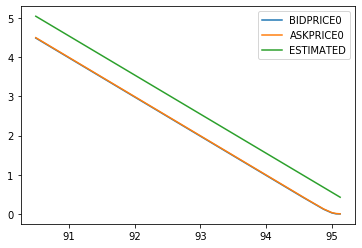

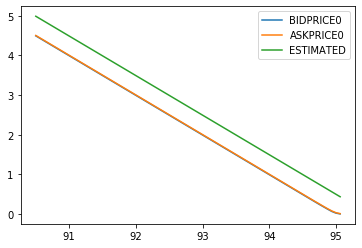

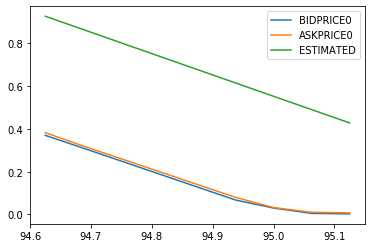

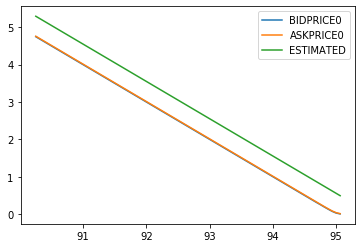

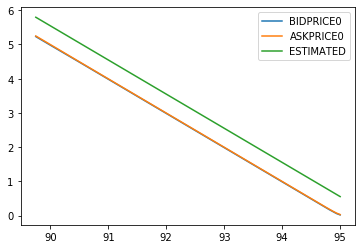

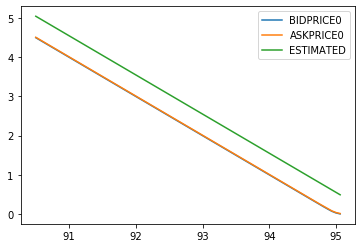

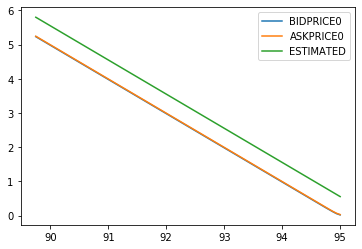

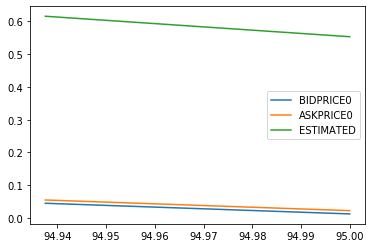

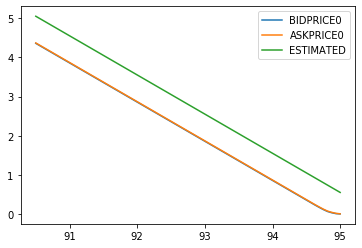

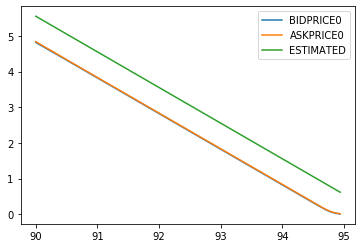

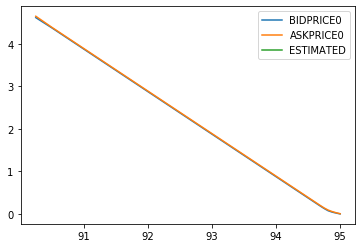

In [45]:
# estimated.loc['2023-01-03 15:00:00']
estimated = estimated.swaplevel()
grouped = estimated.groupby('Timestamp')
for t, g in grouped:
    g = estimated.xs(t)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.show()

In [87]:
estimated.xs('2023-01-03 15:00:00').index

Float64Index([95.4375, 95.1875, 95.0625,   95.25,    92.0,  95.125,  95.375,
              95.3125,   95.75, 94.8125,   90.25],
             dtype='float64', name='StrikePrice')

### Weibull distribution

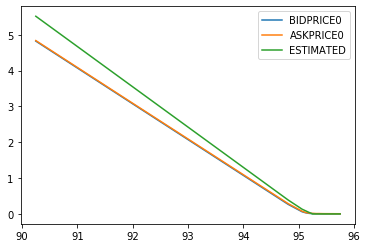

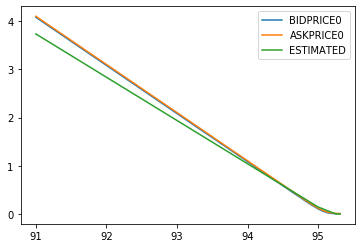

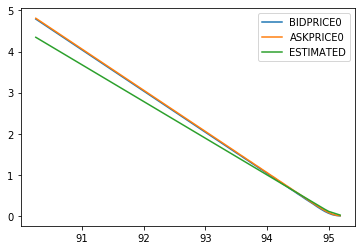

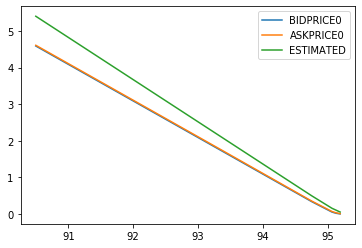

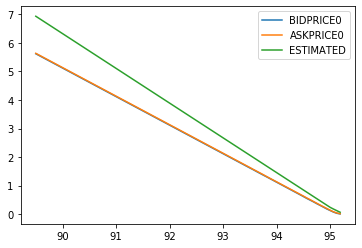

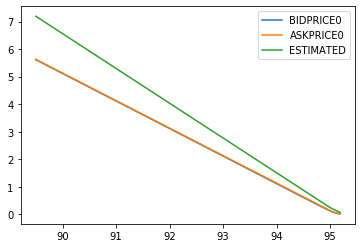

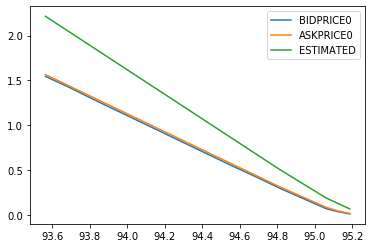

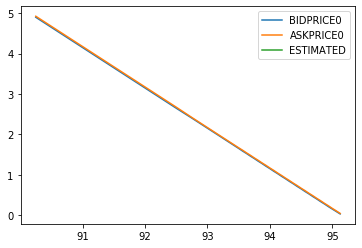

In [41]:
# estimated.loc['2023-01-03 15:00:00']
estimated = estimated.swaplevel()
grouped = estimated.groupby('Timestamp')
for t, g in grouped:
    g = estimated.xs(t)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.show()

In [ ]:
estimated = estimated.swaplevel()

In [95]:
estimated

BIDPRICE0  ASKPRICE0  ESTIMATED
StrikePrice Timestamp                                           
95.4375     2023-01-03 15:00:00     0.0025     0.0075   0.003198
95.1875     2023-01-03 15:00:00     0.0150     0.0225   0.107492
95.0625     2023-01-03 15:00:00     0.0600     0.0750   0.191657
95.2500     2023-01-03 15:00:00     0.0075     0.0150   0.068362
92.0000     2023-01-03 15:00:00     3.0750     3.0900   2.268933
...                                    ...        ...        ...
93.8750     2023-01-12 15:00:00     1.2800     1.2950        NaN
93.8125     2023-01-12 15:00:00     1.3400     1.3600        NaN
93.6875     2023-01-12 15:00:00     1.4650     1.4850        NaN
93.6250     2023-01-12 15:00:00     1.5300     1.5450        NaN
93.5625     2023-01-12 15:00:00     1.5900     1.6100        NaN

[172 rows x 3 columns]

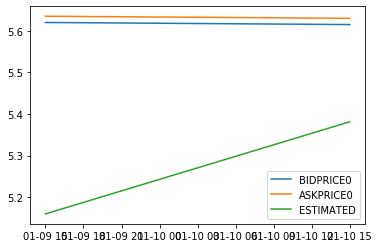

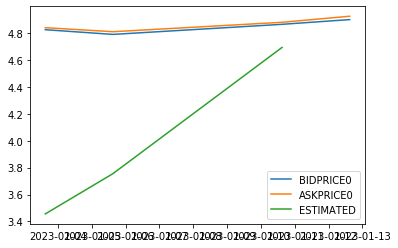

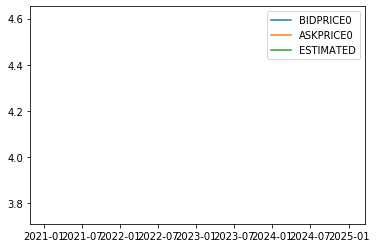

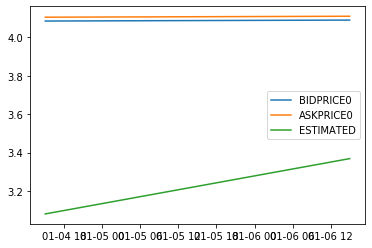

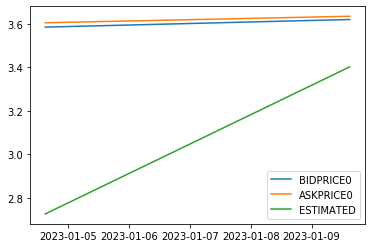

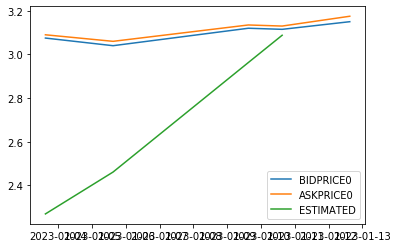

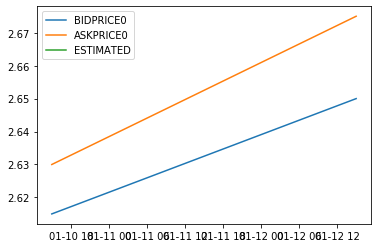

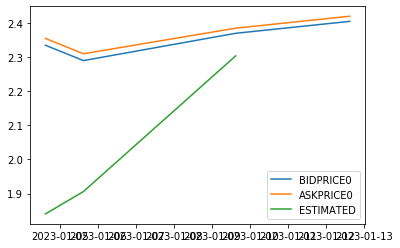

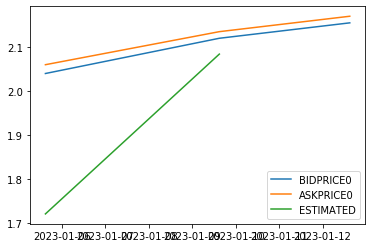

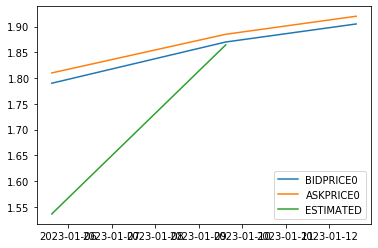

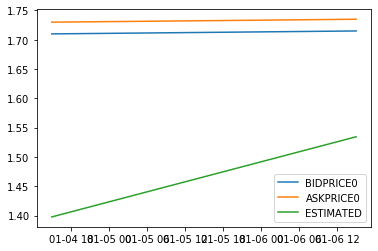

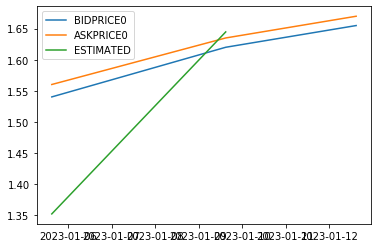

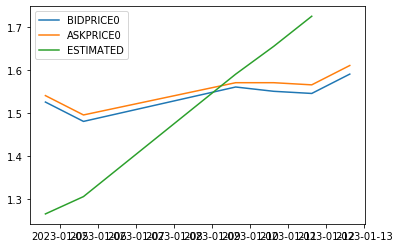

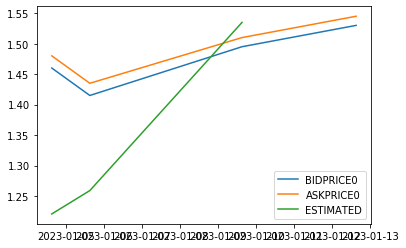

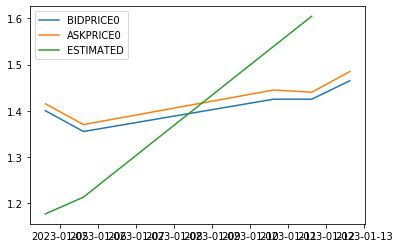

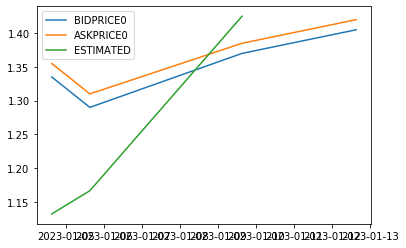

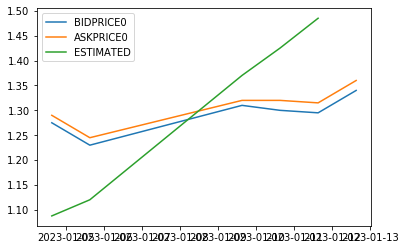

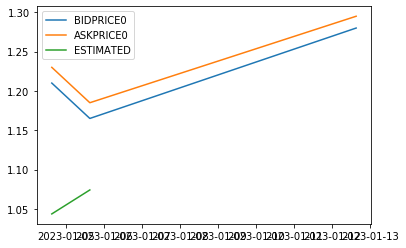

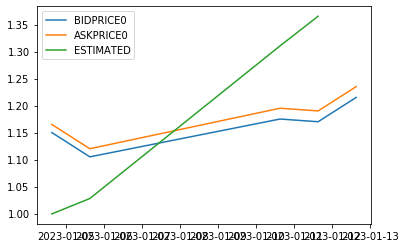

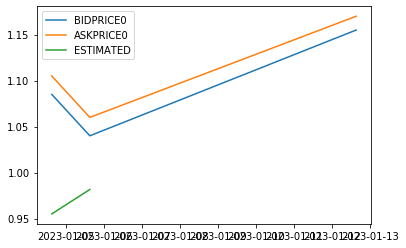

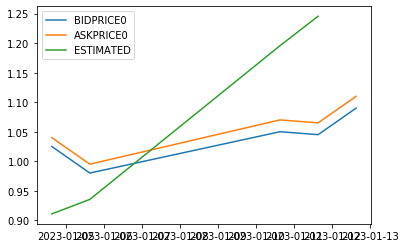

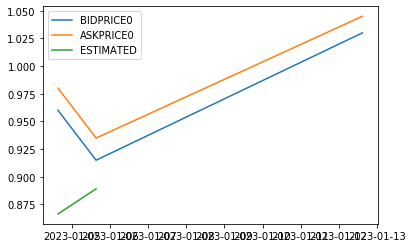

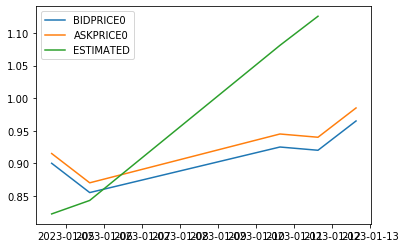

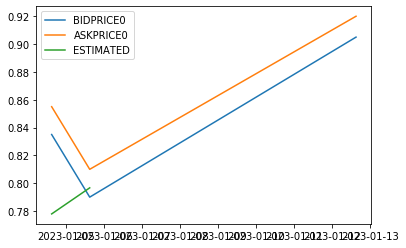

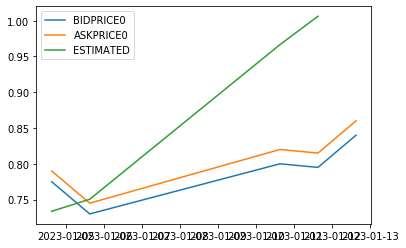

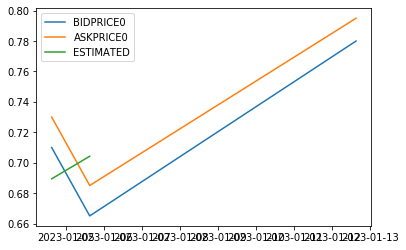

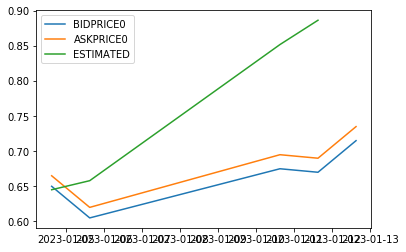

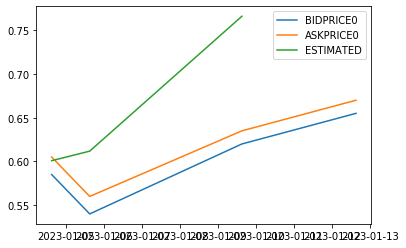

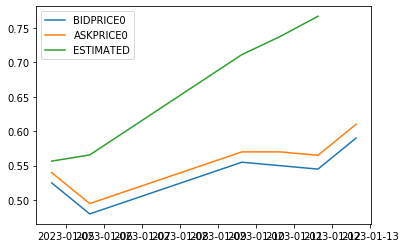

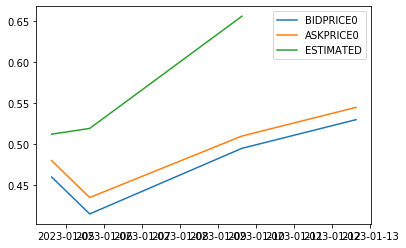

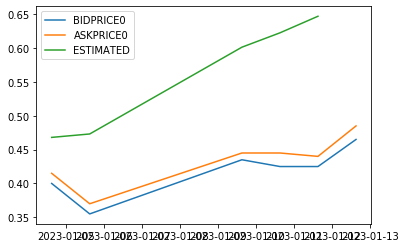

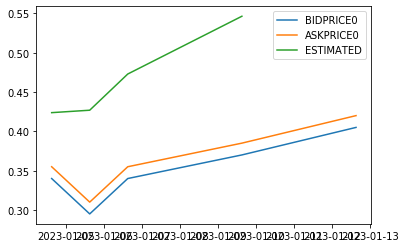

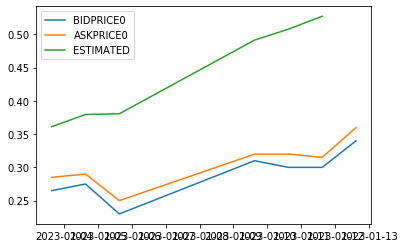

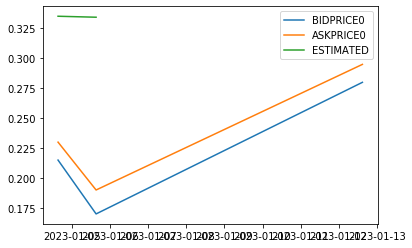

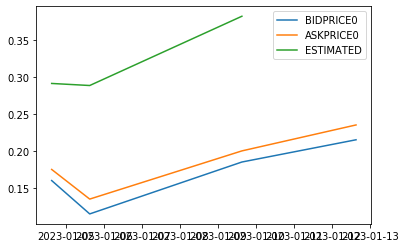

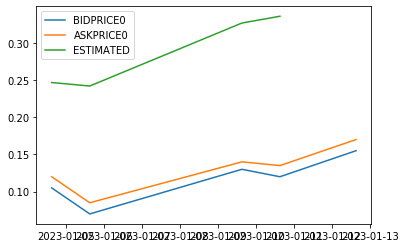

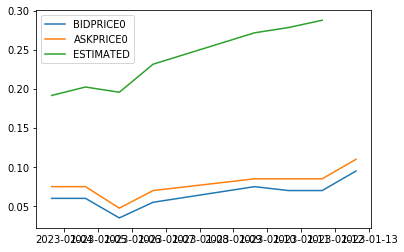

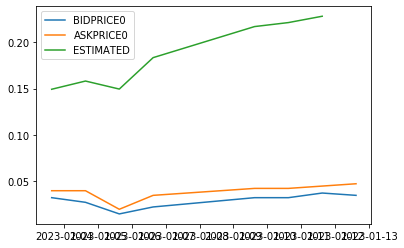

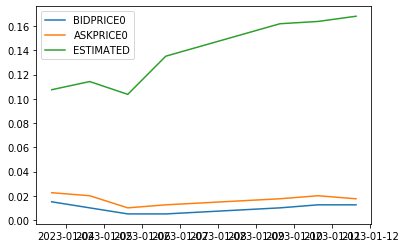

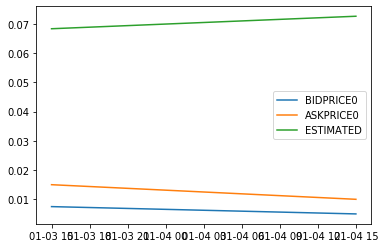

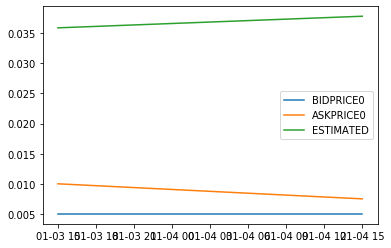

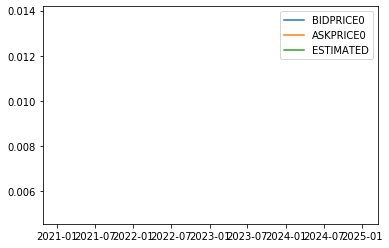

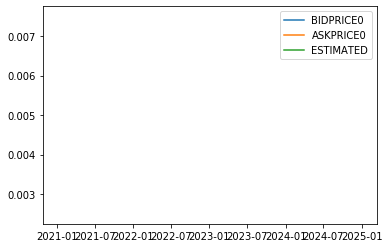

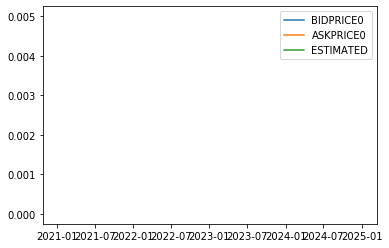

In [96]:
grouped = estimated.groupby('StrikePrice')
for k, g in grouped:
    g = estimated.xs(k)
    # x = g.xs('StrikePrice', level=1)
    g = g.sort_index()
    plt.plot(g.index, g.BIDPRICE0)
    plt.plot(g.index, g.ASKPRICE0)
    plt.plot(g.index, g.ESTIMATED)
    plt.legend(g.columns)
    plt.show()

In [23]:
price_estimated = []
for idx, test in option_use.iloc[:100, ].iterrows():
    myoption = Option(test.BaseAssetName, test.Expiration, test.AssetTypeName, test.StrikePrice)
    
    myoption.obs_data(test.Timestamp, test.BIDPRICE0, test.ASKPRICE0)
    baseasset = myoption.get_future(futures_df=futures)
    myoption.cal_effectiverate(index)
    probs, ratechanges = myoption.get_ratedistribution(FEDRates)
    payoff = myoption.cal_payoff(vol=0.25)
    DF = np.exp(-myoption.get_discountrate(BucketRates)*myoption.datetomature)
    price = payoff * DF
    price_estimated.append(price)

In [24]:
price_estimated

[0.042327595813993854,
 0.13542439783815965,
 0.20349230522836406,
 0.10621544847631621,
 2.2689326163201007,
 0.1680355870445562,
 0.05954275569803102,
 0.08084118660896271,
 0.00416482505178881,
 0.36241977636232353,
 3.4559480317238704,
 2.870445980617038e-08,
 0.04904197209237733,
 6.268118533644313e-06,
 0.012353506832435971,
 0.0035024438190394383,
 0.005558248468525552,
 0.11797271124795429,
 8.604360336887589e-07,
 0.0021113583642943133,
 2.3877459548911647e-06,
 0.008454864028541075,
 0.03952424397841976,
 0.00017334869914989548,
 0.05939018114881082,
 0.21678098345251942,
 0.0006672412161354838,
 0.0012155236730020866,
 1.557708638583019e-05,
 0.023593878459448974,
 0.030999475477617867,
 0.017377831771265145,
 0.00034875726721819163,
 8.184738630175642e-05,
 2.931695001269517e-07,
 0.07039346870777399,
 9.43871525005734e-08,
 3.667035937176641e-05,
 0.1057739070080067,
 1.0086345988101169,
 7.09898048683228e-18,
 1.2543440819572537e-14,
 2.238925147349606e-09,
 2.56429559641

In [25]:
option_use.MID_PRICE.iloc[:100]

0      0.00500
2      0.01875
5      0.06750
6      0.01125
7      3.08250
        ...   
145    0.27250
146    0.08500
147    0.23750
149    0.01375
151    0.00625
Name: MID_PRICE, Length: 100, dtype: float64

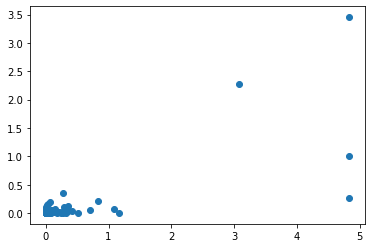

In [27]:
plt.scatter(option_use.MID_PRICE.iloc[:100], price_estimated)

In [35]:
probs, ratechanges

([0.6354899993603096, 0.3645100006396904],
 [0.0011263736263736263, 0.0022527472527472526])

In [79]:
0.0012/30*252 * myoption.datetomature 

0.09072

In [71]:
fx = np.zeros(100000)
x = np.linspace(-myoption.baseasset.price, 100-myoption.baseasset.price, 100000)
ST = myoption.baseasset.price - x
payoff = [st - myoption.K if st - myoption.K> 0 else 0 for st in ST]
vol = 0.04
for i in range(len(ratechanges)):
    fx += probs[i]*norm.pdf(x, loc=ratechanges[i]*100, scale=vol)
print(sum(payoff*fx*1e-3))

0.0011953862007786965


In [168]:
baseasset = myoption.get_future(futures_df=futures)
baseasset.price

95.49875

In [169]:
(myoption.expiration - myoption.obsdate).days

9

In [170]:
baseasset.price

95.49875

In [171]:
myoption.K

95.4375

In [172]:
myoption.cal_effectiverate(index)

(6.018323000000003, 5.9265840000000125, 4.263694333333329)

In [173]:
(baseasset.price - myoption.K)

0.06125000000000114

In [174]:
myoption.get_ratedistribution(FEDRates)

([0.6354899993603096, 0.3645100006396904],
 [0.0011263736263736263, 0.0022527472527472526])

1. Option Price:
\begin{align}
P &= e^{-r(T-t)}(F_T-K)^+ \\
\end{align}


In [21]:
(baseasset.price - myoption.K) * np.exp(-myoption.get_discountrate(BucketRates)*myoption.datetomature)

0.04154595499868334

In [22]:
myoption.get_discountrate(BucketRates)

0.0431292983868227

In [23]:
myoption.get_discountrate(BucketRates, 'simple')

0.0431292983868227

In [24]:
index[index['Effective Date'] == '2023-01-03']

Effective Date Rate Type  Rate (%)  1st Percentile (%)  \
125     2023-01-03    SOFRAI       NaN                 NaN   

     25th Percentile (%)  75th Percentile (%)  99th Percentile (%)  \
125                  NaN                  NaN                  NaN   

     Volume ($Billions)  Target Rate From (%)  Target Rate To (%)  \
125                 NaN                   NaN                 NaN   

     Intra Day - Low (%)  Intra Day - High (%)  Standard Deviation (%)  \
125                  NaN                   NaN                     NaN   

     30-Day Average SOFR  90-Day Average SOFR  180-Day Average SOFR  \
125              4.12655              3.67716               2.95568   

     SOFR Index  Revision Indicator (Y/N)  Footnote ID  
125    1.060183                       NaN          NaN

In [25]:
myoption.get_discountrate(BucketRates)

0.0431292983868227

In [95]:
FedFOMC = myoption.get_ratedistribution(FEDRates)
FedFOMC

Date  -0.0125  -0.01  -0.0075  -0.005  -0.0025  0.0   0.0025    0.005  \
0 2023-02-01      0.0    0.0      0.0     0.0      0.0  0.0  0.63549  0.36451   

   0.0075  0.01  0.0125  
0     0.0   0.0     0.0

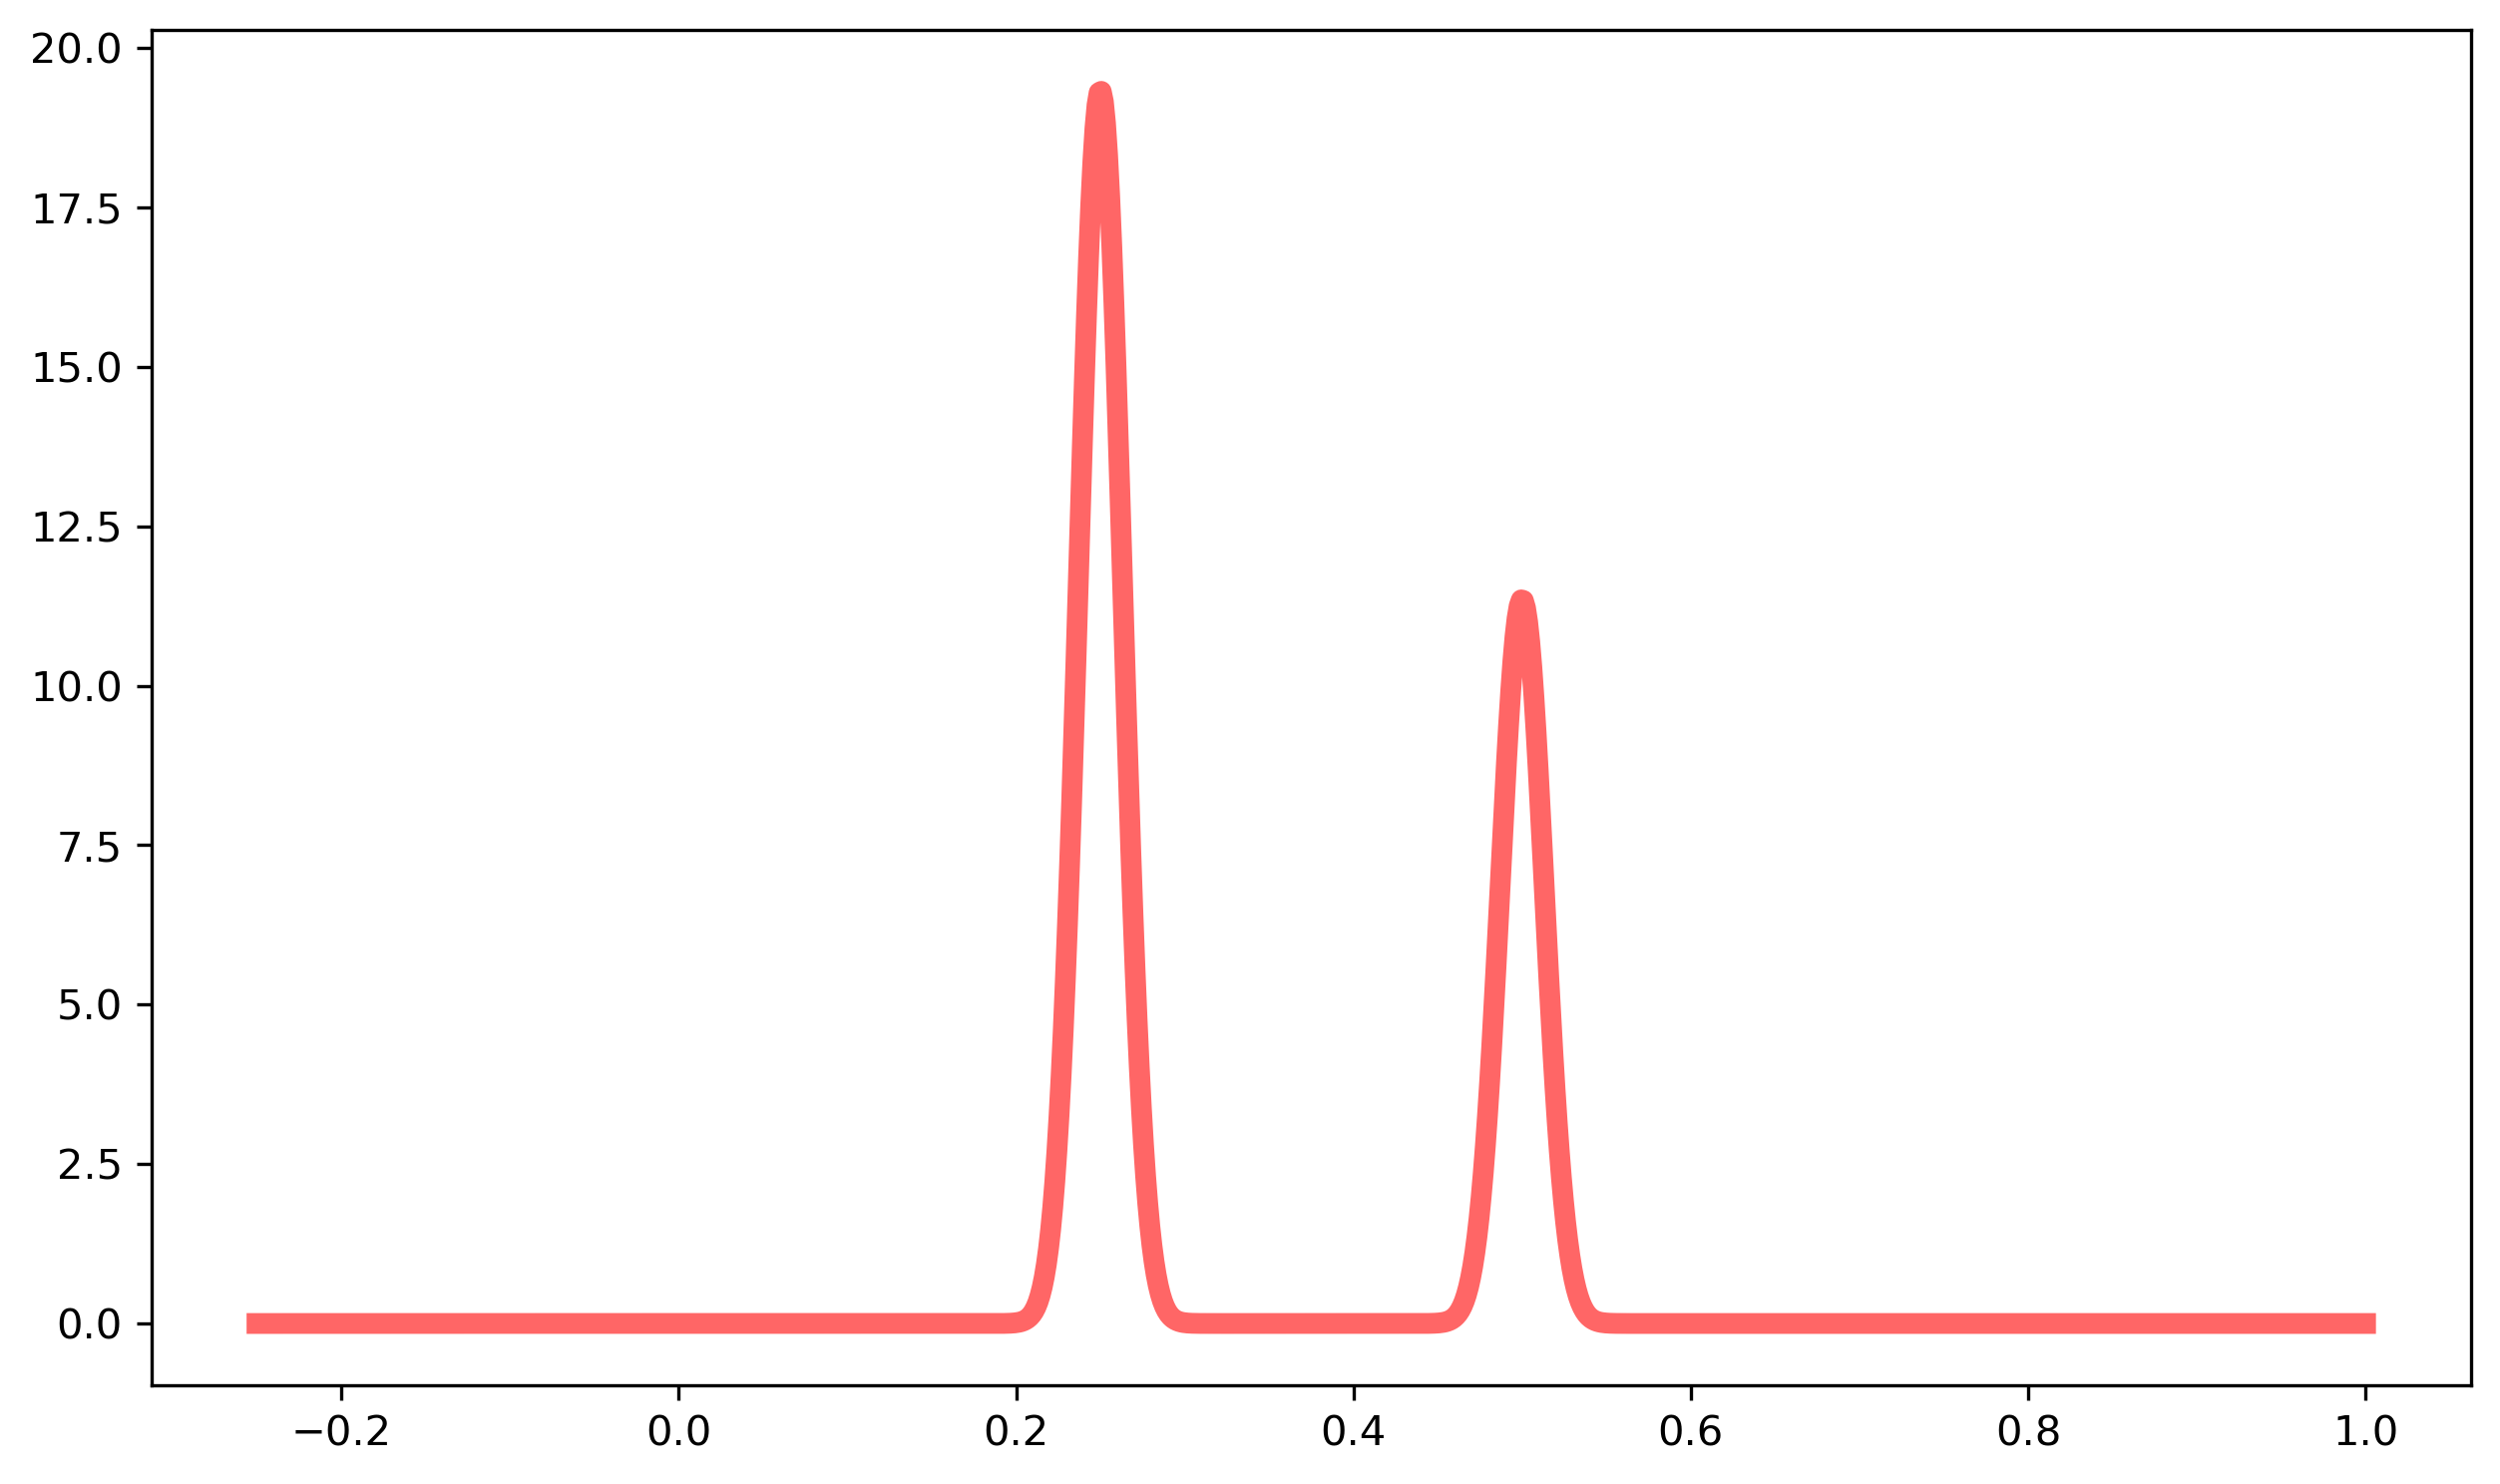

In [102]:
sigma = myoption.baseasset.days * 0.001
mu1, mu2 = 0.25, 0.5
x = np.linspace(-.25, 1, 1000)
# fig, ax = plt.subplots(1, 1)
p = 0.63
mean, var, skew, kurt = norm.stats(moments='mvsk')
plt.figure(dpi=300, figsize=(10, 6))
plt.plot(x, p*norm(loc=mu1, scale=sigma).pdf(x)+(1-p)*norm(loc=mu2, scale=sigma).pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [33]:
FedFOMC

Date  -0.0125  -0.01  -0.0075  -0.005  -0.0025  0.0    0.0025  \
0 2023-02-01      0.0    0.0      0.0     0.0      0.0  0.0  0.635490   
1 2023-03-22      0.0    0.0      0.0     0.0      0.0  0.0  0.150995   
2 2023-05-03      0.0    0.0      0.0     0.0      0.0  0.0  0.085356   
3 2023-06-14      0.0    0.0      0.0     0.0      0.0  0.0  0.082116   

      0.005    0.0075      0.01    0.0125  
0  0.364510  0.000000  0.000000  0.000000  
1  0.571104  0.277901  0.000000  0.000000  
2  0.388478  0.405360  0.120807  0.000000  
3  0.376972  0.404719  0.131608  0.004586

In [38]:
FedFOMC = FEDRates['20230103'].copy()
FedFOMC = FedFOMC.iloc[:1,]

In [39]:
situationnum = 0
probs = [1]
ratechanges = [0]
today = myoption.obsdate
exprate = []
days_intr = []
for idx, row in FedFOMC.iterrows():
    rateprob = row[(row != 0)]
    del rateprob['Date']
    # FOMCdict[row['Date']] = rateprob
    prob = rateprob.values  
    probs = [i * j for i in probs for j in prob]
    print(probs)
    ratechange = rateprob.index.values
    ## calculating the date length
    ## adjust rate change values
    days_intr.append((row['Date']-today).days)
    today = row['Date']
    print(days_intr[-1])
    # print(myoption.contract_days)
    ratechanges = [i + (1-days_intr[-1]/myoption.contract_days)*float(j) for i in ratechanges for j in ratechange]
    print(ratechanges)
    exprate.append(sum([i*j for i in probs for j in ratechanges]))
days_intr.append((myoption.baseasset.expiration - today).days)

[0.6354899993603096, 0.3645100006396904]
28
[0.0017307692307692308, 0.0034615384615384616]


In [41]:
fx = np.zeros(1000)
x = np.linspace(-1, 1, 1000)
ST = myoption.baseasset.price - x
payoff = [st - myoption.K if st - myoption.K> 0 else 0 for st in ST]
vol = 0.25
for i in range(len(ratechanges)):
    fx += probs[i]*norm.pdf(x, loc=ratechanges[i]*100, scale=vol)
print(sum(payoff*fx))

19.91166641883401


In [30]:
myoption.bidprice

0.0025

In [31]:
myoption.askprice

0.0075

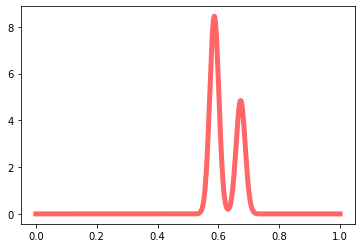

In [181]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(1, 1)
p = 0.8
mean, var, skew, kurt = norm.stats(moments='mvsk')
# p*norm.pdf(x, loc=0.25, scale=0.03)+(1-p)*norm.pdf(x, loc=0.5, scale=0.03)
ax.plot(x, fx, 
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [32]:
sum([i*j for i in exprate for j in days_intr[1:]])

[0.007500000000000001, 0.05249999999999999, 0.36, 2.6999999999998976]

In [35]:
days_intr[1:]

[49, 42, 42, -92]